In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/rupali/Documents/Master Thesis/jenga')

In [2]:
import random
import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from jenga.basis import Dataset
from jenga.corruptions.generic import MissingValues, SwappedValues, CategoricalShift
from jenga.corruptions.numerical import Scaling, GaussianNoise
from jenga.cleaning.ppp import PipelinePerformancePrediction
from jenga.cleaning.outlier_detection import NoOutlierDetection, PyODKNNOutlierDetection, PyODIsolationForestOutlierDetection, PyODPCAOutlierDetection, PyODCBLOFOutlierDetection, PyODSOSOutlierDetection, SklearnOutlierDetection
from jenga.cleaning.imputation import MeanModeImputation, SklearnImputation, DatawigImputation
from jenga.cleaning.clean import Clean

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [3]:
## use categorical columns as strings
def cat_cols_to_str(df):
    for col in df.columns:
        if pd.api.types.is_categorical_dtype(df[col]):
            df[col] = df[col].astype(str)

    return df

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def run_experiment(dataset_name, learner, param_grid, corruptions, fraction, cleaners, num_repetitions, categorical_precision_threshold=0.85, numerical_std_error_threshold=0.9):
    
    ## dataset
    dataset = Dataset(dataset_name)
    
    all_data = dataset.all_data
    attribute_names = dataset.attribute_names
    attribute_types = dataset.attribute_types
    
    ## categorical and numerical features
    categorical_columns = dataset.categorical_columns
    numerical_columns = dataset.numerical_columns
    print(f"Found {len(categorical_columns)} categorical and {len(numerical_columns)} numeric features \n")
    
    ## train and test data
    df_train, lab_train, df_test, lab_test = dataset.get_train_test_data()
    ### if we don't convert the categorical columns to str, the swapping corruption doesn't let us assign new values to the column: "Cannot setitem on a Categorical with a new category, set the categories first"
    df_train = cat_cols_to_str(df_train)
    df_test = cat_cols_to_str(df_test)
    
    ## pipeline performance prediction (ppp)
    ppp = PipelinePerformancePrediction(df_train, lab_train, df_test, lab_test, categorical_columns, numerical_columns, learner, param_grid)
    ppp_model = ppp.fit_ppp(df_train)
    ## the class column is added to the training data for Autogluon model fit
    if learner == None:
        df_train = df_train.loc[:, df_train.columns != 'class']
    
    ## generate corrupted data
    for _ in range(num_repetitions):
        df_corrupted, perturbations, cols_perturbed, summary_col_corrupt = ppp.get_corrupted(df_test, corruptions, fraction, num_repetitions)
    
    ## cleaning
    clean = Clean(df_train, df_corrupted, categorical_columns, numerical_columns, categorical_precision_threshold, numerical_std_error_threshold, ppp, ppp_model, cleaners)
    df_outliers, df_cleaned, corrupted_score_ppp, best_cleaning_score, cleaner_scores_ppp, summary_cleaners = clean(df_train, df_test, df_corrupted, cols_perturbed)
    
    ## results
    result = {
        'ppp_score_model': ppp.predict_score_ppp(ppp_model, df_test),
        'ppp_score_corrupted': corrupted_score_ppp,
        'ppp_score_cleaned': best_cleaning_score,
        'ppp_scores_cleaners': cleaner_scores_ppp
    }
#     print('\n'.join([f'{key}:{val}' for key, val in result.items()]))
    
    ## summary
    summary = {
        'dataset': dataset_name,
        'model': learner,
        'corruptions': summary_col_corrupt,
        'cleaners': summary_cleaners,
        'result': result
    }
#     print('\n\n\n\n'.join([f'{key}:{val}' for key, val in summary.items()]))
    
    return summary #summary_col_corrupt, result

### Altogether

In [5]:
datasets = [
    'thoracic_surgery',
    'cleve',
    'acute-inflammations'
#     'hill-valley'
]

In [6]:
## model parameters
## models is a dict where key = leaner & value = param_grid
models = {SGDClassifier(loss='log'): {'learner__max_iter': [500, 1000, 5000], 
                                         'learner__penalty': ['l2', 'l1', 'elasticnet'], 
                                         'learner__alpha': [0.0001, 0.001, 0.01, 0.1]
                                        } 
#           RandomForestClassifier():{'learner__n_estimators': [100, 200, 500], 
#                                     'learner__max_depth': [5, 10, 15]
#                                    }
         }

## make dict of multiple leraners and corresponding param_grids

In [7]:
corruptions = [[MissingValues, Scaling, CategoricalShift, GaussianNoise]] #SwappedValues

In [8]:
fractions = [0.15, 0.25, 0.5, 0.75, 0.9]

In [9]:
cleaners = []
for od in [NoOutlierDetection, PyODKNNOutlierDetection, PyODIsolationForestOutlierDetection, PyODPCAOutlierDetection, PyODCBLOFOutlierDetection, PyODSOSOutlierDetection, SklearnOutlierDetection]:
    for imp in [MeanModeImputation, SklearnImputation, DatawigImputation]:
        cleaners.append((od, imp))

In [ ]:
# stdoutOrigin=sys.stdout 
# sys.stdout = open("/home/rupali/Documents/Master Thesis/jenga/out/experiments.txt", "w")

# for _ in range(10):
#   print("\n\n..................................ITERATION..................................\n")
ind_results = {}

for fraction in fractions:
    ind_results[fraction] = []
    for learner, param_grid in models.items():
        for corruption in corruptions:
            for dataset in datasets:
                try:
                    ind_results[fraction].append(run_experiment(dataset, learner, param_grid, corruption, fraction, cleaners, 5))
                except ConnectionError:
                    print(f'Connection refused for dataset: {dataset}')
                    continue
                except ValueError:
                    print("Something went wrong with a value :(")
                    continue
        
# sys.stdout.close()
# sys.stdout=stdoutOrigin

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dataset: thoracic_surgery
Found 13 categorical and 3 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    4.8s finished



Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE9', 'fraction': 0.15, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'PRE4', 'fraction': 0.15, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'PRE8', 'fraction': 0.15, 'sampling': 'MAR'}
	perturbation: GaussianNoise: {'column': 'AGE', 'fraction': 0.15, 'sampling': 'MAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE25', 'fraction': 0.15, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'PRE4', 'fraction': 0.15, 'sampling': 'MNAR'}
	perturbation: CategoricalShift: {'column': 'PRE11', 'fraction': 0.15, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'AGE', 'fraction': 0.15, 'sampling': 'MNAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE6', 'fraction': 0.15, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scal

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.425531914893617, 'Recall': 0.5, 'F1-score': 0.4597701149425288, 'Accuracy': 0.851063829787234}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8325237381309345, 'Recall': 0.7620253164556963, 'F1-score': 0.7419763513513513, 'Accuracy': 0.851063829787234, 'Mean Squared Error': 282805879.2025923}
Cleaner: (NoOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.492156862745098, 'classification_report': {'F': {'precision': 0.9139784946236559, 'recall': 1.0, 'f1-score': 0.9550561797752808, 'support': 85}, 'T': {'precision': 1.0, 'recall': 0.1111111111111111, 'f1-score': 0.19999999999999998, 'support': 9}, 'accuracy': 0.9148936170212766, 'macro avg': {'precision': 0.956989247311828, 'recall': 0.5555555555555556, 'f1-score': 0.5775280898876404, 'support': 94}, 'weighted avg': {'precision': 0.922214596202242, 'recall': 0.9148936170212766, 'f1-score': 0.882763566818073, 'support

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.9766666666666667
Classifier for col: PRE30 reached 0.7966666666666666
Classifier for col: PRE32 reached 0.9933333333333333
Regressor for col: PRE4/lower reached 0.16933888166858446
Regressor for col: PRE4/median reached 0.6471923337048404
Regressor for col: PRE4/upper reached 0.3022081753932312
Regressor for col: PRE5/lower reached -0.049064267820453256
Regressor for col: PRE5/median reached -0.021085004402230823
Regressor for col: PRE5/upper reached -0.41331634109337684
Regressor for col: AGE/lower reached -1.1046237112177024
Regressor for col: AGE/median reached 0.08158374278331326
Regressor for col: AGE/upper reached -1.1725438482746313
Imputed 14 values in column PRE30

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.425531914893617, 'Recall': 0.5, 'F1-score': 0.4597701149425288, 'Accuracy': 0.851063829787234}
Imputation method: SklearnImputation, Imputation Score: {'Pre

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8
Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.425531914893617, 'Recall': 0.5, 'F1-score': 0.4597701149425288, 'Accuracy': 0.851063829787234}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8400155279503105, 'Recall': 0.797739602169982, 'F1-score': 0.7826257503651175, 'Accuracy': 0.8670212765957447, 'Mean Squared Error': 282805879.2025923}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.4947712418300653, 'classification_report': {'F': {'precision': 0.9139784946236559, 'recall': 1.0, 'f1-score': 0.9550561797752808, 'support': 85}, 'T': {'precision': 1.0, 'recall': 0.1111111111111111, 'f1-score': 0.19999999999999998, 'support': 9}, 'accuracy': 0.9148936170212766, 'macro avg': {'precision': 0.956989247311828, 'recall': 0.5555555555555556, 'f1-score': 0.5775280898876404, 'support': 94}, 'weighted avg': {'precision': 0.922214596202242, 'recall': 0.9148936170212766, 'f1-score': 0.882763566818073, 'support'

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.6985372949953675, 'Recall': 0.7587053571428571, 'F1-score': 0.7190607659819901, 'Accuracy': 0.8776595744680851}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8325237381309345, 'Recall': 0.7620253164556963, 'F1-score': 0.7419763513513513, 'Accuracy': 0.851063829787234, 'Mean Squared Error': 33.138818599105136}
Cleaner: (PyODKNNOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.5555555555555556, 'classification_report': {'F': {'precision': 0.9120879120879121, 'recall': 0.9764705882352941, 'f1-score': 0.9431818181818181, 'support': 85}, 'T': {'precision': 0.3333333333333333, 'recall': 0.1111111111111111, 'f1-score': 0.16666666666666666, 'support': 9}, 'accuracy': 0.8936170212765957, 'macro avg': {'precision': 0.6227106227106227, 'recall': 0.5437908496732026, 'f1-score': 0.5549242424242424, 'support': 94}, 'weighted avg': {'precision': 0.8566752396539631, 'recall'

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.6833333333333333
Classifier for col: PRE6 reached 0.8400000000000001
Classifier for col: PRE7 reached 0.9233333333333333
Classifier for col: PRE8 reached 0.8666666666666667
Classifier for col: PRE9 reached 0.9366666666666666
Classifier for col: PRE10 reached 0.8666666666666667
Classifier for col: PRE11 reached 0.8566666666666667
Classifier for col: PRE14 reached 0.5133333333333334
Classifier for col: PRE17 reached 0.9233333333333333
Classifier for col: PRE25 reached 0.9833333333333334
Classifier for col: PRE30 reached 0.8366666666666667


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE32 reached nan
Regressor for col: PRE4/lower reached 0.22190610856419846
Regressor for col: PRE4/median reached 0.643906419012455
Regressor for col: PRE4/upper reached 0.37366122744198293
Regressor for col: PRE5/lower reached -0.04389577705585346
Regressor for col: PRE5/median reached -0.04598718519690914
Regressor for col: PRE5/upper reached -0.8684647964179024
Regressor for col: AGE/lower reached -1.1037381197361988
Regressor for col: AGE/median reached 0.0007300738342735367
Regressor for col: AGE/upper reached -1.3707591852889536
Imputed 14 values in column PRE30
Imputed 17 values in column PRE4
Imputed 6 values in column PRE5
Imputed 25 values in column AGE

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.6985372949953675, 'Recall': 0.7587053571428571, 'F1-score': 0.7190607659819901, 'Accuracy': 0.8776595744680851}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.8325237381309345, 'Recall': 0.

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.6985372949953675, 'Recall': 0.7587053571428571, 'F1-score': 0.7190607659819901, 'Accuracy': 0.8776595744680851}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8325237381309345, 'Recall': 0.7620253164556963, 'F1-score': 0.7419763513513513, 'Accuracy': 0.851063829787234, 'Mean Squared Error': 28.32744151657962}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5581699346405229, 'classification_report': {'F': {'precision': 0.9111111111111111, 'recall': 0.9647058823529412, 'f1-score': 0.9371428571428572, 'support': 85}, 'T': {'precision': 0.25, 'recall': 0.1111111111111111, 'f1-score': 0.15384615384615383, 'support': 9}, 'accuracy': 0.8829787234042553, 'macro avg': {'precision': 0.5805555555555555, 'recall': 0.5379084967320261, 'f1-score': 0.5454945054945055, 'support': 94}, 'weighted avg': {'precision': 0.8478132387706856, 'recall': 0.8829787234042

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.6641636543319488, 'Recall': 0.7354910714285714, 'F1-score': 0.6615121244615009, 'Accuracy': 0.800531914893617}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8325237381309345, 'Recall': 0.7620253164556963, 'F1-score': 0.7419763513513513, 'Accuracy': 0.851063829787234, 'Mean Squared Error': 46.57803694506187}
Cleaner: (PyODIsolationForestOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.5542483660130718, 'classification_report': {'F': {'precision': 0.9120879120879121, 'recall': 0.9764705882352941, 'f1-score': 0.9431818181818181, 'support': 85}, 'T': {'precision': 0.3333333333333333, 'recall': 0.1111111111111111, 'f1-score': 0.16666666666666666, 'support': 9}, 'accuracy': 0.8936170212765957, 'macro avg': {'precision': 0.6227106227106227, 'recall': 0.5437908496732026, 'f1-score': 0.5549242424242424, 'support': 94}, 'weighted avg': {'precision': 0.8566

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7066666666666667
Classifier for col: PRE6 reached 0.8266666666666667
Classifier for col: PRE7 reached 0.9199999999999999
Classifier for col: PRE8 reached 0.8700000000000001
Classifier for col: PRE9 reached 0.9433333333333334
Classifier for col: PRE10 reached 0.8766666666666667
Classifier for col: PRE11 reached 0.86
Classifier for col: PRE14 reached 0.53
Classifier for col: PRE17 reached 0.9133333333333333


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.9666666666666667
Classifier for col: PRE30 reached 0.8233333333333333
Classifier for col: PRE32 reached 0.9933333333333333
Regressor for col: PRE4/lower reached 0.19902330001980972
Regressor for col: PRE4/median reached 0.7227654293362411
Regressor for col: PRE4/upper reached 0.407143683342872
Regressor for col: PRE5/lower reached -0.044263714101371976
Regressor for col: PRE5/median reached -0.18572605429653943
Regressor for col: PRE5/upper reached -0.27303935046080163
Regressor for col: AGE/lower reached -0.9614875207133479
Regressor for col: AGE/median reached 0.03870292420617477
Regressor for col: AGE/upper reached -1.1250796785003898
Imputed 14 values in column PRE30
Imputed 30 values in column PRE4
Imputed 25 values in column PRE5
Imputed 43 values in column AGE

Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.6748150281420089, 'Recall': 0.7522321428571

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8
Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.6662885899040468, 'Recall': 0.7397321428571428, 'F1-score': 0.6599285486696158, 'Accuracy': 0.7952127659574468}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8325237381309345, 'Recall': 0.7620253164556963, 'F1-score': 0.7419763513513513, 'Accuracy': 0.851063829787234, 'Mean Squared Error': 42.119181168305104}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5490196078431373, 'classification_report': {'F': {'precision': 0.9111111111111111, 'recall': 0.9647058823529412, 'f1-score': 0.9371428571428572, 'support': 85}, 'T': {'precision': 0.25, 'recall': 0.1111111111111111, 'f1-score': 0.15384615384615383, 'support': 9}, 'accuracy': 0.8829787234042553, 'macro avg': {'precision': 0.5805555555555555, 'recall': 0.5379084967320261, 'f1-score': 0.5454945054945055, 'support': 94}, 'weighted avg': {'precision': 0.8478132387706856, 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.6710413871318126, 'Recall': 0.7368303571428572, 'F1-score': 0.6822991789055814, 'Accuracy': 0.8404255319148937}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8325237381309345, 'Recall': 0.7620253164556963, 'F1-score': 0.7419763513513513, 'Accuracy': 0.851063829787234, 'Mean Squared Error': 37.85114426368772}
Cleaner: (PyODPCAOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.5333333333333333, 'classification_report': {'F': {'precision': 0.9101123595505618, 'recall': 0.9529411764705882, 'f1-score': 0.9310344827586207, 'support': 85}, 'T': {'precision': 0.2, 'recall': 0.1111111111111111, 'f1-score': 0.14285714285714285, 'support': 9}, 'accuracy': 0.8723404255319149, 'macro avg': {'precision': 0.5550561797752809, 'recall': 0.5320261437908497, 'f1-score': 0.5369458128078818, 'support': 94}, 'weighted avg': {'precision': 0.8421228783169973, 'recall': 0.872340425531

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.98
Classifier for col: PRE30 reached 0.8300000000000001
Classifier for col: PRE32 reached 0.99
Regressor for col: PRE4/lower reached 0.27757099929781975
Regressor for col: PRE4/median reached 0.6193090357796138
Regressor for col: PRE4/upper reached 0.35077641442577456
Regressor for col: PRE5/lower reached -0.05603811510079604
Regressor for col: PRE5/median reached 0.13767837547391065
Regressor for col: PRE5/upper reached -0.5613736770826013
Regressor for col: AGE/lower reached -0.9219868919520595
Regressor for col: AGE/median reached 0.06027068810397895
Regressor for col: AGE/upper reached -1.1895229228749813
Imputed 14 values in column PRE30
Imputed 20 values in column PRE4
Imputed 20 values in column PRE5
Imputed 36 values in column AGE

Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.6710413871318126, 'Recall': 0.7368303571428572, 'F1-score': 0.6822991789055814, 'Acc

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8
Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.6710413871318126, 'Recall': 0.7368303571428572, 'F1-score': 0.6822991789055814, 'Accuracy': 0.8404255319148937}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8325237381309345, 'Recall': 0.7620253164556963, 'F1-score': 0.7419763513513513, 'Accuracy': 0.851063829787234, 'Mean Squared Error': 38.385862568039464}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5516339869281046, 'classification_report': {'F': {'precision': 0.9101123595505618, 'recall': 0.9529411764705882, 'f1-score': 0.9310344827586207, 'support': 85}, 'T': {'precision': 0.2, 'recall': 0.1111111111111111, 'f1-score': 0.14285714285714285, 'support': 9}, 'accuracy': 0.8723404255319149, 'macro avg': {'precision': 0.5550561797752809, 'recall': 0.5320261437908497, 'f1-score': 0.5369458128078818, 'support': 94}, 'weighted avg': {'precision': 0.8421228783169973, 'recall': 0.8723404255319

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.6554230089247014, 'Recall': 0.7180803571428571, 'F1-score': 0.6573302131827334, 'Accuracy': 0.8085106382978724}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8325237381309345, 'Recall': 0.7620253164556963, 'F1-score': 0.7419763513513513, 'Accuracy': 0.851063829787234, 'Mean Squared Error': 41.959892665281764}
Cleaner: (PyODCBLOFOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.5516339869281046, 'classification_report': {'F': {'precision': 0.9120879120879121, 'recall': 0.9764705882352941, 'f1-score': 0.9431818181818181, 'support': 85}, 'T': {'precision': 0.3333333333333333, 'recall': 0.1111111111111111, 'f1-score': 0.16666666666666666, 'support': 9}, 'accuracy': 0.8936170212765957, 'macro avg': {'precision': 0.6227106227106227, 'recall': 0.5437908496732026, 'f1-score': 0.5549242424242424, 'support': 94}, 'weighted avg': {'precision': 0.8566752396539631, 'rec

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7133333333333334
Classifier for col: PRE6 reached 0.8300000000000001
Classifier for col: PRE7 reached 0.91
Classifier for col: PRE8 reached 0.8533333333333333
Classifier for col: PRE9 reached 0.9033333333333333
Classifier for col: PRE10 reached 0.8766666666666667
Classifier for col: PRE11 reached 0.8433333333333333
Classifier for col: PRE14 reached 0.5433333333333333
Classifier for col: PRE17 reached 0.8966666666666667
Classifier for col: PRE25 reached 0.9533333333333334
Classifier for col: PRE30 reached 0.8066666666666666
Regressor for col: PRE4/lower reached 0.2299039623303094
Regressor for col: PRE4/median reached 0.7003831873880004
Regressor for col: PRE4/upper reached 0.396659258531289
Regressor for col: PRE5/lower reached -0.05424841217019827
Regressor for col: PRE5/median reached -0.02085560252573654
Regressor for col: PRE5/upper reached -0.6657548826120637
Regressor for col: AGE/lower reached -0.8868172934954969
Regressor for col: AGE/median re

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8
Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.6808370970208061, 'Recall': 0.7573660714285714, 'F1-score': 0.6925369769072656, 'Accuracy': 0.8377659574468086}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8325237381309345, 'Recall': 0.7620253164556963, 'F1-score': 0.7419763513513513, 'Accuracy': 0.851063829787234, 'Mean Squared Error': 33.45859334575159}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.550326797385621, 'classification_report': {'F': {'precision': 0.9111111111111111, 'recall': 0.9647058823529412, 'f1-score': 0.9371428571428572, 'support': 85}, 'T': {'precision': 0.25, 'recall': 0.1111111111111111, 'f1-score': 0.15384615384615383, 'support': 9}, 'accuracy': 0.8829787234042553, 'macro avg': {'precision': 0.5805555555555555, 'recall': 0.5379084967320261, 'f1-score': 0.5454945054945055, 'support': 94}, 'weighted avg': {'precision': 0.8478132387706856, 'recall': 0.8829787234

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.5691489361702128, 'Recall': 0.625, 'F1-score': 0.5948275862068966, 'Accuracy': 0.8882978723404255}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8325237381309345, 'Recall': 0.7620253164556963, 'F1-score': 0.7419763513513513, 'Accuracy': 0.851063829787234, 'Mean Squared Error': 282805879.2025923}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.492156862745098, 'classification_report': {'F': {'precision': 0.9139784946236559, 'recall': 1.0, 'f1-score': 0.9550561797752808, 'support': 85}, 'T': {'precision': 1.0, 'recall': 0.1111111111111111, 'f1-score': 0.19999999999999998, 'support': 9}, 'accuracy': 0.9148936170212766, 'macro avg': {'precision': 0.956989247311828, 'recall': 0.5555555555555556, 'f1-score': 0.5775280898876404, 'support': 94}, 'weighted avg': {'precision': 0.922214596202242, 'recall': 0.9148936170212766, 'f1-score': 0.88276356681

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.6966666666666667
Classifier for col: PRE6 reached 0.8300000000000001
Classifier for col: PRE7 reached 0.9199999999999999
Classifier for col: PRE8 reached 0.9033333333333333
Classifier for col: PRE9 reached 0.9299999999999999
Classifier for col: PRE10 reached 0.9033333333333333
Classifier for col: PRE11 reached 0.8666666666666667
Classifier for col: PRE14 reached 0.51
Classifier for col: PRE17 reached 0.89


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.97
Classifier for col: PRE30 reached 0.82
Classifier for col: PRE32 reached 0.99
Regressor for col: PRE4/lower reached 0.21353764722953866
Regressor for col: PRE4/median reached 0.6848135789055082
Regressor for col: PRE4/upper reached 0.39034989847110957
Regressor for col: PRE5/lower reached -0.054068869547675535
Regressor for col: PRE5/median reached -0.02366782484739738
Regressor for col: PRE5/upper reached -0.364358435799256
Regressor for col: AGE/lower reached -1.0069229095651786
Regressor for col: AGE/median reached 0.0295305273725473
Regressor for col: AGE/upper reached -1.2309918277500254
Imputed 14 values in column PRE30

Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.5691489361702128, 'Recall': 0.625, 'F1-score': 0.5948275862068966, 'Accuracy': 0.8882978723404255}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.837459505541347, 'Recall'

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8
Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE

Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.5691489361702128, 'Recall': 0.625, 'F1-score': 0.5948275862068966, 'Accuracy': 0.8882978723404255}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8400155279503105, 'Recall': 0.797739602169982, 'F1-score': 0.7826257503651175, 'Accuracy': 0.8670212765957447, 'Mean Squared Error': 282805879.2025923}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.4947712418300653, 'classification_report': {'F': {'precision': 0.9139784946236559, 'recall': 1.0, 'f1-score': 0.9550561797752808, 'support': 85}, 'T': {'precision': 1.0, 'recall': 0.1111111111111111, 'f1-score': 0.19999999999999998, 'support': 9}, 'accuracy': 0.9148936170212766, 'macro avg': {'precision': 0.956989247311828, 'recall': 0.5555555555555556, 'f1-score': 0.5775280898876404, 'support': 94}, 'weighted avg

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Classifier for col: DGN reached 0.6733333333333333
Classifier for col: PRE6 reached 0.8533333333333333
Classifier for col: PRE7 reached 0.9266666666666667
Classifier for col: PRE8 reached 0.8533333333333333
Classifier for col: PRE9 reached 0.9233333333333333
Classifier for col: PRE10 reached 0.8733333333333333
Classifier for col: PRE11 reached 0.8633333333333333
Classifier for col: PRE14 reached 0.5266666666666666
Classifier for col: PRE17 reached 0.91


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.9733333333333334
Classifier for col: PRE30 reached 0.8333333333333333
Classifier for col: PRE32 reached 0.9766666666666666
Regressor for col: PRE4/lower reached 0.2115374407177932
Regressor for col: PRE4/median reached 0.6865034832961279
Regressor for col: PRE4/upper reached 0.2806483540672149
Regressor for col: PRE5/lower reached -0.05039592420045935
Regressor for col: PRE5/median reached -0.0076930162594749385
Regressor for col: PRE5/upper reached -0.07544066651410647
Regressor for col: AGE/lower reached -1.0521798482017861
Regressor for col: AGE/median reached 0.06322036891054167
Regressor for col: AGE/upper reached -1.4176639290936488
Column DGN contained 0 nans before, now 29
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 0 nans before, now 0
Column PRE11 contain

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.6833333333333333
Classifier for col: PRE6 reached 0.8466666666666667
Classifier for col: PRE7 reached 0.9466666666666667
Classifier for col: PRE8 reached 0.8466666666666667
Classifier for col: PRE9 reached 0.9466666666666667
Classifier for col: PRE10 reached 0.8866666666666667
Classifier for col: PRE11 reached 0.8633333333333333
Classifier for col: PRE14 reached 0.5366666666666666
Classifier for col: PRE17 reached 0.9099999999999999


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.9833333333333334
Classifier for col: PRE30 reached 0.8333333333333334
Classifier for col: PRE32 reached 0.9833333333333334
Regressor for col: PRE4/lower reached 0.3618968776153393
Regressor for col: PRE4/median reached 0.673161309870018
Regressor for col: PRE4/upper reached 0.33521567922867146
Regressor for col: PRE5/lower reached -0.04348304707142081
Regressor for col: PRE5/median reached 0.0973063709793412
Regressor for col: PRE5/upper reached -0.43195331932300357
Regressor for col: AGE/lower reached -1.0025620529046761
Regressor for col: AGE/median reached 0.028698412433628195
Regressor for col: AGE/upper reached -1.2119084593510352
Column DGN contained 0 nans before, now 24
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 0 nans before, now 0
Column PRE11 contained 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.6733333333333333
Classifier for col: PRE6 reached 0.8266666666666667
Classifier for col: PRE7 reached 0.9366666666666666
Classifier for col: PRE8 reached 0.8400000000000001
Classifier for col: PRE9 reached 0.8866666666666667
Classifier for col: PRE10 reached 0.86
Classifier for col: PRE11 reached 0.8633333333333333
Classifier for col: PRE14 reached 0.5666666666666667
Classifier for col: PRE17 reached 0.86


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.9766666666666667
Classifier for col: PRE30 reached 0.8333333333333333


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE32 reached nan
Regressor for col: PRE4/lower reached 0.2322415303005807
Regressor for col: PRE4/median reached 0.6218334927396192
Regressor for col: PRE4/upper reached 0.26122585690319383
Regressor for col: PRE5/lower reached -0.05490521509741564
Regressor for col: PRE5/median reached -0.09644917788639928
Regressor for col: PRE5/upper reached -0.26857638636335146
Regressor for col: AGE/lower reached -1.0465160791954302
Regressor for col: AGE/median reached 0.01434322668095334
Regressor for col: AGE/upper reached -1.1975547567337497
Column DGN contained 0 nans before, now 28
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 0 nans before, now 0
Column PRE11 contained 0 nans before, now 0
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 0 nans before, now 0
Column PRE19 contained 0 nans before, now 3
Colu

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8
Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.6854831108993054, 'Recall': 0.7716517857142857, 'F1-score': 0.6896804977885872, 'Accuracy': 0.8244680851063829}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8325237381309345, 'Recall': 0.7620253164556963, 'F1-score': 0.7419763513513513, 'Accuracy': 0.851063829787234, 'Mean Squared Error': 39.8096055412294}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5111111111111111, 'classification_report': {'F': {'precision': 0.9021739130434783, 'recall': 0.9764705882352941, 'f1-score': 0.9378531073446328, 'support': 85}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.8829787234042553, 'macro avg': {'precision': 0.45108695652173914, 'recall': 0.48823529411764705, 'f1-score': 0.4689265536723164, 'support': 94}, 'weighted avg': {'precision': 0.815795559666975, 'recall': 0.8829787234042553, 'f1-score': 0.8480586608967

INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/cleve


Imputed 14 values in column PRE30
Imputed 33 values in column PRE4
Imputed 26 values in column PRE5
Imputed 44 values in column AGE

Best cleaning method:
Cleaning score: Cleaner: (PyODIsolationForestOutlierDetection, SklearnImputation): {'roc_auc_score': 0.5594771241830065, 'classification_report': {'F': {'precision': 0.9120879120879121, 'recall': 0.9764705882352941, 'f1-score': 0.9431818181818181, 'support': 85}, 'T': {'precision': 0.3333333333333333, 'recall': 0.1111111111111111, 'f1-score': 0.16666666666666666, 'support': 9}, 'accuracy': 0.8936170212765957, 'macro avg': {'precision': 0.6227106227106227, 'recall': 0.5437908496732026, 'f1-score': 0.5549242424242424, 'support': 94}, 'weighted avg': {'precision': 0.8566752396539631, 'recall': 0.8936170212765957, 'f1-score': 0.8688346228239845, 'support': 94}}} 

Cleaning didnt't improve the overall score 





INFO:root:10.3148625s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/cleve
INFO:openml.datasets.dataset:pickle load data cleve
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: cleve
Found 8 categorical and 5 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.7s finished
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division


Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Oldpeak', 'fraction': 0.15, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'Trestbps', 'fraction': 0.15, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'Exercise_induced_angina', 'fraction': 0.15, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'Oldpeak', 'fraction': 0.15, 'sampling': 'MAR'}

Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Age', 'fraction': 0.15, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'Cholesterol', 'fraction': 0.15, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'Chest_pain_type', 'fraction': 0.15, 'sampling': 'MAR'}
	perturbation: GaussianNoise: {'column': 'Trestbps', 'fraction': 0.15, 'sampling': 'MNAR'}

Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Oldpeak', 'fraction': 0.15, 's

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Number_of_vessels_colored reached 0.4870060137457045


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6114690721649485
Regressor for col: Age/lower reached -0.4236442012952156
Regressor for col: Age/median reached 0.2006261386926722
Regressor for col: Age/upper reached -0.8782825395250615
Regressor for col: Trestbps/lower reached -0.8835046585215655
Regressor for col: Trestbps/median reached 0.045373582796396195
Regressor for col: Trestbps/upper reached -0.6449628352234071
Regressor for col: Cholesterol/lower reached -1.0825428543718063
Regressor for col: Cholesterol/median reached -0.10241025731802011
Regressor for col: Cholesterol/upper reached -1.195380440554957
Regressor for col: Max_heart_rate/lower reached -0.4171844315009011
Regressor for col: Max_heart_rate/median reached 0.20706883451371744
Regressor for col: Max_heart_rate/upper reached -0.4538257525368765
Regressor for col: Oldpeak/lower reached -0.4108187495688973
Regressor for col: Oldpeak/median reached 0.20000807860076186


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: Oldpeak/upper reached -0.4219983761401047
Imputed 9 values in column Slope

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.4364754098360656, 'Recall': 0.5, 'F1-score': 0.46589545522723863, 'Accuracy': 0.8729508196721312}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.9295238095238095, 'Recall': 0.9597069597069597, 'F1-score': 0.9299717765894236, 'Accuracy': 0.9508196721311475, 'Mean Squared Error': 322564.6056160235}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.7670731707317073, 'classification_report': {'0': {'precision': 0.8787878787878788, 'recall': 0.7073170731707317, 'f1-score': 0.7837837837837839, 'support': 41}, '1': {'precision': 0.5714285714285714, 'recall': 0.8, 'f1-score': 0.6666666666666666, 'support': 20}, 'accuracy': 0.7377049180327869, 'macro avg': {'precision': 0.725108225108225, 'recall': 0.7536585365853659, 'f1-score': 0.7252252252252253, 'support': 61}, 'weigh

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-7]	Speed: 1239.33 samples/sec	cross-entropy=0.795123	Sex-accuracy=0.640625
INFO:root:Epoch[0] Train-cross-entropy=0.687535
INFO:root:Epoch[0] Train-Sex-accuracy=0.691964
INFO:root:Epoch[0] Time cost=0.191
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=1.029960
INFO:root:Epoch[0] Validation-Sex-accuracy=0.562500
INFO:root:Epoch[1] Batch [0-7]	Speed: 1251.03 samples/sec	cross-entropy=0.589443	Sex-accuracy=0.679688
INFO:root:Epoch[1] Train-cross-entropy=0.555005
INFO:root:Epoch[1] Train-Sex-accuracy=0.727679
INFO:root:Epoch[1] Time cost=0.190
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.943731
INFO:root:Epoch[1] Validation-Sex-accuracy=0.562500
INFO:root:Epoch[2] Batch [0-7]	Speed: 916.01 samples/sec	cross-entropy=0.556328	Sex-accuracy=0.687500
INFO:root:Epoch[2] Train-cross-entropy=0.518441
INFO:ro

INFO:root:Epoch[20] Train-cross-entropy=0.419652
INFO:root:Epoch[20] Train-Sex-accuracy=0.772321
INFO:root:Epoch[20] Time cost=0.199
INFO:root:Saved checkpoint to "imputer_model/model-0020.params"
INFO:root:Epoch[20] Validation-cross-entropy=0.694593
INFO:root:Epoch[20] Validation-Sex-accuracy=0.468750
INFO:root:Epoch[21] Batch [0-7]	Speed: 1201.06 samples/sec	cross-entropy=0.447625	Sex-accuracy=0.757812
INFO:root:Epoch[21] Train-cross-entropy=0.416316
INFO:root:Epoch[21] Train-Sex-accuracy=0.776786
INFO:root:Epoch[21] Time cost=0.190
INFO:root:Saved checkpoint to "imputer_model/model-0021.params"
INFO:root:Epoch[21] Validation-cross-entropy=0.695170
INFO:root:Epoch[21] Validation-Sex-accuracy=0.468750
INFO:root:Epoch[22] Batch [0-7]	Speed: 1147.71 samples/sec	cross-entropy=0.443791	Sex-accuracy=0.757812
INFO:root:Epoch[22] Train-cross-entropy=0.412985
INFO:root:Epoch[22] Train-Sex-accuracy=0.772321
INFO:root:Epoch[22] Time cost=0.203
INFO:root:Saved checkpoint to "imputer_model/model-

Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.4364754098360656, 'Recall': 0.5, 'F1-score': 0.46589545522723863, 'Accuracy': 0.8729508196721312}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9295238095238095, 'Recall': 0.9597069597069597, 'F1-score': 0.9299717765894236, 'Accuracy': 0.9508196721311475, 'Mean Squared Error': 322564.6056160235}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.7695121951219512, 'classification_report': {'0': {'precision': 0.8787878787878788, 'recall': 0.7073170731707317, 'f1-score': 0.7837837837837839, 'support': 41}, '1': {'precision': 0.5714285714285714, 'recall': 0.8, 'f1-score': 0.6666666666666666, 'support': 20}, 'accuracy': 0.7377049180327869, 'macro avg': {'precision': 0.725108225108225, 'recall': 0.7536585365853659, 'f1-score': 0.7252252252252253, 'support': 61}, 'weighted avg': {'precision': 0.7780143353913846, 'recall': 0.7377049180327869, 'f1-score': 0.745384

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7339339605067063, 'Recall': 0.7881944444444444, 'F1-score': 0.7519871913469215, 'Accuracy': 0.9139344262295082}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8959821428571428, 'Recall': 0.9263736263736264, 'F1-score': 0.8899552906110283, 'Accuracy': 0.8934426229508197, 'Mean Squared Error': 965.2442631665168}
Cleaner: (PyODKNNOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.9280487804878048, 'classification_report': {'0': {'precision': 0.8809523809523809, 'recall': 0.9024390243902439, 'f1-score': 0.8915662650602411, 'support': 41}, '1': {'precision': 0.7894736842105263, 'recall': 0.75, 'f1-score': 0.7692307692307692, 'support': 20}, 'accuracy': 0.8524590163934426, 'macro avg': {'precision': 0.8352130325814536, 'recall': 0.8262195121951219, 'f1-score': 0.830398517145505, 'support': 61}, 'weighted avg': {'precision': 0.8509593656271828, 'recall': 0.85245901639

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Number_of_vessels_colored reached 0.5595468213058419


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6372422680412371
Regressor for col: Age/lower reached -0.8042455346594491
Regressor for col: Age/median reached 0.16563932338648368
Regressor for col: Age/upper reached -0.9033175720469009
Regressor for col: Trestbps/lower reached -0.9314392502508444
Regressor for col: Trestbps/median reached -0.011340134810239544
Regressor for col: Trestbps/upper reached -1.1536026102153394
Regressor for col: Cholesterol/lower reached -0.9356012121432803
Regressor for col: Cholesterol/median reached -0.09902962928831449
Regressor for col: Cholesterol/upper reached -1.8880069337943637
Regressor for col: Max_heart_rate/lower reached -0.7473213396195546
Regressor for col: Max_heart_rate/median reached 0.22248115194338908
Regressor for col: Max_heart_rate/upper reached -0.41013978750426006
Regressor for col: Oldpeak/lower reached -0.503592282533989
Regressor for col: Oldpeak/median reached 0.10611213221728866
Regressor for col: Oldpeak/upper reached -0.5084947529547151
I

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type
Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7339339605067063, 'Recall': 0.7881944444444444, 'F1-score': 0.7519871913469215, 'Accuracy': 0.9139344262295082}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9295238095238095, 'Recall': 0.9597069597069597, 'F1-score': 0.9299717765894236, 'Accuracy': 0.9508196721311475, 'Mean Squared Error': 817.0713399924892}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9292682926829268, 'classification_report': {'0': {'precision': 0.8809523809523809, 'recall': 0.9024390243902439, 'f1-score': 0.8915662650602411, 'support': 41}, '1': {'precision': 0.7894736842105263, 'recall': 0.75, 'f1-score': 0.7692307692307692, 'support': 20}, 'accuracy': 0.8524590163934426, 'macro avg': {'precision': 0.8352130325814536, 'recall': 0.8262195121951219, 'f1-score': 0.830398517145505, 'support': 61}, 'weighted avg': {'precision': 0.8509593656271828, 'recall': 0.8524590163934

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.678778803164049, 'Recall': 0.7443910256410258, 'F1-score': 0.6691167092079104, 'Accuracy': 0.8196721311475409}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8959821428571428, 'Recall': 0.9263736263736264, 'F1-score': 0.8899552906110283, 'Accuracy': 0.8934426229508197, 'Mean Squared Error': 1449.7269256238835}
Cleaner: (PyODIsolationForestOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.9426829268292684, 'classification_report': {'0': {'precision': 0.9024390243902439, 'recall': 0.9024390243902439, 'f1-score': 0.9024390243902439, 'support': 41}, '1': {'precision': 0.8, 'recall': 0.8, 'f1-score': 0.8000000000000002, 'support': 20}, 'accuracy': 0.8688524590163934, 'macro avg': {'precision': 0.851219512195122, 'recall': 0.851219512195122, 'f1-score': 0.851219512195122, 'support': 61}, 'weighted avg': {'precision': 0.8688524590163934, 'recall': 0.86885

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.6780532786885245, 'Recall': 0.7443910256410255, 'F1-score': 0.6699675682255559, 'Accuracy': 0.819672131147541}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9236263736263737, 'Recall': 0.9549450549450549, 'F1-score': 0.9241514136183645, 'Accuracy': 0.9426229508196722, 'Mean Squared Error': 1143.115600613623}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9256097560975609, 'classification_report': {'0': {'precision': 0.9, 'recall': 0.8780487804878049, 'f1-score': 0.888888888888889, 'support': 41}, '1': {'precision': 0.7619047619047619, 'recall': 0.8, 'f1-score': 0.7804878048780488, 'support': 20}, 'accuracy': 0.8524590163934426, 'macro avg': {'precision': 0.8309523809523809, 'recall': 0.8390243902439025, 'f1-score': 0.8346883468834689, 'support': 61}, 'weighted avg': {'precision': 0.8547228727556595, 'recall': 0.852459

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.6752797287090924, 'Recall': 0.733440170940171, 'F1-score': 0.6756471772553377, 'Accuracy': 0.8401639344262295}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8959821428571428, 'Recall': 0.9263736263736264, 'F1-score': 0.8899552906110283, 'Accuracy': 0.8934426229508197, 'Mean Squared Error': 1129.9222393357118}
Cleaner: (PyODPCAOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.9414634146341463, 'classification_report': {'0': {'precision': 0.9024390243902439, 'recall': 0.9024390243902439, 'f1-score': 0.9024390243902439, 'support': 41}, '1': {'precision': 0.8, 'recall': 0.8, 'f1-score': 0.8000000000000002, 'support': 20}, 'accuracy': 0.8688524590163934, 'macro avg': {'precision': 0.851219512195122, 'recall': 0.851219512195122, 'f1-score': 0.851219512195122, 'support': 61}, 'weighted avg': {'precision': 0.8688524590163934, 'recall': 0.8688524590163934, 'f1-score':

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6581292955326461
Regressor for col: Age/lower reached -0.8152767222966263
Regressor for col: Age/median reached 0.07206234733555833
Regressor for col: Age/upper reached -0.7478841350960779
Regressor for col: Trestbps/lower reached -1.0192013895836198
Regressor for col: Trestbps/median reached -0.008787385846551313
Regressor for col: Trestbps/upper reached -0.6746784355143393
Regressor for col: Cholesterol/lower reached -1.0095846558376294
Regressor for col: Cholesterol/median reached -0.03222211962557242
Regressor for col: Cholesterol/upper reached -0.9381571087296245
Regressor for col: Max_heart_rate/lower reached -0.7445012515291509
Regressor for col: Max_heart_rate/median reached 0.2095816222330142
Regressor for col: Max_heart_rate/upper reached -0.5140994252297227
Regressor for col: Oldpeak/lower reached -0.43391862588447583
Regressor for col: Oldpeak/median reached 0.16150507032828165
Regressor for col: Oldpeak/upper reached -1.0336379215014122
I

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.6752797287090924, 'Recall': 0.733440170940171, 'F1-score': 0.6756471772553377, 'Accuracy': 0.8401639344262295}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9295238095238095, 'Recall': 0.9597069597069597, 'F1-score': 0.9299717765894236, 'Accuracy': 0.9508196721311475, 'Mean Squared Error': 1010.3118530087409}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9329268292682926, 'classification_report': {'0': {'precision': 0.9024390243902439, 'recall': 0.9024390243902439, 'f1-score': 0.9024390243902439, 'support': 41}, '1': {'precision': 0.8, 'recall': 0.8, 'f1-score': 0.8000000000000002, 'support': 20}, 'accuracy': 0.8688524590163934, 'macro avg': {'precision': 0.851219512195122, 'recall': 0.851219512195122, 'f1-score': 0.851219512195122, 'support': 61}, 'weighted avg': {'precision': 0.8688524590163934, 'recall': 0.8688524590163934, 'f1-score': 0

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.673315403514603, 'Recall': 0.7310363247863247, 'F1-score': 0.6726601758308364, 'Accuracy': 0.8360655737704917}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8959821428571428, 'Recall': 0.9263736263736264, 'F1-score': 0.8899552906110283, 'Accuracy': 0.8934426229508197, 'Mean Squared Error': 1141.5732304920261}
Cleaner: (PyODCBLOFOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.9512195121951219, 'classification_report': {'0': {'precision': 0.8636363636363636, 'recall': 0.926829268292683, 'f1-score': 0.8941176470588236, 'support': 41}, '1': {'precision': 0.8235294117647058, 'recall': 0.7, 'f1-score': 0.7567567567567567, 'support': 20}, 'accuracy': 0.8524590163934426, 'macro avg': {'precision': 0.8435828877005347, 'recall': 0.8134146341463415, 'f1-score': 0.8254372019077901, 'support': 61}, 'weighted avg': {'precision': 0.8504865433505742, 'recall': 0.85245901

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Resting_ecg reached 0.5384987113402062
Classifier for col: Exercise_induced_angina reached 0.7460803264604812
Classifier for col: Slope reached 0.6580219072164948


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Number_of_vessels_colored reached 0.5493986254295533
Classifier for col: Thal reached 0.6165163230240549
Regressor for col: Age/lower reached -0.5915471401824844
Regressor for col: Age/median reached 0.040020043664512284
Regressor for col: Age/upper reached -0.6909590743074102
Regressor for col: Trestbps/lower reached -1.176502328002062
Regressor for col: Trestbps/median reached -0.046294156941611986
Regressor for col: Trestbps/upper reached -1.104471801219936
Regressor for col: Cholesterol/lower reached -1.056328608460031
Regressor for col: Cholesterol/median reached -0.03275685898055197
Regressor for col: Cholesterol/upper reached -0.9122280127476524
Regressor for col: Max_heart_rate/lower reached -0.3375225045777066
Regressor for col: Max_heart_rate/median reached 0.19536124191244475
Regressor for col: Max_heart_rate/upper reached -0.42876892859594407
Regressor for col: Oldpeak/lower reached -0.3283528050852973
Regressor for col: Oldpeak/median reached 0.11282366

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.673315403514603, 'Recall': 0.7310363247863247, 'F1-score': 0.6726601758308364, 'Accuracy': 0.8360655737704917}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9236263736263737, 'Recall': 0.9549450549450549, 'F1-score': 0.9241514136183645, 'Accuracy': 0.9426229508196722, 'Mean Squared Error': 989.580839112883}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9439024390243902, 'classification_report': {'0': {'precision': 0.8636363636363636, 'recall': 0.926829268292683, 'f1-score': 0.8941176470588236, 'support': 41}, '1': {'precision': 0.8235294117647058, 'recall': 0.7, 'f1-score': 0.7567567567567567, 'support': 20}, 'accuracy': 0.8524590163934426, 'macro avg': {'precision': 0.8435828877005347, 'recall': 0.8134146341463415, 'f1-score': 0.8254372019077901, 'support': 61}, 'weighted avg': {'precision': 0.8504865433505742, 'recall': 0.852459016393

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.5974677985948478, 'Recall': 0.6233974358974359, 'F1-score': 0.6031982639998434, 'Accuracy': 0.8483606557377049}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8959821428571428, 'Recall': 0.9263736263736264, 'F1-score': 0.8899552906110283, 'Accuracy': 0.8934426229508197, 'Mean Squared Error': 196159.93034819263}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8109756097560976, 'classification_report': {'0': {'precision': 0.8611111111111112, 'recall': 0.7560975609756098, 'f1-score': 0.8051948051948052, 'support': 41}, '1': {'precision': 0.6, 'recall': 0.75, 'f1-score': 0.6666666666666665, 'support': 20}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.7305555555555556, 'recall': 0.7530487804878049, 'f1-score': 0.7359307359307359, 'support': 61}, 'weighted avg': {'precision': 0.7755009107468124, 'recall': 0.7540983606557377, 'f1-sc

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.5974677985948478, 'Recall': 0.6233974358974359, 'F1-score': 0.6031982639998434, 'Accuracy': 0.8483606557377049}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9295238095238095, 'Recall': 0.9597069597069597, 'F1-score': 0.9299717765894236, 'Accuracy': 0.9508196721311475, 'Mean Squared Error': 196036.19052785932}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8182926829268293, 'classification_report': {'0': {'precision': 0.8611111111111112, 'recall': 0.7560975609756098, 'f1-score': 0.8051948051948052, 'support': 41}, '1': {'precision': 0.6, 'recall': 0.75, 'f1-score': 0.6666666666666665, 'support': 20}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.7305555555555556, 'recall': 0.7530487804878049, 'f1-score': 0.7359307359307359, 'support': 61}, 'weighted avg': {'precision': 0.7755009107468124, 'recall': 0.7540983606557377, 'f1-scor

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Resting_ecg reached 0.5495060137457044
Classifier for col: Exercise_induced_angina reached 0.7514497422680413
Classifier for col: Slope reached 0.6737006013745704
Classifier for col: Number_of_vessels_colored reached 0.569909793814433
Classifier for col: Thal reached 0.6319802405498282
Regressor for col: Age/lower reached -0.6119884979180422
Regressor for col: Age/median reached 0.10263517807978567
Regressor for col: Age/upper reached -0.6820740944366895
Regressor for col: Trestbps/lower reached -1.0619707110495726
Regressor for col: Trestbps/median reached 0.03180259384896367
Regressor for col: Trestbps/upper reached -0.7775557247980419
Regressor for col: Cholesterol/lower reached -0.9255054687317492
Regressor for col: Cholesterol/median reached -0.018709826444776034
Regressor for col: Cholesterol/upper reached -0.8922811674791554
Regressor for col: Max_heart_rate/lower reached -0.6651071760737186
Regressor for col: Max_heart_rate/median reached 0.25262564546210764

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: Sex reached 0.6995811855670103
Classifier for col: Chest_pain_type reached 0.47154209621993126
Classifier for col: Fasting_blood_sugar_&lt;_120 reached 0.8393470790378007


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Resting_ecg reached 0.5594394329896908
Classifier for col: Exercise_induced_angina reached 0.6940506872852235
Classifier for col: Slope reached 0.6682237972508591
Classifier for col: Number_of_vessels_colored reached 0.554284793814433
Classifier for col: Thal reached 0.6422895189003437
Regressor for col: Age/lower reached -0.4764358839173063
Regressor for col: Age/median reached 0.18367691502289185
Regressor for col: Age/upper reached -0.775234135459829
Regressor for col: Trestbps/lower reached -0.8253763832917057
Regressor for col: Trestbps/median reached 0.0004739054551098354
Regressor for col: Trestbps/upper reached -0.8217343261556382
Regressor for col: Cholesterol/lower reached -0.8863192746922801
Regressor for col: Cholesterol/median reached -0.05444324846063042
Regressor for col: Cholesterol/upper reached -1.1654446706295682
Regressor for col: Max_heart_rate/lower reached -0.4853036750164884
Regressor for col: Max_heart_rate/median reached 0.18417036378474666

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: Sex reached 0.7149914089347079
Classifier for col: Chest_pain_type reached 0.49726159793814434
Classifier for col: Fasting_blood_sugar_&lt;_120 reached 0.8134128006872852


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Resting_ecg reached 0.5700708762886597
Classifier for col: Exercise_induced_angina reached 0.7355025773195876
Classifier for col: Slope reached 0.6319265463917525


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Number_of_vessels_colored reached 0.523303264604811


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6371885738831615
Regressor for col: Age/lower reached -0.7201427845564544
Regressor for col: Age/median reached 0.18290566762647853
Regressor for col: Age/upper reached -0.6676186055632037
Regressor for col: Trestbps/lower reached -0.8826595967188426
Regressor for col: Trestbps/median reached -0.05925395393781496
Regressor for col: Trestbps/upper reached -2.3482447622056846
Regressor for col: Cholesterol/lower reached -0.8385864436878515
Regressor for col: Cholesterol/median reached -0.044685066213793756
Regressor for col: Cholesterol/upper reached -1.1013064122437397
Regressor for col: Max_heart_rate/lower reached -0.4913496878071043
Regressor for col: Max_heart_rate/median reached 0.25985101829897556
Regressor for col: Max_heart_rate/upper reached -0.6138436429566323
Regressor for col: Oldpeak/lower reached -0.5903184807596258
Regressor for col: Oldpeak/median reached 0.1625252931795912
Regressor for col: Oldpeak/upper reached -0.43914837641223303
C

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.6810624843950988, 'Recall': 0.7449252136752137, 'F1-score': 0.6813298257238904, 'Accuracy': 0.8401639344262295}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9083743842364532, 'Recall': 0.9406593406593406, 'F1-score': 0.9069624125874125, 'Accuracy': 0.9180327868852459, 'Mean Squared Error': 1146.5707460149072}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9243902439024391, 'classification_report': {'0': {'precision': 0.8974358974358975, 'recall': 0.8536585365853658, 'f1-score': 0.875, 'support': 41}, '1': {'precision': 0.7272727272727273, 'recall': 0.8, 'f1-score': 0.761904761904762, 'support': 20}, 'accuracy': 0.8360655737704918, 'macro avg': {'precision': 0.8123543123543124, 'recall': 0.826829268292683, 'f1-score': 0.8184523809523809, 'support': 61}, 'weighted avg': {'precision': 0.8416446941037106, 'recall': 0.8360655737704918, 'f1-score

INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/acute-inflammations



Best cleaning method:
Cleaning score: Cleaner: (PyODCBLOFOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.9512195121951219, 'classification_report': {'0': {'precision': 0.8636363636363636, 'recall': 0.926829268292683, 'f1-score': 0.8941176470588236, 'support': 41}, '1': {'precision': 0.8235294117647058, 'recall': 0.7, 'f1-score': 0.7567567567567567, 'support': 20}, 'accuracy': 0.8524590163934426, 'macro avg': {'precision': 0.8435828877005347, 'recall': 0.8134146341463415, 'f1-score': 0.8254372019077901, 'support': 61}, 'weighted avg': {'precision': 0.8504865433505742, 'recall': 0.8524590163934426, 'f1-score': 0.8490812895827362, 'support': 61}}} 

Cleaning improved the overall score 





INFO:root:0.5411284s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/acute-inflammations
INFO:openml.datasets.dataset:pickle load data acute-inflammations
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: acute-inflammations
Found 5 categorical and 1 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.7s finished
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division


Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V6', 'fraction': 0.15, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.15, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'V5', 'fraction': 0.15, 'sampling': 'MNAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.15, 'sampling': 'MCAR'}

Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V2', 'fraction': 0.15, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.15, 'sampling': 'MNAR'}
	perturbation: CategoricalShift: {'column': 'V2', 'fraction': 0.15, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.15, 'sampling': 'MCAR'}

Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V6', 'fraction': 0.15, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:root:CategoricalEncoder for column 

Regressor for col: V1/upper reached -0.035455027731309485
Imputed 3 values in column V3

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.546875, 'Recall': 0.625, 'F1-score': 0.5809523809523809, 'Accuracy': 0.84375}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 2127687.080327761}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.9178571428571429, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.9, 'f1-score': 0.9473684210526316, 'support': 10}, 'yes': {'precision': 0.9333333333333333, 'recall': 1.0, 'f1-score': 0.9655172413793104, 'support': 14}, 'accuracy': 0.9583333333333334, 'macro avg': {'precision': 0.9666666666666667, 'recall': 0.95, 'f1-score': 0.956442831215971, 'support': 24}, 'weighted avg': {'precision': 0.9611111111111111, 'recall': 0.9583333333333334, 'f1-score': 0.957955232909861, 'support': 24}}}
Fitti

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-3]	Speed: 1409.71 samples/sec	cross-entropy=0.860508	V2-accuracy=0.640625
INFO:root:Epoch[0] Train-cross-entropy=0.738370
INFO:root:Epoch[0] Train-V2-accuracy=0.708333
INFO:root:Epoch[0] Time cost=0.081
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.419517
INFO:root:Epoch[0] Validation-V2-accuracy=0.812500
INFO:root:Epoch[1] Batch [0-3]	Speed: 1344.74 samples/sec	cross-entropy=0.446840	V2-accuracy=0.781250
INFO:root:Epoch[1] Train-cross-entropy=0.384294
INFO:root:Epoch[1] Train-V2-accuracy=0.791667
INFO:root:Epoch[1] Time cost=0.092
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.238675
INFO:root:Epoch[1] Validation-V2-accuracy=0.812500
INFO:root:Epoch[2] Batch [0-3]	Speed: 1290.38 samples/sec	cross-entropy=0.337614	V2-accuracy=0.812500
INFO:root:Epoch[2] Train-cross-entropy=0.295881
INFO:root:Epo

INFO:root:Epoch[20] Train-cross-entropy=0.139522
INFO:root:Epoch[20] Train-V2-accuracy=1.000000
INFO:root:Epoch[20] Time cost=0.101
INFO:root:Saved checkpoint to "imputer_model/model-0020.params"
INFO:root:Epoch[20] Validation-cross-entropy=0.071578
INFO:root:Epoch[20] Validation-V2-accuracy=1.000000
INFO:root:Epoch[21] Batch [0-3]	Speed: 1372.43 samples/sec	cross-entropy=0.149268	V2-accuracy=1.000000
INFO:root:Epoch[21] Train-cross-entropy=0.135368
INFO:root:Epoch[21] Train-V2-accuracy=1.000000
INFO:root:Epoch[21] Time cost=0.074
INFO:root:Saved checkpoint to "imputer_model/model-0021.params"
INFO:root:Epoch[21] Validation-cross-entropy=0.069207
INFO:root:Epoch[21] Validation-V2-accuracy=1.000000
INFO:root:Epoch[22] Batch [0-3]	Speed: 961.79 samples/sec	cross-entropy=0.144797	V2-accuracy=1.000000
INFO:root:Epoch[22] Train-cross-entropy=0.131436
INFO:root:Epoch[22] Train-V2-accuracy=1.000000
INFO:root:Epoch[22] Time cost=0.104
INFO:root:Saved checkpoint to "imputer_model/model-0022.par

INFO:root:Saved checkpoint to "imputer_model/model-0040.params"
INFO:root:Epoch[40] Validation-cross-entropy=0.041303
INFO:root:Epoch[40] Validation-V2-accuracy=1.000000
INFO:root:Epoch[41] Batch [0-3]	Speed: 1067.15 samples/sec	cross-entropy=0.086558	V2-accuracy=1.000000
INFO:root:Epoch[41] Train-cross-entropy=0.078817
INFO:root:Epoch[41] Train-V2-accuracy=1.000000
INFO:root:Epoch[41] Time cost=0.086
INFO:root:Saved checkpoint to "imputer_model/model-0041.params"
INFO:root:Epoch[41] Validation-cross-entropy=0.040513
INFO:root:Epoch[41] Validation-V2-accuracy=1.000000
INFO:root:Epoch[42] Batch [0-3]	Speed: 1124.71 samples/sec	cross-entropy=0.084581	V2-accuracy=1.000000
INFO:root:Epoch[42] Train-cross-entropy=0.076956
INFO:root:Epoch[42] Train-V2-accuracy=1.000000
INFO:root:Epoch[42] Time cost=0.089
INFO:root:Saved checkpoint to "imputer_model/model-0042.params"
INFO:root:Epoch[42] Validation-cross-entropy=0.039695
INFO:root:Epoch[42] Validation-V2-accuracy=1.000000
INFO:root:Epoch[43] 

INFO:root:Epoch[60] Validation-V2-accuracy=1.000000
INFO:root:Epoch[61] Batch [0-3]	Speed: 1056.23 samples/sec	cross-entropy=0.056166	V2-accuracy=1.000000
INFO:root:Epoch[61] Train-cross-entropy=0.051185
INFO:root:Epoch[61] Train-V2-accuracy=1.000000
INFO:root:Epoch[61] Time cost=0.086
INFO:root:Saved checkpoint to "imputer_model/model-0061.params"
INFO:root:Epoch[61] Validation-cross-entropy=0.026644
INFO:root:Epoch[61] Validation-V2-accuracy=1.000000
INFO:root:Epoch[62] Batch [0-3]	Speed: 968.53 samples/sec	cross-entropy=0.055068	V2-accuracy=1.000000
INFO:root:Epoch[62] Train-cross-entropy=0.050178
INFO:root:Epoch[62] Train-V2-accuracy=1.000000
INFO:root:Epoch[62] Time cost=0.098
INFO:root:Saved checkpoint to "imputer_model/model-0062.params"
INFO:root:Epoch[62] Validation-cross-entropy=0.026189
INFO:root:Epoch[62] Validation-V2-accuracy=1.000000
INFO:root:Epoch[63] Batch [0-3]	Speed: 1193.67 samples/sec	cross-entropy=0.054046	V2-accuracy=1.000000
INFO:root:Epoch[63] Train-cross-entr

INFO:root:Epoch[81] Train-cross-entropy=0.035811
INFO:root:Epoch[81] Train-V2-accuracy=1.000000
INFO:root:Epoch[81] Time cost=0.084
INFO:root:Saved checkpoint to "imputer_model/model-0081.params"
INFO:root:Epoch[81] Validation-cross-entropy=0.018791
INFO:root:Epoch[81] Validation-V2-accuracy=1.000000
INFO:root:Epoch[82] Batch [0-3]	Speed: 1358.96 samples/sec	cross-entropy=0.038736	V2-accuracy=1.000000
INFO:root:Epoch[82] Train-cross-entropy=0.035240
INFO:root:Epoch[82] Train-V2-accuracy=1.000000
INFO:root:Epoch[82] Time cost=0.086
INFO:root:Saved checkpoint to "imputer_model/model-0082.params"
INFO:root:Epoch[82] Validation-cross-entropy=0.018476
INFO:root:Epoch[82] Validation-V2-accuracy=1.000000
INFO:root:Epoch[83] Batch [0-3]	Speed: 1220.96 samples/sec	cross-entropy=0.038127	V2-accuracy=1.000000
INFO:root:Epoch[83] Train-cross-entropy=0.034682
INFO:root:Epoch[83] Train-V2-accuracy=1.000000
INFO:root:Epoch[83] Time cost=0.095
INFO:root:Saved checkpoint to "imputer_model/model-0083.pa

Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.546875, 'Recall': 0.625, 'F1-score': 0.5809523809523809, 'Accuracy': 0.84375}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9444444444444444, 'Recall': 0.9705882352941176, 'F1-score': 0.953125, 'Accuracy': 0.9583333333333333, 'Mean Squared Error': 2127687.080327761}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9178571428571429, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.9, 'f1-score': 0.9473684210526316, 'support': 10}, 'yes': {'precision': 0.9333333333333333, 'recall': 1.0, 'f1-score': 0.9655172413793104, 'support': 14}, 'accuracy': 0.9583333333333334, 'macro avg': {'precision': 0.9666666666666667, 'recall': 0.95, 'f1-score': 0.956442831215971, 'support': 24}, 'weighted avg': {'precision': 0.9611111111111111, 'recall': 0.9583333333333334, 'f1-score': 0.957955232909861, 'support': 24}}}

Outlier detection method: PyODKNNOutlierDe

Classifier for col: V6 reached 0.9342105263157894
Regressor for col: V1/lower reached 0.4311229714748509
Regressor for col: V1/median reached 0.8258900668312619
Regressor for col: V1/upper reached 0.5579975709166465
Imputed 3 values in column V3
Imputed 11 values in column V1

Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.8863636363636362, 'Recall': 0.9305555555555556, 'F1-score': 0.8861480075901329, 'Accuracy': 0.8958333333333333}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.9444444444444444, 'Recall': 0.9705882352941176, 'F1-score': 0.953125, 'Accuracy': 0.9583333333333333, 'Mean Squared Error': 0.4311230125983021}
Cleaner: (PyODPCAOutlierDetection, SklearnImputation): {'roc_auc_score': 1.0, 'classification_report': {'no': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'yes': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 14}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'r

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.6875, 'Recall': 0.75, 'F1-score': 0.7142857142857143, 'Accuracy': 0.875}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 2127687.080327761}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.9178571428571429, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.9, 'f1-score': 0.9473684210526316, 'support': 10}, 'yes': {'precision': 0.9333333333333333, 'recall': 1.0, 'f1-score': 0.9655172413793104, 'support': 14}, 'accuracy': 0.9583333333333334, 'macro avg': {'precision': 0.9666666666666667, 'recall': 0.95, 'f1-score': 0.956442831215971, 'support': 24}, 'weighted avg': {'precision': 0.9611111111111111, 'recall': 0.9583333333333334, 'f1-score': 0.957955232909861, 'support': 24}}}
Classifier for col: V2 reached 1.0
Classifier for col: V3 reached 0.9736842105263157
C

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V2
Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.6875, 'Recall': 0.75, 'F1-score': 0.7142857142857143, 'Accuracy': 0.875}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9444444444444444, 'Recall': 0.9705882352941176, 'F1-score': 0.953125, 'Accuracy': 0.9583333333333333, 'Mean Squared Error': 2127687.080327761}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9178571428571429, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.9, 'f1-score': 0.9473684210526316, 'support': 10}, 'yes': {'precision': 0.9333333333333333, 'recall': 1.0, 'f1-score': 0.9655172413793104, 'support': 14}, 'accuracy': 0.9583333333333334, 'macro avg': {'precision': 0.9666666666666667, 'recall': 0.95, 'f1-score': 0.956442831215971, 'support': 24}, 'weighted avg': {'precision': 0.9611111111111111, 'recall': 0.9583333333333334, 'f1-score': 0.957955232909861, 'support': 24}}}
Classifier for col: V2 reached 1.0
Cla

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: V2 reached 1.0
Classifier for col: V3 reached 1.0
Classifier for col: V4 reached 0.9210526315789473
Classifier for col: V5 reached 0.8947368421052632
Classifier for col: V6 reached 0.8026315789473684
Regressor for col: V1/lower reached 0.5060244144200822
Regressor for col: V1/median reached 0.5158455717042827
Regressor for col: V1/upper reached 0.041565144506099154
Column V2 contained 0 nans before, now 0
Column V3 contained 3 nans before, now 4
Column V4 contained 0 nans before, now 0
Column V5 contained 0 nans before, now 2
Column V6 contained 0 nans before, now 0
Column V1 contained 0 nans before, now 9
Imputed 4 values in column V3
Imputed 2 values in column V5
Imputed 9 values in column V1

Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.8854166666666665, 'Recall': 0.9523809523809523, 'F1-score': 0.9063668039277795, 'Accuracy': 0.9270833333333334}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 1

INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery



Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.8551136363636362, 'Recall': 0.9246031746031746, 'F1-score': 0.8652420842451851, 'Accuracy': 0.8854166666666666}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 0.5180605031031775}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 1.0, 'classification_report': {'no': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'yes': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 14}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 24}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 24}}}

Best cleaning method:
Cleaning score: Cleaner: (PyODKNNOutlierDetection, MeanModeImputation): {'roc_auc_score': 1.0, 'classification_report': {'no': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1

INFO:root:0.5139658s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery
INFO:openml.datasets.dataset:pickle load data thoracic_surgery
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: thoracic_surgery
Found 13 categorical and 3 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.4s finished
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division


Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE19', 'fraction': 0.25, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'PRE5', 'fraction': 0.25, 'sampling': 'MAR'}
	perturbation: CategoricalShift: {'column': 'PRE11', 'fraction': 0.25, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'PRE4', 'fraction': 0.25, 'sampling': 'MAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE19', 'fraction': 0.25, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'AGE', 'fraction': 0.25, 'sampling': 'MNAR'}
	perturbation: CategoricalShift: {'column': 'PRE10', 'fraction': 0.25, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'AGE', 'fraction': 0.25, 'sampling': 'MCAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE25', 'fraction': 0.25, 'sampling': 'MAR', 'na_value': nan}
	perturbation: S

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE32 reached nan
Regressor for col: PRE4/lower reached 0.28186067947360927
Regressor for col: PRE4/median reached 0.7341522611926483
Regressor for col: PRE4/upper reached 0.4067483455080301
Regressor for col: PRE5/lower reached -0.038591937474147464
Regressor for col: PRE5/median reached -0.028131660894089805
Regressor for col: PRE5/upper reached -0.20536546441225656
Regressor for col: AGE/lower reached -0.8145943074027127
Regressor for col: AGE/median reached 0.023607672282261183


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: AGE/upper reached -1.103236032115718
Imputed 23 values in column PRE7

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.5332446808510638, 'Recall': 0.625, 'F1-score': 0.5727272727272728, 'Accuracy': 0.8164893617021276}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.9056776556776557, 'Recall': 0.8304924242424243, 'F1-score': 0.8541278708876474, 'Accuracy': 0.9734042553191489, 'Mean Squared Error': 17385.66085165193}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.62, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-11]	Speed: 1076.13 samples/sec	cross-entropy=1.315359	DGN-accuracy=0.682292
INFO:root:Epoch[0] Train-cross-entropy=1.138659
INFO:root:Epoch[0] Train-DGN-accuracy=0.727273
INFO:root:Epoch[0] Time cost=0.341
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.524581
INFO:root:Epoch[0] Validation-DGN-accuracy=0.875000
INFO:root:Epoch[1] Batch [0-11]	Speed: 931.50 samples/sec	cross-entropy=0.894006	DGN-accuracy=0.734375
INFO:root:Epoch[1] Train-cross-entropy=0.864828
INFO:root:Epoch[1] Train-DGN-accuracy=0.752841
INFO:root:Epoch[1] Time cost=0.373
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.511865
INFO:root:Epoch[1] Validation-DGN-accuracy=0.875000
INFO:root:Epoch[2] Batch [0-11]	Speed: 1041.12 samples/sec	cross-entropy=0.817992	DGN-accuracy=0.734375
INFO:root:Epoch[2] Train-cross-entropy=0.795469
INFO

Fitting model for column: PRE6
Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.5332446808510638, 'Recall': 0.625, 'F1-score': 0.5727272727272728, 'Accuracy': 0.8164893617021276}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9891304347826086, 'Recall': 0.8333333333333333, 'F1-score': 0.8694444444444445, 'Accuracy': 0.9787234042553192, 'Mean Squared Error': 17385.66085165193}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6010526315789473, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f1-score': 0.7081707163540224, 'support': 94}}}

Outlier detection method: P

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: DGN reached 0.7266666666666667
Classifier for col: PRE6 reached 0.8633333333333333
Classifier for col: PRE7 reached 0.9266666666666667
Classifier for col: PRE8 reached 0.8300000000000001
Classifier for col: PRE9 reached 0.9366666666666666
Classifier for col: PRE10 reached 0.8666666666666667
Classifier for col: PRE11 reached 0.85
Classifier for col: PRE14 reached 0.55
Classifier for col: PRE17 reached 0.92
Classifier for col: PRE19 reached 0.9833333333333334
Classifier for col: PRE25 reached 0.9733333333333334
Classifier for col: PRE30 reached 0.8300000000000001


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE32 reached nan
Regressor for col: PRE4/lower reached 0.31110316720889064
Regressor for col: PRE4/median reached 0.703402712504553
Regressor for col: PRE4/upper reached 0.2939138059817284
Regressor for col: PRE5/lower reached -0.04824183111414837
Regressor for col: PRE5/median reached -0.027696608763908115
Regressor for col: PRE5/upper reached -0.3376437642254764
Regressor for col: AGE/lower reached -0.8397222723921869
Regressor for col: AGE/median reached 0.06015358795870818
Regressor for col: AGE/upper reached -0.8814515224018268
Imputed 23 values in column PRE7
Imputed 31 values in column PRE4
Imputed 37 values in column PRE5
Imputed 14 values in column AGE

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.9148732773520549, 'Recall': 0.9540722596448254, 'F1-score': 0.925060461580984, 'Accuracy': 0.9361702127659575}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.9891304347826086, 'Recall': 0.833

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.9148732773520549, 'Recall': 0.9540722596448254, 'F1-score': 0.925060461580984, 'Accuracy': 0.9361702127659575}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9891304347826086, 'Recall': 0.8333333333333333, 'F1-score': 0.8694444444444445, 'Accuracy': 0.9787234042553192, 'Mean Squared Error': 137.5833800926375}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6010526315789473, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted a

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.8702614379084967, 'Recall': 0.9119718309859155, 'F1-score': 0.858643105179483, 'Accuracy': 0.8670212765957446}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.9891304347826086, 'Recall': 0.8333333333333333, 'F1-score': 0.8694444444444445, 'Accuracy': 0.9787234042553192, 'Mean Squared Error': 141.5482691606711}
Cleaner: (PyODIsolationForestOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.6010526315789473, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f1-score': 0.708170716354022

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7033333333333334
Classifier for col: PRE6 reached 0.8533333333333333
Classifier for col: PRE7 reached 0.94
Classifier for col: PRE8 reached 0.8400000000000001
Classifier for col: PRE9 reached 0.9233333333333333
Classifier for col: PRE10 reached 0.8833333333333333
Classifier for col: PRE11 reached 0.8766666666666667
Classifier for col: PRE14 reached 0.5166666666666666
Classifier for col: PRE17 reached 0.9033333333333333
Classifier for col: PRE19 reached 0.99
Classifier for col: PRE25 reached 0.9666666666666667
Classifier for col: PRE30 reached 0.8133333333333332
Regressor for col: PRE4/lower reached 0.32116005655661267
Regressor for col: PRE4/median reached 0.7051694353713125
Regressor for col: PRE4/upper reached 0.3297058111067608
Regressor for col: PRE5/lower reached -0.06676210103787228
Regressor for col: PRE5/median reached -0.08108106492775413
Regressor for col: PRE5/upper reached -0.018787955693454206
Regressor for col: AGE/lower reached -1.131942

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE

Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.8686702127659575, 'Recall': 0.9102112676056339, 'F1-score': 0.8561384255300125, 'Accuracy': 0.8643617021276596}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9891304347826086, 'Recall': 0.8333333333333333, 'F1-score': 0.8694444444444445, 'Accuracy': 0.9787234042553192, 'Mean Squared Error': 135.90831139808748}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6010526315789473, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, '

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.8236452762923352, 'Recall': 0.8489742804654012, 'F1-score': 0.8089504980885399, 'Accuracy': 0.8218085106382979}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.9891304347826086, 'Recall': 0.8333333333333333, 'F1-score': 0.8694444444444445, 'Accuracy': 0.9787234042553192, 'Mean Squared Error': 150.17559250768002}
Cleaner: (PyODPCAOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.6010526315789473, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f1-score': 0.7081707163540224, 'support': 94}}}


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.6966666666666668
Classifier for col: PRE6 reached 0.8266666666666667
Classifier for col: PRE7 reached 0.9233333333333333
Classifier for col: PRE8 reached 0.86
Classifier for col: PRE9 reached 0.9433333333333334
Classifier for col: PRE10 reached 0.8733333333333333
Classifier for col: PRE11 reached 0.8533333333333333
Classifier for col: PRE14 reached 0.5433333333333333
Classifier for col: PRE17 reached 0.8700000000000001
Classifier for col: PRE19 reached 0.9833333333333334
Classifier for col: PRE25 reached 0.97
Classifier for col: PRE30 reached 0.81
Regressor for col: PRE4/lower reached 0.44991582279443
Regressor for col: PRE4/median reached 0.7024130106970692
Regressor for col: PRE4/upper reached 0.42669435204643913
Regressor for col: PRE5/lower reached 0.13047934489759283
Regressor for col: PRE5/median reached 0.360340685523474
Regressor for col: PRE5/upper reached -37.70372982334582
Regressor for col: AGE/lower reached -1.158548402130907
Regressor for

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE

Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.8236452762923352, 'Recall': 0.8489742804654012, 'F1-score': 0.8089504980885399, 'Accuracy': 0.8218085106382979}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9891304347826086, 'Recall': 0.8333333333333333, 'F1-score': 0.8694444444444445, 'Accuracy': 0.9787234042553192, 'Mean Squared Error': 147.58911600692576}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6010526315789473, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.8870395531400966, 'Recall': 0.9294243723208818, 'F1-score': 0.8883103686196934, 'Accuracy': 0.8989361702127661}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.9891304347826086, 'Recall': 0.8333333333333333, 'F1-score': 0.8694444444444445, 'Accuracy': 0.9787234042553192, 'Mean Squared Error': 141.3092729035611}
Cleaner: (PyODCBLOFOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.6010526315789473, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f1-score': 0.7081707163540224, 'support': 94}}}

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: DGN reached 0.73
Classifier for col: PRE6 reached 0.8633333333333333
Classifier for col: PRE7 reached 0.9199999999999999
Classifier for col: PRE8 reached 0.8233333333333333
Classifier for col: PRE9 reached 0.9333333333333333
Classifier for col: PRE10 reached 0.8733333333333333
Classifier for col: PRE11 reached 0.8666666666666667
Classifier for col: PRE14 reached 0.5433333333333333
Classifier for col: PRE17 reached 0.8966666666666667
Classifier for col: PRE19 reached 0.9866666666666666
Classifier for col: PRE25 reached 0.9766666666666667
Classifier for col: PRE30 reached 0.8266666666666667
Regressor for col: PRE4/lower reached 0.45217318676792856
Regressor for col: PRE4/median reached 0.740864347042157
Regressor for col: PRE4/upper reached 0.41285080955066805
Regressor for col: PRE5/lower reached -0.06848216838827748
Regressor for col: PRE5/median reached -0.017918922057291065
Regressor for col: PRE5/upper reached -0.06455929205762301
Regressor for col: AGE/lower rea

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE

Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.890702947845805, 'Recall': 0.9329454990814452, 'F1-score': 0.8934818224371976, 'Accuracy': 0.9042553191489362}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9891304347826086, 'Recall': 0.8333333333333333, 'F1-score': 0.8694444444444445, 'Accuracy': 0.9787234042553192, 'Mean Squared Error': 135.87147906559167}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6010526315789473, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weigh

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.6888297872340425, 'Recall': 0.75, 'F1-score': 0.7151515151515152, 'Accuracy': 0.8776595744680851}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.9891304347826086, 'Recall': 0.8333333333333333, 'F1-score': 0.8694444444444445, 'Accuracy': 0.9787234042553192, 'Mean Squared Error': 17385.66085165193}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.6010526315789473, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f1-score': 0.7081707163540224, 'support': 94}}}


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7233333333333334
Classifier for col: PRE6 reached 0.8566666666666667
Classifier for col: PRE7 reached 0.91
Classifier for col: PRE8 reached 0.8533333333333333
Classifier for col: PRE9 reached 0.9166666666666667
Classifier for col: PRE10 reached 0.88
Classifier for col: PRE11 reached 0.8333333333333333
Classifier for col: PRE14 reached 0.5066666666666667
Classifier for col: PRE17 reached 0.9
Classifier for col: PRE19 reached 0.9866666666666666
Classifier for col: PRE25 reached 0.9733333333333334
Classifier for col: PRE30 reached 0.82


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE32 reached nan
Regressor for col: PRE4/lower reached 0.439586506683911
Regressor for col: PRE4/median reached 0.7139355427880082
Regressor for col: PRE4/upper reached 0.37660351121986313
Regressor for col: PRE5/lower reached -0.04361496900225348
Regressor for col: PRE5/median reached -0.03061442248145141
Regressor for col: PRE5/upper reached -0.7808746474715956
Regressor for col: AGE/lower reached -1.1279129052316605
Regressor for col: AGE/median reached 0.006175395078028334
Regressor for col: AGE/upper reached -1.0542148535595415
Imputed 23 values in column PRE7

Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.6888297872340425, 'Recall': 0.75, 'F1-score': 0.7151515151515152, 'Accuracy': 0.8776595744680851}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.8638888888888889, 'Recall': 0.8276515151515151, 'F1-score': 0.8415730337078652, 'Accuracy': 0.9680851063829787, 'Mean Squared Error': 17385.6608

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.6888297872340425, 'Recall': 0.75, 'F1-score': 0.7151515151515152, 'Accuracy': 0.8776595744680851}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9891304347826086, 'Recall': 0.8333333333333333, 'F1-score': 0.8694444444444445, 'Accuracy': 0.9787234042553192, 'Mean Squared Error': 17385.66085165193}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6010526315789473, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f1-score': 0.7081707163540224, 'support': 94}}}
Classifier for col:

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE32 reached nan
Regressor for col: PRE4/lower reached 0.13485876792655466
Regressor for col: PRE4/median reached 0.7035598638382514
Regressor for col: PRE4/upper reached 0.36625224576150345
Regressor for col: PRE5/lower reached -0.042537003832010756
Regressor for col: PRE5/median reached -0.018353560322960427
Regressor for col: PRE5/upper reached -0.04664436781198178
Regressor for col: AGE/lower reached -0.65772244739375
Regressor for col: AGE/median reached 0.0703135934818529
Regressor for col: AGE/upper reached -0.9858977520892473
Column DGN contained 0 nans before, now 36
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 23 nans before, now 23
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 0 nans before, now 11
Column PRE11 contained 0 nans before, now 0
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 0 nans before, now 0
Column PRE19 contained 0 nans before, now 11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7066666666666667
Classifier for col: PRE6 reached 0.8333333333333333
Classifier for col: PRE7 reached 0.9366666666666666
Classifier for col: PRE8 reached 0.8633333333333333
Classifier for col: PRE9 reached 0.9233333333333333
Classifier for col: PRE10 reached 0.8733333333333333
Classifier for col: PRE11 reached 0.8666666666666667
Classifier for col: PRE14 reached 0.5166666666666667
Classifier for col: PRE17 reached 0.9066666666666667
Classifier for col: PRE19 reached 0.9933333333333333
Classifier for col: PRE25 reached 0.9833333333333334
Classifier for col: PRE30 reached 0.8200000000000001


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE32 reached nan
Regressor for col: PRE4/lower reached 0.44291699118482347
Regressor for col: PRE4/median reached 0.7180423706228984
Regressor for col: PRE4/upper reached 0.38426820337172785
Regressor for col: PRE5/lower reached -0.04910516696805878
Regressor for col: PRE5/median reached -0.22066156555508276
Regressor for col: PRE5/upper reached -0.18544879120889468
Regressor for col: AGE/lower reached -1.0057960971014333
Regressor for col: AGE/median reached 0.0341837934115673
Regressor for col: AGE/upper reached -1.1226992827251818
Column DGN contained 0 nans before, now 0
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 23 nans before, now 23
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 0 nans before, now 0
Column PRE11 contained 0 nans before, now 0
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 0 nans before, now 0
Column PRE19 contained 0 nans before, now 11
Co

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.6966666666666667
Classifier for col: PRE6 reached 0.8266666666666667
Classifier for col: PRE7 reached 0.9133333333333333
Classifier for col: PRE8 reached 0.86
Classifier for col: PRE9 reached 0.95
Classifier for col: PRE10 reached 0.8866666666666667
Classifier for col: PRE11 reached 0.8533333333333333
Classifier for col: PRE14 reached 0.5233333333333333
Classifier for col: PRE17 reached 0.9033333333333333
Classifier for col: PRE25 reached 0.9833333333333334
Classifier for col: PRE30 reached 0.8200000000000001


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE32 reached nan
Regressor for col: PRE4/lower reached 0.33630007947074747
Regressor for col: PRE4/median reached 0.7167398354992526
Regressor for col: PRE4/upper reached 0.23187474102954236
Regressor for col: PRE5/lower reached 0.105589397789148
Regressor for col: PRE5/median reached -5.070099646357685
Regressor for col: PRE5/upper reached -21.0983149210327
Regressor for col: AGE/lower reached -1.0510949831308611
Regressor for col: AGE/median reached 0.03753642471767438
Regressor for col: AGE/upper reached -0.9947352703603909
Column DGN contained 0 nans before, now 34
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 23 nans before, now 23
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 0 nans before, now 10
Column PRE11 contained 0 nans before, now 0
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 0 nans before, now 0
Column PRE19 contained 0 nans before, now 0
Column P

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/cleve



Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.8596132897603486, 'Recall': 0.8961267605633804, 'F1-score': 0.8367663630821525, 'Accuracy': 0.8430851063829787}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9891304347826086, 'Recall': 0.8333333333333333, 'F1-score': 0.8694444444444445, 'Accuracy': 0.9787234042553192, 'Mean Squared Error': 135.85482715226954}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5508771929824561, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f1-score': 0.7081707163540224, 'support': 94}}}
Impu

INFO:root:0.7780552s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/cleve
INFO:openml.datasets.dataset:pickle load data cleve
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: cleve
Found 8 categorical and 5 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.0s finished
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division


Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Fasting_blood_sugar_&lt;_120', 'fraction': 0.25, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'Trestbps', 'fraction': 0.25, 'sampling': 'MAR'}
	perturbation: CategoricalShift: {'column': 'Thal', 'fraction': 0.25, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'Age', 'fraction': 0.25, 'sampling': 'MAR'}

Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Slope', 'fraction': 0.25, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'Oldpeak', 'fraction': 0.25, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'Slope', 'fraction': 0.25, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'Trestbps', 'fraction': 0.25, 'sampling': 'MCAR'}

Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Cholesterol', 'fraction': 0.25, 'sampling': '

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6218320446735395
Regressor for col: Age/lower reached -0.5478795478867065
Regressor for col: Age/median reached 0.2664529456293174
Regressor for col: Age/upper reached -0.5173305846827133
Regressor for col: Trestbps/lower reached -0.8779534048349257
Regressor for col: Trestbps/median reached -0.054535140748579236
Regressor for col: Trestbps/upper reached -1.4774551861507697
Regressor for col: Cholesterol/lower reached -1.1550945598401081
Regressor for col: Cholesterol/median reached -0.0415647645092998
Regressor for col: Cholesterol/upper reached -1.3318044065967047
Regressor for col: Max_heart_rate/lower reached -0.5356094934110527
Regressor for col: Max_heart_rate/median reached 0.36631261512815955
Regressor for col: Max_heart_rate/upper reached -0.48500599873080164
Regressor for col: Oldpeak/lower reached -0.5174863458108343
Regressor for col: Oldpeak/median reached 0.2830821439912726


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: Oldpeak/upper reached -0.3586985176341124
Imputed 15 values in column Number_of_vessels_colored

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.35860655737704916, 'Recall': 0.5, 'F1-score': 0.4168600738578531, 'Accuracy': 0.7172131147540983}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.5747354497354498, 'Recall': 0.6010752688172044, 'F1-score': 0.5839561055709079, 'Accuracy': 0.8524590163934426, 'Mean Squared Error': 247.59412735670773}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.84375, 'classification_report': {'0': {'precision': 0.8275862068965517, 'recall': 0.75, 'f1-score': 0.7868852459016394, 'support': 32}, '1': {'precision': 0.75, 'recall': 0.8275862068965517, 'f1-score': 0.7868852459016394, 'support': 29}, 'accuracy': 0.7868852459016393, 'macro avg': {'precision': 0.7887931034482758, 'recall': 0.7887931034482758, 'f1-score': 0.7868852459016394, 'support': 61}, 'weight

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-7]	Speed: 1381.25 samples/sec	cross-entropy=0.837662	Sex-accuracy=0.625000
INFO:root:Epoch[0] Train-cross-entropy=0.728602
INFO:root:Epoch[0] Train-Sex-accuracy=0.656250
INFO:root:Epoch[0] Time cost=0.177
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.733717
INFO:root:Epoch[0] Validation-Sex-accuracy=0.531250
INFO:root:Epoch[1] Batch [0-7]	Speed: 1043.51 samples/sec	cross-entropy=0.602297	Sex-accuracy=0.718750
INFO:root:Epoch[1] Train-cross-entropy=0.560469
INFO:root:Epoch[1] Train-Sex-accuracy=0.727679
INFO:root:Epoch[1] Time cost=0.213
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.726236
INFO:root:Epoch[1] Validation-Sex-accuracy=0.531250
INFO:root:Epoch[2] Batch [0-7]	Speed: 979.13 samples/sec	cross-entropy=0.584626	Sex-accuracy=0.726562
INFO:root:Epoch[2] Train-cross-entropy=0.545091
INFO:ro

Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored
Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.35860655737704916, 'Recall': 0.5, 'F1-score': 0.4168600738578531, 'Accuracy': 0.7172131147540983}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5317805383022775, 'Recall': 0.5752688172043011, 'F1-score': 0.535862691960253, 'Accuracy': 0.7868852459016393, 'Mean Squared Error': 247.59412735670773}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8351293103448276, 'classification_report': {'0': {'precision': 0.8275862068965517, 'recall': 0.75, 'f1-score': 0.7868852459016394, 'support': 32}, '1': {'precision': 0.75, 'recall': 0.8275862068965517, 'f1-score': 0.7868852459016394, 'support': 29}, 'accuracy': 0.7868852459016393, 'macro avg': {'precision': 0.7887931034482758, 'recall': 0.7887931034482758, 'f1-score': 0.7868852459016394, 'support': 61}, 'weighted avg': {'precision': 0.7907009609949123, 'recall': 0.7868852459016393, 'f1-score': 0.7868852459016394, 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6164089347079038
Regressor for col: Age/lower reached -0.5760721826381392
Regressor for col: Age/median reached 0.1830961110779764
Regressor for col: Age/upper reached -0.7543937402487719
Regressor for col: Trestbps/lower reached -1.0083241836619878
Regressor for col: Trestbps/median reached 0.026237118767281242
Regressor for col: Trestbps/upper reached -1.4291700863735186
Regressor for col: Cholesterol/lower reached -0.8741145509492734
Regressor for col: Cholesterol/median reached -0.050168641449966356
Regressor for col: Cholesterol/upper reached -0.9781452052456882
Regressor for col: Max_heart_rate/lower reached -0.3809406824330202
Regressor for col: Max_heart_rate/median reached 0.2971242419068881
Regressor for col: Max_heart_rate/upper reached -0.5759356788407666
Regressor for col: Oldpeak/lower reached -0.491335171735497
Regressor for col: Oldpeak/median reached 0.19883677639283326
Regressor for col: Oldpeak/upper reached -0.3260348405361345
Impu

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored
Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.887316014072064, 'Recall': 0.8345349009168885, 'F1-score': 0.8475364977472177, 'Accuracy': 0.8934426229508197}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.566983016983017, 'Recall': 0.5946236559139785, 'F1-score': 0.5769037979564294, 'Accuracy': 0.8360655737704918, 'Mean Squared Error': 94.12803554394992}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9202586206896552, 'classification_report': {'0': {'precision': 0.8181818181818182, 'recall': 0.84375, 'f1-score': 0.8307692307692308, 'support': 32}, '1': {'precision': 0.8214285714285714, 'recall': 0.7931034482758621, 'f1-score': 0.807

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.5592246563573883
Regressor for col: Age/lower reached -0.6643319345418454
Regressor for col: Age/median reached 0.26863709024383353
Regressor for col: Age/upper reached -0.46897043433569363
Regressor for col: Trestbps/lower reached -0.9855183692949829
Regressor for col: Trestbps/median reached -0.07142857530261609
Regressor for col: Trestbps/upper reached -1.2335026980406814
Regressor for col: Cholesterol/lower reached -0.7997001754169557
Regressor for col: Cholesterol/median reached -0.00018661250617196812
Regressor for col: Cholesterol/upper reached -1.1641415837293283
Regressor for col: Max_heart_rate/lower reached -0.24944624482412625
Regressor for col: Max_heart_rate/median reached 0.3858295039022884
Regressor for col: Max_heart_rate/upper reached -0.46499305569915833
Regressor for col: Oldpeak/lower reached -0.5735095411800856
Regressor for col: Oldpeak/median reached 0.3029825962710723
Regressor for col: Oldpeak/upper reached -0.533593385973290

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored
Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak

Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.8384993629558848, 'Recall': 0.8423876072167997, 'F1-score': 0.8214256151340183, 'Accuracy': 0.8524590163934426}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5928571428571429, 'Recall': 0.6075268817204302, 'F1-score': 0.5986856191899598, 'Accuracy': 0.8688524590163934, 'Mean Squared Error': 97.71846238038073}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9159482758620691, 'classification_report': {'0': {'precision': 0.8181818181818182, 'recall': 0.84375, 'f1-score': 0.8307692307692308, 'support': 32}, '1': {'precision': 0.8214285714285714, 'recall': 0.793103448

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored
Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak

Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.8496725195094761, 'Recall': 0.7868141821946171, 'F1-score': 0.808814212347134, 'Accuracy': 0.8565573770491803}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.6083333333333333, 'Recall': 0.6075268817204302, 'F1-score': 0.6010299415342822, 'Accuracy': 0.8688524590163934, 'Mean Squared Error': 121.53546529243609}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9170258620689655, 'classification_report': {'0': {'precision': 0.8484848484848485, 'recall': 0.875, 'f1-score': 0.

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored
Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak

Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.8164369954987803, 'Recall': 0.8156832298136647, 'F1-score': 0.7924547058168989, 'Accuracy': 0.8278688524590164}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5928571428571429, 'Recall': 0.6075268817204302, 'F1-score': 0.5986856191899598, 'Accuracy': 0.8688524590163934, 'Mean Squared Error': 89.84855203561887}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.927801724137931, 'classification_report': {'0': {'precision': 0.8125, 'recall': 0.8125, 'f1-score': 0.8125, 'support': 32}, '1': {'precision': 0.7931034482758621, 'recall': 0.7931034482758621, 'f1-score': 0.7931034482758621, 'supp

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.662063435495367, 'Recall': 0.6785714285714286, 'F1-score': 0.6597317447458722, 'Accuracy': 0.8401639344262295}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.6361904761904762, 'Recall': 0.6204301075268818, 'F1-score': 0.6240100882723834, 'Accuracy': 0.9016393442622951, 'Mean Squared Error': 247.59412735670773}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8512931034482758, 'classification_report': {'0': {'precision': 0.8275862068965517, 'recall': 0.75, 'f1-score': 0.7868852459016394, 'support': 32}, '1': {'precision': 0.75, 'recall': 0.8275862068965517, 'f1-score': 0.7868852459016394, 'support': 29}, 'accuracy': 0.7868852459016393, 'macro avg': {'precision': 0.7887931034482758, 'recall': 0.7887931034482758, 'f1-score': 0.7868852459016394, 'support': 61}, 'weighted avg': {'precision': 0.7907009609949123, 'recall': 0.7868852459016393, 'f1-sc

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored
Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.662063435495367, 'Recall': 0.6785714285714286, 'F1-score': 0.6597317447458722, 'Accuracy': 0.8401639344262295}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5317805383022775, 'Recall': 0.5752688172043011, 'F1-score': 0.535862691960253, 'Accuracy': 0.7868852459016393, 'Mean Squared Error': 247.59412735670773}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8351293103448276, 'classification_report': {'0': {'precision': 0.8275862068965517, 'recall': 0.75, 'f1-score': 0.7868852459016394, 'support': 32}, '1': {'precision': 0.75, 'recall': 0.8275862068965517, 'f1-score': 0.7868852459016394, 'support': 29}, 'accuracy': 0.7868852459016393, 'macro avg': {'precision': 0.7887931034482758, 'recall': 0.7887931034482758, 'f1-score': 0.7868852459016394, 'support': 61}, 'weighted avg': {'precision': 0.7907009609949123, 'recall': 0.7868852459016393, 'f1-score

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.678747852233677
Regressor for col: Age/lower reached -0.5571830326962145
Regressor for col: Age/median reached 0.2947859251868199
Regressor for col: Age/upper reached -0.8627002663656794
Regressor for col: Trestbps/lower reached -1.0742505278413845
Regressor for col: Trestbps/median reached -0.047207155421398084
Regressor for col: Trestbps/upper reached -0.9520421060079962
Regressor for col: Cholesterol/lower reached -0.7821774603488966
Regressor for col: Cholesterol/median reached -0.05594814556919481
Regressor for col: Cholesterol/upper reached -1.2574498776720495
Regressor for col: Max_heart_rate/lower reached -0.1725655850363087
Regressor for col: Max_heart_rate/median reached 0.28650687711096684
Regressor for col: Max_heart_rate/upper reached -0.4460635411760423
Regressor for col: Oldpeak/lower reached -0.3702031316651513
Regressor for col: Oldpeak/median reached 0.28997502228034283
Regressor for col: Oldpeak/upper reached -0.53988582841909
Colum

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: Sex reached 0.6840635738831615
Classifier for col: Chest_pain_type reached 0.4921606529209622
Classifier for col: Fasting_blood_sugar_&lt;_120 reached 0.8084192439862543
Classifier for col: Resting_ecg reached 0.5904746563573884
Classifier for col: Exercise_induced_angina reached 0.7048432130584192
Classifier for col: Slope reached 0.5907431271477663
Classifier for col: Number_of_vessels_colored reached 0.5335051546391752
Classifier for col: Thal reached 0.5853737113402062
Regressor for col: Age/lower reached -0.49030354995440684
Regressor for col: Age/median reached 0.3366750094192139
Regressor for col: Age/upper reached -0.5507795960108802
Regressor for col: Trestbps/lower reached -1.2226577155873755
Regressor for col: Trestbps/median reached -0.0010156280241992444
Regressor for col: Trestbps/upper reached -1.0765129392428645
Regressor for col: Cholesterol/lower reached -0.8767677239545452
Regressor for col: Cholesterol/median reached 0.041026997014114164
Regresso

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: Sex reached 0.7100515463917525
Classifier for col: Chest_pain_type reached 0.4508161512027491
Classifier for col: Fasting_blood_sugar_&lt;_120 reached 0.8344072164948453
Classifier for col: Resting_ecg reached 0.549022766323024
Classifier for col: Exercise_induced_angina reached 0.6788015463917525
Classifier for col: Slope reached 0.6633913230240549
Classifier for col: Number_of_vessels_colored reached 0.5387134879725086


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6166237113402062
Regressor for col: Age/lower reached -0.6133065880095219
Regressor for col: Age/median reached 0.21709035100156937
Regressor for col: Age/upper reached -1.117984738124113
Regressor for col: Trestbps/lower reached -1.2051598245669928
Regressor for col: Trestbps/median reached -0.03439322773075837
Regressor for col: Trestbps/upper reached -0.9909027687500522
Regressor for col: Cholesterol/lower reached -0.9486523841832707
Regressor for col: Cholesterol/median reached -0.018261890905207412
Regressor for col: Cholesterol/upper reached -1.307751672297163
Regressor for col: Max_heart_rate/lower reached -0.36507660656100127
Regressor for col: Max_heart_rate/median reached 0.33502178875256505
Regressor for col: Max_heart_rate/upper reached -0.2800427332121488
Regressor for col: Oldpeak/lower reached -0.3950447719198048
Regressor for col: Oldpeak/median reached 0.2514547900360022
Regressor for col: Oldpeak/upper reached -0.4700643900687218
Col

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored
Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak

Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.8271348394430236, 'Recall': 0.8347493345164152, 'F1-score': 0.8041047323099249, 'Accuracy': 0.8319672131147541}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.6264367816091954, 'Recall': 0.613978494623656, 'F1-score': 0.6156347717323327, 'Accuracy': 0.8852459016393442, 'Mean Squared Error': 110.31377391909294}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9256465517241379, 'classification_report': {'0': {'precision': 0.8484848484848485, 'recall': 0.875, 'f1-score': 0.8615384615384615, 'support': 32}, '1': {'precision': 0.8571428571428571, 'recall': 0.8275862068965517, 'f1-score': 0.8421052631578947, 'support': 29}, 'accuracy': 0.8524590163934426, 'macro avg': {'preci

INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/acute-inflammations



Best cleaning method:
Cleaning score: Cleaner: (PyODKNNOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.9331896551724138, 'classification_report': {'0': {'precision': 0.8235294117647058, 'recall': 0.875, 'f1-score': 0.8484848484848485, 'support': 32}, '1': {'precision': 0.8518518518518519, 'recall': 0.7931034482758621, 'f1-score': 0.8214285714285715, 'support': 29}, 'accuracy': 0.8360655737704918, 'macro avg': {'precision': 0.8376906318082789, 'recall': 0.834051724137931, 'f1-score': 0.83495670995671, 'support': 61}, 'weighted avg': {'precision': 0.836994178363513, 'recall': 0.8360655737704918, 'f1-score': 0.8356220282449791, 'support': 61}}} 

Cleaning improved the overall score 





INFO:root:5.3387690s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/acute-inflammations
INFO:openml.datasets.dataset:pickle load data acute-inflammations
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: acute-inflammations
Found 5 categorical and 1 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.4s finished



Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V5', 'fraction': 0.25, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.25, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'V3', 'fraction': 0.25, 'sampling': 'MNAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.25, 'sampling': 'MNAR'}

Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V1', 'fraction': 0.25, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.25, 'sampling': 'MNAR'}
	perturbation: CategoricalShift: {'column': 'V5', 'fraction': 0.25, 'sampling': 'MNAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.25, 'sampling': 'MCAR'}

Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V4', 'fraction': 0.25, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column':

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Classifier for col: V2 reached 1.0
Classifier for col: V3 reached 0.986842105263158
Classifier for col: V4 reached 0.75
Classifier for col: V5 reached 0.9078947368421053
Classifier for col: V6 reached 0.7894736842105263
Regressor for col: V1/lower reached 0.5081990420457405
Regressor for col: V1/median reached 0.6822158585509565


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: V1/upper reached 0.18300053497303181
Imputed 6 values in column V5

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.3125, 'Recall': 0.5, 'F1-score': 0.38095238095238093, 'Accuracy': 0.625}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.7317261685682739, 'Recall': 0.7437562437562437, 'F1-score': 0.733041958041958, 'Accuracy': 0.8333333333333333, 'Mean Squared Error': 6920482.412499897}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.888888888888889, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.8, 'f1-score': 0.888888888888889, 'support': 15}, 'yes': {'precision': 0.75, 'recall': 1.0, 'f1-score': 0.8571428571428571, 'support': 9}, 'accuracy': 0.875, 'macro avg': {'precision': 0.875, 'recall': 0.9, 'f1-score': 0.873015873015873, 'support': 24}, 'weighted avg': {'precision': 0.90625, 'recall': 0.875, 'f1-score': 0.876984126984127, 'support': 24}}}
Fitting model for col

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-3]	Speed: 1100.78 samples/sec	cross-entropy=0.845594	V2-accuracy=0.578125
INFO:root:Epoch[0] Train-cross-entropy=0.761980
INFO:root:Epoch[0] Train-V2-accuracy=0.614583
INFO:root:Epoch[0] Time cost=0.099
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.626333
INFO:root:Epoch[0] Validation-V2-accuracy=0.875000
INFO:root:Epoch[1] Batch [0-3]	Speed: 1038.23 samples/sec	cross-entropy=0.439952	V2-accuracy=0.828125
INFO:root:Epoch[1] Train-cross-entropy=0.410851
INFO:root:Epoch[1] Train-V2-accuracy=0.812500
INFO:root:Epoch[1] Time cost=0.103
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.523843
INFO:root:Epoch[1] Validation-V2-accuracy=1.000000
INFO:root:Epoch[2] Batch [0-3]	Speed: 1209.71 samples/sec	cross-entropy=0.346520	V2-accuracy=0.796875
INFO:root:Epoch[2] Train-cross-entropy=0.323050
INFO:root:Epo

INFO:root:Epoch[20] Train-cross-entropy=0.161087
INFO:root:Epoch[20] Train-V2-accuracy=1.000000
INFO:root:Epoch[20] Time cost=0.098
INFO:root:Saved checkpoint to "imputer_model/model-0020.params"
INFO:root:Epoch[20] Validation-cross-entropy=0.172228
INFO:root:Epoch[20] Validation-V2-accuracy=1.000000
INFO:root:Epoch[21] Batch [0-3]	Speed: 788.50 samples/sec	cross-entropy=0.175051	V2-accuracy=1.000000
INFO:root:Epoch[21] Train-cross-entropy=0.156678
INFO:root:Epoch[21] Train-V2-accuracy=1.000000
INFO:root:Epoch[21] Time cost=0.116
INFO:root:Saved checkpoint to "imputer_model/model-0021.params"
INFO:root:Epoch[21] Validation-cross-entropy=0.165928
INFO:root:Epoch[21] Validation-V2-accuracy=1.000000
INFO:root:Epoch[22] Batch [0-3]	Speed: 1028.87 samples/sec	cross-entropy=0.170744	V2-accuracy=1.000000
INFO:root:Epoch[22] Train-cross-entropy=0.152461
INFO:root:Epoch[22] Train-V2-accuracy=1.000000
INFO:root:Epoch[22] Time cost=0.107
INFO:root:Saved checkpoint to "imputer_model/model-0022.par

INFO:root:Saved checkpoint to "imputer_model/model-0040.params"
INFO:root:Epoch[40] Validation-cross-entropy=0.093134
INFO:root:Epoch[40] Validation-V2-accuracy=1.000000
INFO:root:Epoch[41] Batch [0-3]	Speed: 998.97 samples/sec	cross-entropy=0.109804	V2-accuracy=1.000000
INFO:root:Epoch[41] Train-cross-entropy=0.095656
INFO:root:Epoch[41] Train-V2-accuracy=1.000000
INFO:root:Epoch[41] Time cost=0.109
INFO:root:Saved checkpoint to "imputer_model/model-0041.params"
INFO:root:Epoch[41] Validation-cross-entropy=0.090703
INFO:root:Epoch[41] Validation-V2-accuracy=1.000000
INFO:root:Epoch[42] Batch [0-3]	Speed: 1030.68 samples/sec	cross-entropy=0.107334	V2-accuracy=1.000000
INFO:root:Epoch[42] Train-cross-entropy=0.093548
INFO:root:Epoch[42] Train-V2-accuracy=1.000000
INFO:root:Epoch[42] Time cost=0.101
INFO:root:Saved checkpoint to "imputer_model/model-0042.params"
INFO:root:Epoch[42] Validation-cross-entropy=0.088378
INFO:root:Epoch[42] Validation-V2-accuracy=1.000000
INFO:root:Epoch[43] B

INFO:root:Epoch[60] Validation-V2-accuracy=1.000000
INFO:root:Epoch[61] Batch [0-3]	Speed: 887.23 samples/sec	cross-entropy=0.073551	V2-accuracy=1.000000
INFO:root:Epoch[61] Train-cross-entropy=0.063568
INFO:root:Epoch[61] Train-V2-accuracy=1.000000
INFO:root:Epoch[61] Time cost=0.122
INFO:root:Saved checkpoint to "imputer_model/model-0061.params"
INFO:root:Epoch[61] Validation-cross-entropy=0.057971
INFO:root:Epoch[61] Validation-V2-accuracy=1.000000
INFO:root:Epoch[62] Batch [0-3]	Speed: 803.07 samples/sec	cross-entropy=0.072226	V2-accuracy=1.000000
INFO:root:Epoch[62] Train-cross-entropy=0.062448
INFO:root:Epoch[62] Train-V2-accuracy=1.000000
INFO:root:Epoch[62] Time cost=0.124
INFO:root:Saved checkpoint to "imputer_model/model-0062.params"
INFO:root:Epoch[62] Validation-cross-entropy=0.056727
INFO:root:Epoch[62] Validation-V2-accuracy=1.000000
INFO:root:Epoch[63] Batch [0-3]	Speed: 1148.55 samples/sec	cross-entropy=0.070870	V2-accuracy=1.000000
INFO:root:Epoch[63] Train-cross-entro

INFO:root:Epoch[81] Train-cross-entropy=0.044901
INFO:root:Epoch[81] Train-V2-accuracy=1.000000
INFO:root:Epoch[81] Time cost=0.124
INFO:root:Saved checkpoint to "imputer_model/model-0081.params"
INFO:root:Epoch[81] Validation-cross-entropy=0.039110
INFO:root:Epoch[81] Validation-V2-accuracy=1.000000
INFO:root:Epoch[82] Batch [0-3]	Speed: 964.45 samples/sec	cross-entropy=0.051326	V2-accuracy=1.000000
INFO:root:Epoch[82] Train-cross-entropy=0.044177
INFO:root:Epoch[82] Train-V2-accuracy=1.000000
INFO:root:Epoch[82] Time cost=0.118
INFO:root:Saved checkpoint to "imputer_model/model-0082.params"
INFO:root:Epoch[82] Validation-cross-entropy=0.038368
INFO:root:Epoch[82] Validation-V2-accuracy=1.000000
INFO:root:Epoch[83] Batch [0-3]	Speed: 1063.06 samples/sec	cross-entropy=0.050519	V2-accuracy=1.000000
INFO:root:Epoch[83] Train-cross-entropy=0.043441
INFO:root:Epoch[83] Train-V2-accuracy=1.000000
INFO:root:Epoch[83] Time cost=0.108
INFO:root:Saved checkpoint to "imputer_model/model-0083.par

Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.3125, 'Recall': 0.5, 'F1-score': 0.38095238095238093, 'Accuracy': 0.625}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.71296992481203, 'Recall': 0.721028971028971, 'F1-score': 0.7115079365079365, 'Accuracy': 0.8125, 'Mean Squared Error': 6920482.412499897}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.888888888888889, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.8, 'f1-score': 0.888888888888889, 'support': 15}, 'yes': {'precision': 0.75, 'recall': 1.0, 'f1-score': 0.8571428571428571, 'support': 9}, 'accuracy': 0.875, 'macro avg': {'precision': 0.875, 'recall': 0.9, 'f1-score': 0.873015873015873, 'support': 24}, 'weighted avg': {'precision': 0.90625, 'recall': 0.875, 'f1-score': 0.876984126984127, 'support': 24}}}

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.8080357142857144, 'Recall': 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.8080357142857144, 'Recall': 0.8333333333333335, 'F1-score': 0.8151848151848151, 'Accuracy': 0.8958333333333333}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7317261685682739, 'Recall': 0.7437562437562437, 'F1-score': 0.733041958041958, 'Accuracy': 0.8333333333333333, 'Mean Squared Error': 0.9218579709292865}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 1.0, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.9333333333333333, 'f1-score': 0.9655172413793104, 'support': 15}, 'yes': {'precision': 0.9, 'recall': 1.0, 'f1-score': 0.9473684210526316, 'support': 9}, 'accuracy': 0.9583333333333334, 'macro avg': {'precision': 0.95, 'recall': 0.9666666666666667, 'f1-score': 0.956442831215971, 'support': 24}, 'weighted avg': {'precision': 0.9625, 'recall': 0.9583333333333334, 'f1-score': 0.958711433756806, 'support': 24}}}


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.79375, 'Recall': 0.8125, 'F1-score': 0.7936507936507936, 'Accuracy': 0.875}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7201127819548871, 'Recall': 0.728021978021978, 'F1-score': 0.7123913043478262, 'Accuracy': 0.8125, 'Mean Squared Error': 1.464882405598957}
Cleaner: (PyODIsolationForestOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.9925925925925925, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.9333333333333333, 'f1-score': 0.9655172413793104, 'support': 15}, 'yes': {'precision': 0.9, 'recall': 1.0, 'f1-score': 0.9473684210526316, 'support': 9}, 'accuracy': 0.9583333333333334, 'macro avg': {'precision': 0.95, 'recall': 0.9666666666666667, 'f1-score': 0.956442831215971, 'support': 24}, 'weighted avg': {'precision': 0.9625, 'recall': 0.9583333333333334, 'f1-score': 0.958711433756806, 'support': 24}}}
Classifier for col: V2 re

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V2
Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.78125, 'Recall': 0.7916666666666665, 'F1-score': 0.7714285714285714, 'Accuracy': 0.8541666666666667}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7317261685682739, 'Recall': 0.7437562437562437, 'F1-score': 0.733041958041958, 'Accuracy': 0.8333333333333333, 'Mean Squared Error': 1.4618607838125743}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9851851851851852, 'classification_report': {'no': {'precision': 0.9333333333333333, 'recall': 0.9333333333333333, 'f1-score': 0.9333333333333333, 'support': 15}, 'yes': {'precision': 0.8888888888888888, 'recall': 0.8888888888888888, 'f1-score': 0.8888888888888888, 'support': 9}, 'accuracy': 0.9166666666666666, 'macro avg': {'precision': 0.9111111111111111, 'recall': 0.9111111111111111, 'f1-score': 0.9111111111111111, 'support': 24}, 'weighted avg': {'precision': 0.9166666666666

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.8245192307692308, 'Recall': 0.8541666666666665, 'F1-score': 0.8362732919254658, 'Accuracy': 0.9166666666666667}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7317261685682739, 'Recall': 0.7437562437562437, 'F1-score': 0.733041958041958, 'Accuracy': 0.8333333333333333, 'Mean Squared Error': 1.281428855644007}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9925925925925925, 'classification_report': {'no': {'precision': 0.9333333333333333, 'recall': 0.9333333333333333, 'f1-score': 0.9333333333333333, 'support': 15}, 'yes': {'precision': 0.8888888888888888, 'recall': 0.8888888888888888, 'f1-score': 0.8888888888888888, 'support': 9}, 'accuracy': 0.9166666666666666, 'macro avg': {'precision': 0.9111111111111111, 'recall': 0.9111111111111111, 'f1-score': 0.9111111111111111, 'support': 24}, 'weighted avg': {'precision': 0.9166666666666666, 'recall':

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.7702205882352942, 'Recall': 0.7708333333333335, 'F1-score': 0.7482499351827845, 'Accuracy': 0.8333333333333333}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7317261685682739, 'Recall': 0.7437562437562437, 'F1-score': 0.733041958041958, 'Accuracy': 0.8333333333333333, 'Mean Squared Error': 1.523194395944705}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9851851851851852, 'classification_report': {'no': {'precision': 0.9333333333333333, 'recall': 0.9333333333333333, 'f1-score': 0.9333333333333333, 'support': 15}, 'yes': {'precision': 0.8888888888888888, 'recall': 0.8888888888888888, 'f1-score': 0.8888888888888888, 'support': 9}, 'accuracy': 0.9166666666666666, 'macro avg': {'precision': 0.9111111111111111, 'recall': 0.9111111111111111, 'f1-score': 0.9111111111111111, 'support': 24}, 'weighted avg': {'precision': 0.9166666666666666, 'reca

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.46875, 'Recall': 0.625, 'F1-score': 0.5238095238095238, 'Accuracy': 0.6875}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7201127819548871, 'Recall': 0.728021978021978, 'F1-score': 0.7123913043478262, 'Accuracy': 0.8125, 'Mean Squared Error': 6920482.412499897}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.888888888888889, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.8, 'f1-score': 0.888888888888889, 'support': 15}, 'yes': {'precision': 0.75, 'recall': 1.0, 'f1-score': 0.8571428571428571, 'support': 9}, 'accuracy': 0.875, 'macro avg': {'precision': 0.875, 'recall': 0.9, 'f1-score': 0.873015873015873, 'support': 24}, 'weighted avg': {'precision': 0.90625, 'recall': 0.875, 'f1-score': 0.876984126984127, 'support': 24}}}
Classifier for col: V2 reached 1.0
Classifier for col: V3 reached 1.0
Classifier for col: V4 reached 0.8

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V2
Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.46875, 'Recall': 0.625, 'F1-score': 0.5238095238095238, 'Accuracy': 0.6875}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.71296992481203, 'Recall': 0.721028971028971, 'F1-score': 0.7115079365079365, 'Accuracy': 0.8125, 'Mean Squared Error': 6920482.412499897}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.888888888888889, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.8, 'f1-score': 0.888888888888889, 'support': 15}, 'yes': {'precision': 0.75, 'recall': 1.0, 'f1-score': 0.8571428571428571, 'support': 9}, 'accuracy': 0.875, 'macro avg': {'precision': 0.875, 'recall': 0.9, 'f1-score': 0.873015873015873, 'support': 24}, 'weighted avg': {'precision': 0.90625, 'recall': 0.875, 'f1-score': 0.876984126984127, 'support': 24}}}
Classifier for col: V2 reached 1.0
Classifier for col: V3 reached 0.9736842105263157
Classifier for col: V4 

INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery



Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.8382936507936508, 'Recall': 0.8333333333333333, 'F1-score': 0.8007936507936508, 'Accuracy': 0.8125}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9194373401534527, 'Recall': 0.7424242424242424, 'F1-score': 0.7747474747474747, 'Accuracy': 0.875, 'Mean Squared Error': 1.4922099380669265}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.911111111111111, 'classification_report': {'no': {'precision': 0.9285714285714286, 'recall': 0.8666666666666667, 'f1-score': 0.896551724137931, 'support': 15}, 'yes': {'precision': 0.8, 'recall': 0.8888888888888888, 'f1-score': 0.8421052631578948, 'support': 9}, 'accuracy': 0.875, 'macro avg': {'precision': 0.8642857142857143, 'recall': 0.8777777777777778, 'f1-score': 0.8693284936479129, 'support': 24}, 'weighted avg': {'precision': 0.880357142857143, 'recall': 0.875, 'f1-score': 0.8761343012704175, 'support': 24}

INFO:root:0.2731905s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery
INFO:openml.datasets.dataset:pickle load data thoracic_surgery
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: thoracic_surgery
Found 13 categorical and 3 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.5s finished
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division


Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE32', 'fraction': 0.5, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'PRE4', 'fraction': 0.5, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'PRE32', 'fraction': 0.5, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'AGE', 'fraction': 0.5, 'sampling': 'MNAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE17', 'fraction': 0.5, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'AGE', 'fraction': 0.5, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'PRE17', 'fraction': 0.5, 'sampling': 'MAR'}
	perturbation: GaussianNoise: {'column': 'PRE5', 'fraction': 0.5, 'sampling': 'MAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'AGE', 'fraction': 0.5, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:root:CategoricalEncoder for column 

Regressor for col: AGE/upper reached -1.042607070578981
Imputed 47 values in column PRE10

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.3497340425531915, 'Recall': 0.625, 'F1-score': 0.3981481481481481, 'Accuracy': 0.44946808510638303}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.9245689655172413, 'Recall': 0.93984375, 'F1-score': 0.9299552906110283, 'Accuracy': 0.9361702127659575, 'Mean Squared Error': 117404.68596180282}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.47232142857142856, 'classification_report': {'F': {'precision': 0.8611111111111112, 'recall': 0.775, 'f1-score': 0.8157894736842106, 'support': 80}, 'T': {'precision': 0.18181818181818182, 'recall': 0.2857142857142857, 'f1-score': 0.2222222222222222, 'support': 14}, 'accuracy': 0.7021276595744681, 'macro avg': {'precision': 0.5214646464646465, 'recall': 0.5303571428571429, 'f1-score': 0.5190058479532165, 'support': 94}, 'weighted 

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-11]	Speed: 997.39 samples/sec	cross-entropy=1.394479	DGN-accuracy=0.708333
INFO:root:Epoch[0] Train-cross-entropy=1.203914
INFO:root:Epoch[0] Train-DGN-accuracy=0.730114
INFO:root:Epoch[0] Time cost=0.380
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.599006
INFO:root:Epoch[0] Validation-DGN-accuracy=0.875000
INFO:root:Epoch[1] Batch [0-11]	Speed: 1043.97 samples/sec	cross-entropy=0.911235	DGN-accuracy=0.729167
INFO:root:Epoch[1] Train-cross-entropy=0.911217
INFO:root:Epoch[1] Train-DGN-accuracy=0.698864
INFO:root:Epoch[1] Time cost=0.356
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.608892
INFO:root:Epoch[1] Validation-DGN-accuracy=0.875000
INFO:root:Epoch[2] Batch [0-11]	Speed: 763.74 samples/sec	cross-entropy=0.878124	DGN-accuracy=0.729167
INFO:root:Epoch[2] Train-cross-entropy=0.852704
INFO:

INFO:root:Epoch[19] Validation-cross-entropy=0.554556
INFO:root:Epoch[19] Validation-DGN-accuracy=0.875000
INFO:root:Epoch[20] Batch [0-11]	Speed: 954.13 samples/sec	cross-entropy=0.789079	DGN-accuracy=0.729167
INFO:root:Epoch[20] Train-cross-entropy=0.765590
INFO:root:Epoch[20] Train-DGN-accuracy=0.741477
INFO:root:Epoch[20] Time cost=0.372
INFO:root:Saved checkpoint to "imputer_model/model-0020.params"
INFO:root:Epoch[20] Validation-cross-entropy=0.554278
INFO:root:Epoch[20] Validation-DGN-accuracy=0.875000
INFO:root:Epoch[21] Batch [0-11]	Speed: 1032.08 samples/sec	cross-entropy=0.787177	DGN-accuracy=0.729167
INFO:root:Epoch[21] Train-cross-entropy=0.763205
INFO:root:Epoch[21] Train-DGN-accuracy=0.741477
INFO:root:Epoch[21] Time cost=0.356
INFO:root:Saved checkpoint to "imputer_model/model-0021.params"
INFO:root:Epoch[21] Validation-cross-entropy=0.554582
INFO:root:Epoch[21] Validation-DGN-accuracy=0.875000
INFO:root:Epoch[22] Batch [0-11]	Speed: 1029.76 samples/sec	cross-entropy=0.

Fitting model for column: PRE6
Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE25
Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.3497340425531915, 'Recall': 0.625, 'F1-score': 0.3981481481481481, 'Accuracy': 0.44946808510638303}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9498341625207296, 'Recall': 0.93828125, 'F1-score': 0.9433507432703897, 'Accuracy': 0.9521276595744681, 'Mean Squared Error': 117404.68596180282}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.46964285714285714, 'classification_report': {'F': {'precision': 0.8611111111111112, 'recall': 0.775, 'f1-score': 0.8157894736842106, 'support': 80}, 'T': {'precision': 0.18181818181818182, 'recall': 0.2857142857142857, 'f1-score': 0.2222222222222222, 'support': 14}, 'accuracy': 0.7021276595744681, 'macro avg': {'precision': 0.5214646464646465, 'recall': 0.5303571428571429, 'f1-score': 0.5190058479532165, 'support': 94}, 'weighted avg': {'precision': 0.759939823769611, 'recall': 0.7021276595744681, 'f1-score': 0.7273858

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7066666666666667
Classifier for col: PRE6 reached 0.8566666666666667
Classifier for col: PRE7 reached 0.9133333333333333
Classifier for col: PRE8 reached 0.8400000000000001
Classifier for col: PRE9 reached 0.9166666666666666
Classifier for col: PRE10 reached 0.8633333333333333
Classifier for col: PRE11 reached 0.8366666666666667
Classifier for col: PRE14 reached 0.5533333333333332
Classifier for col: PRE17 reached 0.9299999999999999
Classifier for col: PRE19 reached 0.98
Classifier for col: PRE25 reached 0.9733333333333334
Classifier for col: PRE30 reached 0.8033333333333333
Classifier for col: PRE32 reached 0.9866666666666666
Regressor for col: PRE4/lower reached 0.17180058347392743
Regressor for col: PRE4/median reached 0.6469659975967367
Regressor for col: PRE4/upper reached 0.3512936965216743
Regressor for col: PRE5/lower reached -0.04662137842989578
Regressor for col: PRE5/median reached -0.13527445077873823
Regressor for col: PRE5/upper reached -

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE25
Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.9833333333333334, 'Recall': 0.996875, 'F1-score': 0.9898069833008023, 'Accuracy': 0.9946808510638299}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9924242424242424, 'Recall': 0.9833333333333334, 'F1-score': 0.9875331564986738, 'Accuracy': 0.9893617021276595, 'Mean Squared Error': 151.06558679381115}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.44017857142857136, 'classification_report': {'F': {'precision': 0.8444444444444444, 'recall': 0.95, 'f1-score': 0.8941176470588236, 'support': 80}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14}, 'accuracy': 0.8085106382978723, 'macro avg': {'precision': 0.4222222222222222, 'recall': 0.475, 'f1-score': 0.4470588235294118, 'support': 94}, 'weighted avg': 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7133333333333334
Classifier for col: PRE6 reached 0.8466666666666667
Classifier for col: PRE7 reached 0.9133333333333333
Classifier for col: PRE8 reached 0.8400000000000001
Classifier for col: PRE9 reached 0.94
Classifier for col: PRE10 reached 0.88
Classifier for col: PRE11 reached 0.8166666666666667
Classifier for col: PRE14 reached 0.5533333333333333
Classifier for col: PRE17 reached 0.9199999999999999
Classifier for col: PRE19 reached 0.99
Classifier for col: PRE25 reached 0.9733333333333334
Classifier for col: PRE30 reached 0.82


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE32 reached nan
Regressor for col: PRE4/lower reached 0.3082491383631577
Regressor for col: PRE4/median reached 0.638402685551019
Regressor for col: PRE4/upper reached 0.31346759185161766
Regressor for col: PRE5/lower reached -0.04456878899162764
Regressor for col: PRE5/median reached -0.028483612475118103
Regressor for col: PRE5/upper reached -0.1411124087147253
Regressor for col: AGE/lower reached -0.9993551013804228
Regressor for col: AGE/median reached -0.0038709614914063106
Regressor for col: AGE/upper reached -1.315536477450685
Imputed 47 values in column PRE10
Imputed 29 values in column PRE4
Imputed 83 values in column PRE5
Imputed 23 values in column AGE

Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.965224534501643, 'Recall': 0.9254464285714286, 'F1-score': 0.9423312883435582, 'Accuracy': 0.9734042553191489}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.9888059701492538, 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE25
Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE

Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.965224534501643, 'Recall': 0.9254464285714286, 'F1-score': 0.9423312883435582, 'Accuracy': 0.9734042553191489}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.98368700265252, 'Recall': 0.9794270833333334, 'F1-score': 0.9814741821048483, 'Accuracy': 0.9840425531914894, 'Mean Squared Error': 149.62277011375008}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.48035714285714287, 'classification_report': {'F': {'precision': 0.8461538461538461, 'recall': 0.9625, 'f1-score': 0.9005847953216374, 'support': 80}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14}, 'accuracy': 0.8191489361702128, 'macro avg': {'precision': 0.4230769230769231, 'recall': 0.48125, 'f1-score': 0.450292397660818

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.72
Classifier for col: PRE6 reached 0.8466666666666667
Classifier for col: PRE7 reached 0.9333333333333333
Classifier for col: PRE8 reached 0.8566666666666667
Classifier for col: PRE9 reached 0.9266666666666666
Classifier for col: PRE10 reached 0.88
Classifier for col: PRE11 reached 0.8566666666666667
Classifier for col: PRE14 reached 0.47
Classifier for col: PRE17 reached 0.9266666666666667
Classifier for col: PRE19 reached 0.9933333333333333
Classifier for col: PRE25 reached 0.9633333333333334
Classifier for col: PRE30 reached 0.8166666666666667


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE32 reached nan
Regressor for col: PRE4/lower reached 0.21642159003721595
Regressor for col: PRE4/median reached 0.6146461642511626
Regressor for col: PRE4/upper reached 0.4477712365162896
Regressor for col: PRE5/lower reached -0.06994195563364414
Regressor for col: PRE5/median reached -0.038717228975331364
Regressor for col: PRE5/upper reached -2.4190623962768827
Regressor for col: AGE/lower reached -1.0933880181627444
Regressor for col: AGE/median reached 0.06824888269576318
Regressor for col: AGE/upper reached -1.2496256210284398
Imputed 47 values in column PRE10
Imputed 21 values in column PRE4
Imputed 69 values in column PRE5
Imputed 22 values in column AGE

Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.7537681159420289, 'Recall': 0.7558035714285714, 'F1-score': 0.7492686284632593, 'Accuracy': 0.8351063829787235}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.98368700265252, 'Recall': 0.97

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE25
Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE

Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.7537681159420289, 'Recall': 0.7558035714285714, 'F1-score': 0.7492686284632593, 'Accuracy': 0.8351063829787235}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.98368700265252, 'Recall': 0.9794270833333334, 'F1-score': 0.9814741821048483, 'Accuracy': 0.9840425531914894, 'Mean Squared Error': 264.3336671197931}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.46785714285714286, 'classification_report': {'F': {'precision': 0.8461538461538461, 'recall': 0.9625, 'f1-score': 0.9005847953216374, 'support': 80}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14}, 'accuracy': 0.8191489361702128, 'macro avg': {'precision': 0.4230769230769231, 'recall': 0.48125, 'f1-score': 0.4502923976608187, 'support': 94}, 'weig

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7
Classifier for col: PRE6 reached 0.8133333333333334
Classifier for col: PRE7 reached 0.9199999999999999
Classifier for col: PRE8 reached 0.8533333333333333
Classifier for col: PRE9 reached 0.9199999999999999
Classifier for col: PRE10 reached 0.8766666666666667
Classifier for col: PRE11 reached 0.8366666666666667
Classifier for col: PRE14 reached 0.5366666666666666
Classifier for col: PRE17 reached 0.9233333333333333
Classifier for col: PRE19 reached 0.99
Classifier for col: PRE25 reached 0.9733333333333334
Classifier for col: PRE30 reached 0.8333333333333334
Classifier for col: PRE32 reached 0.98
Regressor for col: PRE4/lower reached 0.3485829043248154
Regressor for col: PRE4/median reached 0.6607233183644188
Regressor for col: PRE4/upper reached 0.29195413490024047
Regressor for col: PRE5/lower reached -0.04626016480416195
Regressor for col: PRE5/median reached -0.06718164080066169
Regressor for col: PRE5/upper reached -0.13094998397342017
Regressor

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE25
Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE

Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.965224534501643, 'Recall': 0.9254464285714286, 'F1-score': 0.9423312883435582, 'Accuracy': 0.9734042553191489}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9755208333333334, 'Recall': 0.9755208333333334, 'F1-score': 0.9755208333333334, 'Accuracy': 0.9787234042553192, 'Mean Squared Error': 147.79173868665043}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5339285714285714, 'classification_report': {'F': {'precision': 0.8444444444444444, 'recall': 0.95, 'f1-score': 0.8941176470588236, 'support': 80}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14}, 'accuracy': 0.8085106382978723, 'macro avg': {'precision': 0.4222222222222222, 'recall': 0.475, 'f1-score': 0.4470588235294118, 'support': 94}, 'wei

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.5372340425531914, 'Recall': 0.75, 'F1-score': 0.5648148148148149, 'Accuracy': 0.574468085106383}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.9577922077922079, 'Recall': 0.8916666666666666, 'F1-score': 0.9078014184397163, 'Accuracy': 0.9308510638297872, 'Mean Squared Error': 117404.68596180282}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.47410714285714284, 'classification_report': {'F': {'precision': 0.8611111111111112, 'recall': 0.775, 'f1-score': 0.8157894736842106, 'support': 80}, 'T': {'precision': 0.18181818181818182, 'recall': 0.2857142857142857, 'f1-score': 0.2222222222222222, 'support': 14}, 'accuracy': 0.7021276595744681, 'macro avg': {'precision': 0.5214646464646465, 'recall': 0.5303571428571429, 'f1-score': 0.5190058479532165, 'support': 94}, 'weighted avg': {'precision': 0.759939823769611, 'recall': 0.7021276595744681, 'f1-

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.6966666666666667
Classifier for col: PRE6 reached 0.8433333333333333
Classifier for col: PRE7 reached 0.9199999999999999
Classifier for col: PRE8 reached 0.8500000000000001
Classifier for col: PRE9 reached 0.9366666666666666
Classifier for col: PRE10 reached 0.8666666666666667
Classifier for col: PRE11 reached 0.8666666666666667
Classifier for col: PRE14 reached 0.4766666666666667
Classifier for col: PRE17 reached 0.9266666666666667
Classifier for col: PRE19 reached 0.99
Classifier for col: PRE25 reached 0.9766666666666667
Classifier for col: PRE30 reached 0.7833333333333333
Classifier for col: PRE32 reached 0.9933333333333333
Regressor for col: PRE4/lower reached 0.12284398443980948
Regressor for col: PRE4/median reached 0.6951482117717187
Regressor for col: PRE4/upper reached 0.38361366762824045
Regressor for col: PRE5/lower reached -0.046688900122625054
Regressor for col: PRE5/median reached -0.03523196256334138
Regressor for col: PRE5/upper reached

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE25
Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE

Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.5372340425531914, 'Recall': 0.75, 'F1-score': 0.5648148148148149, 'Accuracy': 0.574468085106383}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9462864721485411, 'Recall': 0.9427083333333334, 'F1-score': 0.9444225463145447, 'Accuracy': 0.9521276595744681, 'Mean Squared Error': 117404.68596180282}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.4705357142857143, 'classification_report': {'F': {'precision': 0.8611111111111112, 'recall': 0.775, 'f1-score': 0.8157894736842106, 'support': 80}, 'T': {'precision': 0.18181818181818182, 'recall': 0.2857142857142857, 'f1-score': 0.2222222222222222, 'support': 14}, 'accuracy': 0.7021276595744681, 'macro avg': {'precision': 0.5214646464646465, 'recall': 0.5303571428571429, 'f1-score'

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7233333333333334
Classifier for col: PRE6 reached 0.86
Classifier for col: PRE7 reached 0.9099999999999999
Classifier for col: PRE8 reached 0.83
Classifier for col: PRE9 reached 0.9133333333333333
Classifier for col: PRE10 reached 0.88
Classifier for col: PRE11 reached 0.8266666666666667
Classifier for col: PRE14 reached 0.5233333333333333
Classifier for col: PRE17 reached 0.9266666666666666


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.96
Classifier for col: PRE30 reached 0.8166666666666667


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE32 reached nan
Regressor for col: PRE4/lower reached 0.25823384828400664
Regressor for col: PRE4/median reached 0.6971297936050853
Regressor for col: PRE4/upper reached 0.367896948895501
Regressor for col: PRE5/lower reached -0.041718512808462616
Regressor for col: PRE5/median reached -0.018397831390089436
Regressor for col: PRE5/upper reached -0.14465440549339237
Regressor for col: AGE/lower reached -1.039499235824985
Regressor for col: AGE/median reached -0.0004376755381979569
Regressor for col: AGE/upper reached -1.1462436011141086
Column DGN contained 0 nans before, now 0
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 47 nans before, now 47
Column PRE11 contained 0 nans before, now 0
Column PRE14 contained 0 nans before, now 48
Column PRE17 contained 0 nans before, now 0
Column PRE19 contained 0 nans before, now 0

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.6966666666666667
Classifier for col: PRE6 reached 0.8433333333333333
Classifier for col: PRE7 reached 0.9266666666666667
Classifier for col: PRE8 reached 0.86
Classifier for col: PRE9 reached 0.9333333333333333
Classifier for col: PRE10 reached 0.88
Classifier for col: PRE11 reached 0.8333333333333334
Classifier for col: PRE14 reached 0.5366666666666666
Classifier for col: PRE17 reached 0.9233333333333333
Classifier for col: PRE19 reached 0.99
Classifier for col: PRE25 reached 0.9733333333333334
Classifier for col: PRE30 reached 0.8300000000000001
Classifier for col: PRE32 reached 0.99
Regressor for col: PRE4/lower reached 0.11827873560995376
Regressor for col: PRE4/median reached 0.6109225451256155
Regressor for col: PRE4/upper reached 0.3710826131711855
Regressor for col: PRE5/lower reached -0.045194157205567076
Regressor for col: PRE5/median reached -0.03324614461994346
Regressor for col: PRE5/upper reached -0.8507506512875991
Regressor for col: AGE

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.72
Classifier for col: PRE6 reached 0.8533333333333333
Classifier for col: PRE7 reached 0.91
Classifier for col: PRE8 reached 0.8533333333333333
Classifier for col: PRE9 reached 0.9
Classifier for col: PRE10 reached 0.8566666666666667
Classifier for col: PRE11 reached 0.8333333333333333
Classifier for col: PRE14 reached 0.5
Classifier for col: PRE17 reached 0.9133333333333333
Classifier for col: PRE19 reached 0.9733333333333334
Classifier for col: PRE25 reached 0.97
Classifier for col: PRE30 reached 0.8166666666666667
Classifier for col: PRE32 reached 0.98
Regressor for col: PRE4/lower reached 0.1823543732793696
Regressor for col: PRE4/median reached 0.7000149085907463
Regressor for col: PRE4/upper reached 0.34670016043202584
Regressor for col: PRE5/lower reached -0.051847262706368524
Regressor for col: PRE5/median reached -0.11106687337697807
Regressor for col: PRE5/upper reached -0.5996716799633591
Regressor for col: AGE/lower reached -0.731266249080

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE25
Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE

Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.965224534501643, 'Recall': 0.9254464285714286, 'F1-score': 0.9423312883435582, 'Accuracy': 0.9734042553191489}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9924242424242424, 'Recall': 0.9833333333333334, 'F1-score': 0.9875331564986738, 'Accuracy': 0.9893617021276595, 'Mean Squared Error': 151.55912035250577}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.3098214285714286, 'classification_report': {'F': {'precision': 0.8539325842696629, 'recall': 0.95, 'f1-score': 0.8994082840236686, 'support': 80}, 'T': {'precision': 0.2, 'recall': 0.07142857142857142, 'f1-score': 0.10526315789473682, 'support': 14}, 'accuracy': 0.8191489361702128, 'macro avg': {'precision': 0.5269662921348315, 'recall': 0.5107142857142857, 'f1-score':

INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/cleve



Best cleaning method:
Cleaning score: Cleaner: (PyODCBLOFOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.575, 'classification_report': {'F': {'precision': 0.8461538461538461, 'recall': 0.9625, 'f1-score': 0.9005847953216374, 'support': 80}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14}, 'accuracy': 0.8191489361702128, 'macro avg': {'precision': 0.4230769230769231, 'recall': 0.48125, 'f1-score': 0.4502923976608187, 'support': 94}, 'weighted avg': {'precision': 0.7201309328968903, 'recall': 0.8191489361702128, 'f1-score': 0.7664551449545851, 'support': 94}}} 

Cleaning improved the overall score 





INFO:root:5.3982511s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/cleve
INFO:openml.datasets.dataset:pickle load data cleve
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: cleve
Found 8 categorical and 5 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.6s finished
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division


Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Resting_ecg', 'fraction': 0.5, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'Cholesterol', 'fraction': 0.5, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'Fasting_blood_sugar_&lt;_120', 'fraction': 0.5, 'sampling': 'MAR'}
	perturbation: GaussianNoise: {'column': 'Cholesterol', 'fraction': 0.5, 'sampling': 'MNAR'}

Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Age', 'fraction': 0.5, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'Max_heart_rate', 'fraction': 0.5, 'sampling': 'MAR'}
	perturbation: CategoricalShift: {'column': 'Slope', 'fraction': 0.5, 'sampling': 'MAR'}
	perturbation: GaussianNoise: {'column': 'Trestbps', 'fraction': 0.5, 'sampling': 'MCAR'}

Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Cholesterol', 'fraction': 0.5,

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6268792955326461
Regressor for col: Age/lower reached -0.4146903751038741
Regressor for col: Age/median reached 0.218049623755931
Regressor for col: Age/upper reached -0.843664656169187
Regressor for col: Trestbps/lower reached -1.0451854310084916
Regressor for col: Trestbps/median reached 0.036858993138974006
Regressor for col: Trestbps/upper reached -0.5799033916250415
Regressor for col: Cholesterol/lower reached -1.2225137727322133
Regressor for col: Cholesterol/median reached -0.04082680831972252
Regressor for col: Cholesterol/upper reached -1.0348296787112699
Regressor for col: Max_heart_rate/lower reached -0.5709028587160287
Regressor for col: Max_heart_rate/median reached 0.17523049580710331
Regressor for col: Max_heart_rate/upper reached -0.42323402673984023
Regressor for col: Oldpeak/lower reached -0.4705245795722124
Regressor for col: Oldpeak/median reached 0.17830574842462876


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:root:CategoricalEncoder for column 

Regressor for col: Oldpeak/upper reached -0.4334174676002367
Imputed 30 values in column Max_heart_rate

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.4610655737704918, 'Recall': 0.625, 'F1-score': 0.5189684569479966, 'Accuracy': 0.6721311475409836}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 3871.395059153243}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.8577777777777778, 'classification_report': {'0': {'precision': 0.9, 'recall': 0.75, 'f1-score': 0.8181818181818182, 'support': 36}, '1': {'precision': 0.7096774193548387, 'recall': 0.88, 'f1-score': 0.7857142857142856, 'support': 25}, 'accuracy': 0.8032786885245902, 'macro avg': {'precision': 0.8048387096774194, 'recall': 0.815, 'f1-score': 0.801948051948052, 'support': 61}, 'weighted avg': {'precision': 0.8219989423585404, 'recall': 0.8032786885245902, 'f1-score': 0.80

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-7]	Speed: 594.63 samples/sec	cross-entropy=0.836044	Sex-accuracy=0.609375
INFO:root:Epoch[0] Train-cross-entropy=0.725202
INFO:root:Epoch[0] Train-Sex-accuracy=0.656250
INFO:root:Epoch[0] Time cost=0.328
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.828454
INFO:root:Epoch[0] Validation-Sex-accuracy=0.562500
INFO:root:Epoch[1] Batch [0-7]	Speed: 964.69 samples/sec	cross-entropy=0.583559	Sex-accuracy=0.687500
INFO:root:Epoch[1] Train-cross-entropy=0.563928
INFO:root:Epoch[1] Train-Sex-accuracy=0.705357
INFO:root:Epoch[1] Time cost=0.250
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.825209
INFO:root:Epoch[1] Validation-Sex-accuracy=0.562500
INFO:root:Epoch[2] Batch [0-7]	Speed: 1029.09 samples/sec	cross-entropy=0.552871	Sex-accuracy=0.718750
INFO:root:Epoch[2] Train-cross-entropy=0.536931
INFO:roo

INFO:root:Epoch[20] Train-cross-entropy=0.416682
INFO:root:Epoch[20] Train-Sex-accuracy=0.785714
INFO:root:Epoch[20] Time cost=0.273
INFO:root:Saved checkpoint to "imputer_model/model-0020.params"
INFO:root:Epoch[20] Validation-cross-entropy=0.526651
INFO:root:Epoch[20] Validation-Sex-accuracy=0.531250
INFO:root:Epoch[21] Batch [0-7]	Speed: 366.39 samples/sec	cross-entropy=0.392923	Sex-accuracy=0.796875
INFO:root:Epoch[21] Train-cross-entropy=0.412030
INFO:root:Epoch[21] Train-Sex-accuracy=0.785714
INFO:root:Epoch[21] Time cost=0.505
INFO:root:Saved checkpoint to "imputer_model/model-0021.params"
INFO:root:Epoch[21] Validation-cross-entropy=0.524728
INFO:root:Epoch[21] Validation-Sex-accuracy=0.531250
INFO:root:Epoch[22] Batch [0-7]	Speed: 405.66 samples/sec	cross-entropy=0.388256	Sex-accuracy=0.804688
INFO:root:Epoch[22] Train-cross-entropy=0.407467
INFO:root:Epoch[22] Train-Sex-accuracy=0.790179
INFO:root:Epoch[22] Time cost=0.449
INFO:root:Saved checkpoint to "imputer_model/model-00

Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.4610655737704918, 'Recall': 0.625, 'F1-score': 0.5189684569479966, 'Accuracy': 0.6721311475409836}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 8988.437055065935}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8600000000000001, 'classification_report': {'0': {'precision': 0.9032258064516129, 'recall': 0.7777777777777778, 'f1-score': 0.835820895522388, 'support': 36}, '1': {'precision': 0.7333333333333333, 'recall': 0.88, 'f1-score': 0.8, 'support': 25}, 'accuracy': 0.819672131147541, 'macro avg': {'precision': 0.8182795698924731, 'recall': 0.8288888888888889, 'f1-score': 0.817910447761194, 'support': 61}, 'weighted avg': {'precision': 0.8335977436982196, 'recall': 0.819672131147541, 'f1-score': 0.8211402006361633, 'support': 61}}}

Outlier detection method: PyODKNNOutlierDetect

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6527598797250859
Regressor for col: Age/lower reached -0.56222941797331
Regressor for col: Age/median reached 0.2048410623469143
Regressor for col: Age/upper reached -0.6150497542845649
Regressor for col: Trestbps/lower reached -0.7910952318784159
Regressor for col: Trestbps/median reached 0.0005418736647717082
Regressor for col: Trestbps/upper reached -1.0615307689938982
Regressor for col: Cholesterol/lower reached -0.7827646200914877
Regressor for col: Cholesterol/median reached 0.015802392418862495
Regressor for col: Cholesterol/upper reached -1.0652595315608895
Regressor for col: Max_heart_rate/lower reached -0.5933713673505292
Regressor for col: Max_heart_rate/median reached 0.26040083234677225
Regressor for col: Max_heart_rate/upper reached -0.6230660066234467
Regressor for col: Oldpeak/lower reached -0.4201730586464645
Regressor for col: Oldpeak/median reached 0.3125909327456522
Regressor for col: Oldpeak/upper reached -0.3744072108335542
Imput

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.8799827623357035, 'Recall': 0.8687254130605823, 'F1-score': 0.8517737078396084, 'Accuracy': 0.8688524590163935}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 115.63031869771054}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9422222222222222, 'classification_report': {'0': {'precision': 0.8372093023255814, 'recall': 1.0, 'f1-score': 0.9113924050632911, 'support': 36}, '1': {'precision': 1.0, 'recall': 0.72, 'f1-score': 0.8372093023255813, 'support': 25}, 'accuracy': 0.8852459016393442, 'macro avg': {'precision': 0.9186046511627908, 'recall': 0.86, 'f1-score': 0.8743008536944362, 'support': 61},

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.657860824742268
Regressor for col: Age/lower reached -0.6972521459095882
Regressor for col: Age/median reached 0.16048264001337997
Regressor for col: Age/upper reached -0.66126546401264
Regressor for col: Trestbps/lower reached -0.8155458277732643
Regressor for col: Trestbps/median reached -0.038966322157112376
Regressor for col: Trestbps/upper reached -1.4672376713884823
Regressor for col: Cholesterol/lower reached -0.9223013949692289
Regressor for col: Cholesterol/median reached -0.02477511875794591
Regressor for col: Cholesterol/upper reached -1.135296490283089
Regressor for col: Max_heart_rate/lower reached -0.7025362296309494
Regressor for col: Max_heart_rate/median reached 0.25319941399987933
Regressor for col: Max_heart_rate/upper reached -0.38684829505355456
Regressor for col: Oldpeak/lower reached -0.4565841063483228
Regressor for col: Oldpeak/median reached 0.25032504594839666
Regressor for col: Oldpeak/upper reached -0.4864440627319385
Impu

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak

Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.8507949972382229, 'Recall': 0.8537437713086808, 'F1-score': 0.8408336764032993, 'Accuracy': 0.8442622950819672}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 141.8957595067675}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.94, 'classification_report': {'0': {'precision': 0.8372093023255814, 'recall': 1.0, 'f1-score': 0.9113924050632911, 'support': 36}, '1': {'precision': 1.0, 'recall': 0.72, 'f1-score': 0.8372093023255813, 'support': 25}, 'accuracy': 0.8852459016393442, 'macro avg': {'precision': 0.9186046511627908, 'recall': 0.86, 'f1-score': 0.8743008536944362, 'suppo

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak

Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.8350191475191475, 'Recall': 0.8368705743509048, 'F1-score': 0.8323826577945106, 'Accuracy': 0.8360655737704917}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 75.432844826444}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9455555555555555, 'classification_report': {'0': {'precision': 0.8536585365853658, 'recall': 0.9722222222222222, 'f1-score': 0.9090909090909091, 'support': 36}, '1': {'precision': 0.95, 'recall': 0.76, 'f1-score': 0.8444444444444444, 'support': 25}, 'accuracy': 0.8852459016393442, 'macro avg': {'precision': 0.901829268292683, 'recall': 0.866111111111111, 'f1-score': 0.87676767

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6373496563573884
Regressor for col: Age/lower reached -0.9850873456933746
Regressor for col: Age/median reached 0.23237421480530585
Regressor for col: Age/upper reached -0.550321283553757
Regressor for col: Trestbps/lower reached -0.8005704557179993
Regressor for col: Trestbps/median reached -0.006023138986776588
Regressor for col: Trestbps/upper reached -0.7178240604227282
Regressor for col: Cholesterol/lower reached -0.8980834080798508
Regressor for col: Cholesterol/median reached 0.020037131940967068
Regressor for col: Cholesterol/upper reached -1.0556231974756365
Regressor for col: Max_heart_rate/lower reached -0.6978746078456086
Regressor for col: Max_heart_rate/median reached 0.26990489057535355
Regressor for col: Max_heart_rate/upper reached -0.4290855351073624
Regressor for col: Oldpeak/lower reached -0.5264104150189766
Regressor for col: Oldpeak/median reached 0.30163212977049625
Regressor for col: Oldpeak/upper reached -0.21724804610691661
I

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak

Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.8311250687694847, 'Recall': 0.8280291109362707, 'F1-score': 0.8127424422741651, 'Accuracy': 0.819672131147541}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 156.56959544049445}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9288888888888889, 'classification_report': {'0': {'precision': 0.8372093023255814, 'recall': 1.0, 'f1-score': 0.9113924050632911, 'support': 36}, '1': {'precision': 1.0, 'recall': 0.72, 'f1-score': 0.8372093023255813, 'support': 25}, 'accuracy': 0.8852459016393442, 'macro avg': {'precision': 0.9186046511627908, 'recall': 0.86, 'f1-score': 0.8743008536944362, 'support': 6

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.6475409836065574, 'Recall': 0.75, 'F1-score': 0.6847293265132139, 'Accuracy': 0.7950819672131147}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 3903.993639558565}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8577777777777778, 'classification_report': {'0': {'precision': 0.9, 'recall': 0.75, 'f1-score': 0.8181818181818182, 'support': 36}, '1': {'precision': 0.7096774193548387, 'recall': 0.88, 'f1-score': 0.7857142857142856, 'support': 25}, 'accuracy': 0.8032786885245902, 'macro avg': {'precision': 0.8048387096774194, 'recall': 0.815, 'f1-score': 0.801948051948052, 'support': 61}, 'weighted avg': {'precision': 0.8219989423585404, 'recall': 0.8032786885245902, 'f1-score': 0.804875452416436, 'support': 61}}}
Classifier for col: Sex reached 0.7409256872852235
Classifier

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6164626288659794
Regressor for col: Age/lower reached -0.4283459385454579
Regressor for col: Age/median reached 0.22073421453005482
Regressor for col: Age/upper reached -0.8295173866448912
Regressor for col: Trestbps/lower reached -0.943426070047398
Regressor for col: Trestbps/median reached -0.04385322606579767
Regressor for col: Trestbps/upper reached -0.7820181758653983
Regressor for col: Cholesterol/lower reached -0.8218035280453582
Regressor for col: Cholesterol/median reached -0.04549002240443567
Regressor for col: Cholesterol/upper reached -1.1477736181174958
Regressor for col: Max_heart_rate/lower reached -0.2330734432436937
Regressor for col: Max_heart_rate/median reached 0.29252300015918653
Regressor for col: Max_heart_rate/upper reached -0.45427272115761763
Regressor for col: Oldpeak/lower reached -0.41040114576734144
Regressor for col: Oldpeak/median reached 0.1625662180546832
Regressor for col: Oldpeak/upper reached -0.48928208672322654
I

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type
Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.6475409836065574, 'Recall': 0.75, 'F1-score': 0.6847293265132139, 'Accuracy': 0.7950819672131147}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 15086.7489630883}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8600000000000001, 'classification_report': {'0': {'precision': 0.9032258064516129, 'recall': 0.7777777777777778, 'f1-score': 0.835820895522388, 'support': 36}, '1': {'precision': 0.7333333333333333, 'recall': 0.88, 'f1-score': 0.8, 'support': 25}, 'accuracy': 0.819672131147541, 'macro avg': {'precision': 0.8182795698924731, 'recall': 0.8288888888888889, 'f1-score': 0.817910447761194, 'support': 61}, 'weighted avg': {'precision': 0.8335977436982196, 'recall': 0.819672131147541, 'f1-score': 0.8211402006361633, 'support': 61}}}
Classifier for col: Sex reached 0.71509

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6268256013745704
Regressor for col: Age/lower reached -0.5436446127937538
Regressor for col: Age/median reached 0.24627565195160311
Regressor for col: Age/upper reached -0.6941788667201657
Regressor for col: Trestbps/lower reached -0.8018801489758688
Regressor for col: Trestbps/median reached 0.007863287010565823
Regressor for col: Trestbps/upper reached -0.9490793800455277
Regressor for col: Cholesterol/lower reached -0.8485834142045404
Regressor for col: Cholesterol/median reached -0.04407541410714577
Regressor for col: Cholesterol/upper reached -0.7804262016275577
Regressor for col: Max_heart_rate/lower reached -0.5317130995485007
Regressor for col: Max_heart_rate/median reached 0.230515531283423
Regressor for col: Max_heart_rate/upper reached -0.4728857623444965
Regressor for col: Oldpeak/lower reached -0.6515616010090319
Regressor for col: Oldpeak/median reached 0.20899901414775912
Regressor for col: Oldpeak/upper reached -0.3274442129089016
Colu

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6217783505154639
Regressor for col: Age/lower reached -0.8328170734512235
Regressor for col: Age/median reached 0.17855814459513564
Regressor for col: Age/upper reached -1.1959134619657907
Regressor for col: Trestbps/lower reached -0.8962095905934601
Regressor for col: Trestbps/median reached -0.10131197428033112
Regressor for col: Trestbps/upper reached -1.0564413877203704
Regressor for col: Cholesterol/lower reached -0.708450251143056
Regressor for col: Cholesterol/median reached -0.016732485557113597
Regressor for col: Cholesterol/upper reached -0.945952963324333
Regressor for col: Max_heart_rate/lower reached -0.6089770749874284
Regressor for col: Max_heart_rate/median reached 0.3178815329100294
Regressor for col: Max_heart_rate/upper reached -0.46784495658904324
Regressor for col: Oldpeak/lower reached -0.3618110397019232
Regressor for col: Oldpeak/median reached 0.15370123578370332
Regressor for col: Oldpeak/upper reached -0.5443580238826748
Col

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak

Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.8158823924810901, 'Recall': 0.8212168895882508, 'F1-score': 0.8090397345536604, 'Accuracy': 0.8114754098360656}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 139.45154429787394}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.941111111111111, 'classification_report': {'0': {'precision': 0.8372093023255814, 'recall': 1.0, 'f1-score': 0.9113924050632911, 'support': 36}, '1': {'precision': 1.0, 'recall': 0.72, 'f1-score': 0.8372093023255813, 'support': 25}, 'accuracy': 0.8852459016393442, 'macro avg': {'precision': 0.9186046511627908, 'recall': 0.86, 'f1-score': 0.8743008536944362, 'support': 61}, 

INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/acute-inflammations


Imputed 9 values in column Age
Imputed 7 values in column Trestbps
Imputed 3 values in column Cholesterol
Imputed 34 values in column Max_heart_rate
Imputed 21 values in column Oldpeak

Best cleaning method:
Cleaning score: Cleaner: (PyODKNNOutlierDetection, SklearnImputation): {'roc_auc_score': 0.9455555555555556, 'classification_report': {'0': {'precision': 0.8372093023255814, 'recall': 1.0, 'f1-score': 0.9113924050632911, 'support': 36}, '1': {'precision': 1.0, 'recall': 0.72, 'f1-score': 0.8372093023255813, 'support': 25}, 'accuracy': 0.8852459016393442, 'macro avg': {'precision': 0.9186046511627908, 'recall': 0.86, 'f1-score': 0.8743008536944362, 'support': 61}, 'weighted avg': {'precision': 0.9039268013724742, 'recall': 0.8852459016393442, 'f1-score': 0.8809894941052132, 'support': 61}}} 

Cleaning didnt't improve the overall score 





INFO:root:0.6588256s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/acute-inflammations
INFO:openml.datasets.dataset:pickle load data acute-inflammations
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: acute-inflammations
Found 5 categorical and 1 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 173 out of 180 | elapsed:    3.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    4.1s finished



Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V1', 'fraction': 0.5, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.5, 'sampling': 'MAR'}
	perturbation: CategoricalShift: {'column': 'V2', 'fraction': 0.5, 'sampling': 'MAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.5, 'sampling': 'MAR'}

Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V1', 'fraction': 0.5, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.5, 'sampling': 'MNAR'}
	perturbation: CategoricalShift: {'column': 'V4', 'fraction': 0.5, 'sampling': 'MAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.5, 'sampling': 'MAR'}

Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V3', 'fraction': 0.5, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fracti

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Classifier for col: V2 reached 1.0
Classifier for col: V3 reached 0.9342105263157895
Classifier for col: V4 reached 0.8947368421052632
Classifier for col: V5 reached 0.9078947368421053
Classifier for col: V6 reached 0.763157894736842
Regressor for col: V1/lower reached 0.26197358931751646
Regressor for col: V1/median reached 0.722596458450254


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: V1/upper reached 0.22792227068840287
Imputed 12 values in column V2

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.15625, 'Recall': 0.5, 'F1-score': 0.2222222222222222, 'Accuracy': 0.3125}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.8125, 'Recall': 0.9210526315789473, 'F1-score': 0.8417582417582418, 'Accuracy': 0.875, 'Mean Squared Error': 13182265.316049976}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.42592592592592593, 'classification_report': {'no': {'precision': 0.75, 'recall': 0.16666666666666666, 'f1-score': 0.27272727272727276, 'support': 18}, 'yes': {'precision': 0.25, 'recall': 0.8333333333333334, 'f1-score': 0.3846153846153846, 'support': 6}, 'accuracy': 0.3333333333333333, 'macro avg': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.32867132867132864, 'support': 24}, 'weighted avg': {'precision': 0.625, 'recall': 0.3333333333333333, 'f1-score': 0.3006993006993007

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-3]	Speed: 686.56 samples/sec	cross-entropy=0.870201	V2-accuracy=0.671875
INFO:root:Epoch[0] Train-cross-entropy=0.793594
INFO:root:Epoch[0] Train-V2-accuracy=0.718750
INFO:root:Epoch[0] Time cost=0.216
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.464950
INFO:root:Epoch[0] Validation-V2-accuracy=0.812500
INFO:root:Epoch[1] Batch [0-3]	Speed: 688.77 samples/sec	cross-entropy=0.461913	V2-accuracy=0.781250
INFO:root:Epoch[1] Train-cross-entropy=0.438923
INFO:root:Epoch[1] Train-V2-accuracy=0.791667
INFO:root:Epoch[1] Time cost=0.152
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.245151
INFO:root:Epoch[1] Validation-V2-accuracy=0.875000
INFO:root:Epoch[2] Batch [0-3]	Speed: 605.10 samples/sec	cross-entropy=0.354296	V2-accuracy=0.828125
INFO:root:Epoch[2] Train-cross-entropy=0.336665
INFO:root:Epoch[

INFO:root:Epoch[20] Train-cross-entropy=0.148950
INFO:root:Epoch[20] Train-V2-accuracy=1.000000
INFO:root:Epoch[20] Time cost=0.160
INFO:root:Saved checkpoint to "imputer_model/model-0020.params"
INFO:root:Epoch[20] Validation-cross-entropy=0.091945
INFO:root:Epoch[20] Validation-V2-accuracy=1.000000
INFO:root:Epoch[21] Batch [0-3]	Speed: 592.56 samples/sec	cross-entropy=0.159430	V2-accuracy=1.000000
INFO:root:Epoch[21] Train-cross-entropy=0.144313
INFO:root:Epoch[21] Train-V2-accuracy=1.000000
INFO:root:Epoch[21] Time cost=0.197
INFO:root:Saved checkpoint to "imputer_model/model-0021.params"
INFO:root:Epoch[21] Validation-cross-entropy=0.089624
INFO:root:Epoch[21] Validation-V2-accuracy=1.000000
INFO:root:Epoch[22] Batch [0-3]	Speed: 444.39 samples/sec	cross-entropy=0.154800	V2-accuracy=1.000000
INFO:root:Epoch[22] Train-cross-entropy=0.139954
INFO:root:Epoch[22] Train-V2-accuracy=1.000000
INFO:root:Epoch[22] Time cost=0.202
INFO:root:Saved checkpoint to "imputer_model/model-0022.para

INFO:root:Saved checkpoint to "imputer_model/model-0040.params"
INFO:root:Epoch[40] Validation-cross-entropy=0.056172
INFO:root:Epoch[40] Validation-V2-accuracy=1.000000
INFO:root:Epoch[41] Batch [0-3]	Speed: 433.52 samples/sec	cross-entropy=0.093800	V2-accuracy=1.000000
INFO:root:Epoch[41] Train-cross-entropy=0.082697
INFO:root:Epoch[41] Train-V2-accuracy=1.000000
INFO:root:Epoch[41] Time cost=0.264
INFO:root:Saved checkpoint to "imputer_model/model-0041.params"
INFO:root:Epoch[41] Validation-cross-entropy=0.054783
INFO:root:Epoch[41] Validation-V2-accuracy=1.000000
INFO:root:Epoch[42] Batch [0-3]	Speed: 565.35 samples/sec	cross-entropy=0.091591	V2-accuracy=1.000000
INFO:root:Epoch[42] Train-cross-entropy=0.080648
INFO:root:Epoch[42] Train-V2-accuracy=1.000000
INFO:root:Epoch[42] Time cost=0.223
INFO:root:Saved checkpoint to "imputer_model/model-0042.params"
INFO:root:Epoch[42] Validation-cross-entropy=0.053252
INFO:root:Epoch[42] Validation-V2-accuracy=1.000000
INFO:root:Epoch[43] Ba

INFO:root:Epoch[60] Validation-V2-accuracy=1.000000
INFO:root:Epoch[61] Batch [0-3]	Speed: 590.26 samples/sec	cross-entropy=0.060340	V2-accuracy=1.000000
INFO:root:Epoch[61] Train-cross-entropy=0.052115
INFO:root:Epoch[61] Train-V2-accuracy=1.000000
INFO:root:Epoch[61] Time cost=0.177
INFO:root:Saved checkpoint to "imputer_model/model-0061.params"
INFO:root:Epoch[61] Validation-cross-entropy=0.035014
INFO:root:Epoch[61] Validation-V2-accuracy=1.000000
INFO:root:Epoch[62] Batch [0-3]	Speed: 512.40 samples/sec	cross-entropy=0.059145	V2-accuracy=1.000000
INFO:root:Epoch[62] Train-cross-entropy=0.051039
INFO:root:Epoch[62] Train-V2-accuracy=1.000000
INFO:root:Epoch[62] Time cost=0.212
INFO:root:Saved checkpoint to "imputer_model/model-0062.params"
INFO:root:Epoch[62] Validation-cross-entropy=0.034271
INFO:root:Epoch[62] Validation-V2-accuracy=1.000000
INFO:root:Epoch[63] Batch [0-3]	Speed: 670.00 samples/sec	cross-entropy=0.057999	V2-accuracy=1.000000
INFO:root:Epoch[63] Train-cross-entrop

INFO:root:Epoch[81] Train-cross-entropy=0.035633
INFO:root:Epoch[81] Train-V2-accuracy=1.000000
INFO:root:Epoch[81] Time cost=0.167
INFO:root:Saved checkpoint to "imputer_model/model-0081.params"
INFO:root:Epoch[81] Validation-cross-entropy=0.023986
INFO:root:Epoch[81] Validation-V2-accuracy=1.000000
INFO:root:Epoch[82] Batch [0-3]	Speed: 723.96 samples/sec	cross-entropy=0.041273	V2-accuracy=1.000000
INFO:root:Epoch[82] Train-cross-entropy=0.035018
INFO:root:Epoch[82] Train-V2-accuracy=1.000000
INFO:root:Epoch[82] Time cost=0.154
INFO:root:Saved checkpoint to "imputer_model/model-0082.params"
INFO:root:Epoch[82] Validation-cross-entropy=0.023579
INFO:root:Epoch[82] Validation-V2-accuracy=1.000000
INFO:root:Epoch[83] Batch [0-3]	Speed: 562.49 samples/sec	cross-entropy=0.040611	V2-accuracy=1.000000
INFO:root:Epoch[83] Train-cross-entropy=0.034428
INFO:root:Epoch[83] Train-V2-accuracy=1.000000
INFO:root:Epoch[83] Time cost=0.241
INFO:root:Saved checkpoint to "imputer_model/model-0083.para

Fitting model for column: V3
Fitting model for column: V4


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.15625, 'Recall': 0.5, 'F1-score': 0.2222222222222222, 'Accuracy': 0.3125}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.975, 'Recall': 0.9, 'F1-score': 0.9316239316239316, 'Accuracy': 0.9583333333333334, 'Mean Squared Error': 13182265.316049976}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.42592592592592593, 'classification_report': {'no': {'precision': 0.75, 'recall': 0.16666666666666666, 'f1-score': 0.27272727272727276, 'support': 18}, 'yes': {'precision': 0.25, 'recall': 0.8333333333333334, 'f1-score': 0.3846153846153846, 'support': 6}, 'accuracy': 0.3333333333333333, 'macro avg': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.32867132867132864, 'support': 24}, 'weighted avg': {'precision': 0.625, 'recall': 0.3333333333333333, 'f1-score': 0.30069930069930073, 'support': 24}}}

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.9886363636363638, 'Recall': 0.9166666666666665, 'F1-score': 0.9441860465116281, 'Accuracy': 0.9791666666666667}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.975, 'Recall': 0.9, 'F1-score': 0.9316239316239316, 'Accuracy': 0.9583333333333334, 'Mean Squared Error': 2.5715460712041014}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9444444444444445, 'classification_report': {'no': {'precision': 0.9473684210526315, 'recall': 1.0, 'f1-score': 0.972972972972973, 'support': 18}, 'yes': {'precision': 1.0, 'recall': 0.8333333333333334, 'f1-score': 0.9090909090909091, 'support': 6}, 'accuracy': 0.9583333333333334, 'macro avg': {'precision': 0.9736842105263157, 'recall': 0.9166666666666667, 'f1-score': 0.941031941031941, 'support': 24}, 'weighted avg': {'precision': 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1

Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.9782608695652173, 'Recall': 0.8333333333333333, 'F1-score': 0.8636363636363638, 'Accuracy': 0.9583333333333333}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.975, 'Recall': 0.9, 'F1-score': 0.9316239316239316, 'Accuracy': 0.9583333333333334, 'Mean Squared Error': 2.843925116986155}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9444444444444445, 'classification_report': {'no': {'precision': 0.9473684210526315, 'recall': 1.0, 'f1-score': 0.972972972972973, 'support': 18}, 'yes': {'precision': 1.0, 'recall': 0.8333333333333334, 'f1-score': 0.9090909090909091, 'support': 6}, 'accuracy': 0.9583333333333334, 'macro avg': {'precision': 0.9736842105263157, 'recall': 0.9166666666666667, 'f1-score': 0.941031941031941, 'support': 24}, 'weight

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1

Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.9886363636363638, 'Recall': 0.9166666666666665, 'F1-score': 0.9441860465116281, 'Accuracy': 0.9791666666666667}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.975, 'Recall': 0.9, 'F1-score': 0.9316239316239316, 'Accuracy': 0.9583333333333334, 'Mean Squared Error': 2.425971196102044}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9444444444444445, 'classification_report': {'no': {'precision': 0.9473684210526315, 'recall': 1.0, 'f1-score': 0.972972972972973, 'support': 18}, 'yes': {'precision': 1.0, 'recall': 0.8333333333333334, 'f1-score': 0.9090909090909091, 'support': 6}, 'accuracy': 0.9583333333333334, 'macro avg': {'precision': 0.9736842105263157, 'recall': 0.9166666666666667, 'f1-score': 0.941031941031941, 'support': 24}, 'weighted avg': {'precision': 0

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V6
Fitting model for column: V1

Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.9782608695652173, 'Recall': 0.8333333333333333, 'F1-score': 0.8636363636363638, 'Accuracy': 0.9583333333333333}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9523809523809523, 'Recall': 0.8, 'F1-score': 0.85, 'Accuracy': 0.9166666666666666, 'Mean Squared Error': 2.7377440889522937}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9444444444444445, 'classification_report': {'no': {'precision': 0.9473684210526315, 'recall': 1.0, 'f1-score': 0.972972972972973, 'support': 18}, 'yes': {'precision': 1.0, 'recall': 0.8333333333333334, 'f1-score': 0.9090909090909091, 'support': 6}, 'accuracy': 0.9583333333333334, 'macro avg': {'precision': 0.9736842105263157, 'recall': 0.9166666666666667, 'f1-score': 0.941031941031941, 'support': 24}, 'weighted avg': {'precision': 0.9605263157894736, 'recal

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.53125, 'Recall': 0.75, 'F1-score': 0.5555555555555556, 'Accuracy': 0.5625}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.9523809523809523, 'Recall': 0.8, 'F1-score': 0.85, 'Accuracy': 0.9166666666666666, 'Mean Squared Error': 13182265.316049976}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.35648148148148145, 'classification_report': {'no': {'precision': 0.75, 'recall': 0.16666666666666666, 'f1-score': 0.27272727272727276, 'support': 18}, 'yes': {'precision': 0.25, 'recall': 0.8333333333333334, 'f1-score': 0.3846153846153846, 'support': 6}, 'accuracy': 0.3333333333333333, 'macro avg': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.32867132867132864, 'support': 24}, 'weighted avg': {'precision': 0.625, 'recall': 0.3333333333333333, 'f1-score': 0.30069930069930073, 'support': 24}}}
Classifier for col: V2 reached 1.0
Classifier for col: V3 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V2
Fitting model for column: V3
Fitting model for column: V4


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.53125, 'Recall': 0.75, 'F1-score': 0.5555555555555556, 'Accuracy': 0.5625}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.975, 'Recall': 0.9, 'F1-score': 0.9316239316239316, 'Accuracy': 0.9583333333333334, 'Mean Squared Error': 13182265.316049976}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.42592592592592593, 'classification_report': {'no': {'precision': 0.75, 'recall': 0.16666666666666666, 'f1-score': 0.27272727272727276, 'support': 18}, 'yes': {'precision': 0.25, 'recall': 0.8333333333333334, 'f1-score': 0.3846153846153846, 'support': 6}, 'accuracy': 0.3333333333333333, 'macro avg': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.32867132867132864, 'support': 24}, 'weighted avg': {'precision': 0.625, 'recall': 0.3333333333333333, 'f1-score': 0.30069930069930073, 'support': 24}}}
Classifier for col: V2 reached 1.0
Classifier for col: V3 r

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.65625, 'Recall': 0.6666666666666666, 'F1-score': 0.6476190476190475, 'Accuracy': 0.8541666666666667}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9318181818181819, 'Recall': 0.7, 'F1-score': 0.7491289198606272, 'Accuracy': 0.875, 'Mean Squared Error': 3.5931795043091337}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.888888888888889, 'classification_report': {'no': {'precision': 0.9333333333333333, 'recall': 0.7777777777777778, 'f1-score': 0.8484848484848485, 'support': 18}, 'yes': {'precision': 0.5555555555555556, 'recall': 0.8333333333333334, 'f1-score': 0.6666666666666667, 'support': 6}, 'accuracy': 0.7916666666666666, 'macro avg': {'precision': 0.7444444444444445, 'recall': 0.8055555555555556, 'f1-score': 0.7575757575757576, 'support': 24}, 'weighted avg': {'precision': 0.8388888888888889, 'recall': 0.7916666666666666, 'f1-score': 0.803

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery



Best cleaning method:
Cleaning score: Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9444444444444445, 'classification_report': {'no': {'precision': 0.9473684210526315, 'recall': 1.0, 'f1-score': 0.972972972972973, 'support': 18}, 'yes': {'precision': 1.0, 'recall': 0.8333333333333334, 'f1-score': 0.9090909090909091, 'support': 6}, 'accuracy': 0.9583333333333334, 'macro avg': {'precision': 0.9736842105263157, 'recall': 0.9166666666666667, 'f1-score': 0.941031941031941, 'support': 24}, 'weighted avg': {'precision': 0.9605263157894736, 'recall': 0.9583333333333334, 'f1-score': 0.957002457002457, 'support': 24}}} 

Cleaning didnt't improve the overall score 





INFO:root:0.6089659s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery
INFO:openml.datasets.dataset:pickle load data thoracic_surgery
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: thoracic_surgery
Found 13 categorical and 3 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    5.4s finished



Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE7', 'fraction': 0.75, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'PRE4', 'fraction': 0.75, 'sampling': 'MNAR'}
	perturbation: CategoricalShift: {'column': 'PRE8', 'fraction': 0.75, 'sampling': 'MNAR'}
	perturbation: GaussianNoise: {'column': 'AGE', 'fraction': 0.75, 'sampling': 'MCAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE11', 'fraction': 0.75, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'PRE4', 'fraction': 0.75, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'PRE14', 'fraction': 0.75, 'sampling': 'MAR'}
	perturbation: GaussianNoise: {'column': 'AGE', 'fraction': 0.75, 'sampling': 'MCAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE4', 'fraction': 0.75, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Sc

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

PPP score no cleaning: {'roc_auc_score': 0.6505223171889839, 'classification_report': {'F': {'precision': 0.8617021276595744, 'recall': 1.0, 'f1-score': 0.9257142857142857, 'support': 81}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13}, 'accuracy': 0.8617021276595744, 'macro avg': {'precision': 0.4308510638297872, 'recall': 0.5, 'f1-score': 0.46285714285714286, 'support': 94}, 'weighted avg': {'precision': 0.7425305568130375, 'recall': 0.8617021276595744, 'f1-score': 0.7976899696048633, 'support': 94}}}
PPP scores with cleaning: 


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"



Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.1276595744680851, 'Recall': 0.5, 'F1-score': 0.20338983050847456, 'Accuracy': 0.2553191489361702}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.5371970495258167, 'Recall': 0.43685897435897436, 'F1-score': 0.25123701463804443, 'Accuracy': 0.5159574468085106, 'Mean Squared Error': 1525964767.865438}
Cleaner: (NoOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.5308641975308642, 'classification_report': {'F': {'precision': 0.8617021276595744, 'recall': 1.0, 'f1-score': 0.9257142857142857, 'support': 81}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13}, 'accuracy': 0.8617021276595744, 'macro avg': {'precision': 0.4308510638297872, 'recall': 0.5, 'f1-score': 0.46285714285714286, 'support': 94}, 'weighted avg': {'precision': 0.7425305568130375, 'recall': 0.8617021276595744, 'f1-score': 0.7976899696048633, 'support': 94}}}
Classifier for col: DGN r

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: AGE/upper reached -0.9278531458468818
Imputed 70 values in column DGN

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.1276595744680851, 'Recall': 0.5, 'F1-score': 0.20338983050847456, 'Accuracy': 0.2553191489361702}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.4982683228852256, 'Recall': 0.4956684981684982, 'F1-score': 0.2688466416511092, 'Accuracy': 0.42021276595744683, 'Mean Squared Error': 1525964767.865438}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.5308641975308641, 'classification_report': {'F': {'precision': 0.8617021276595744, 'recall': 1.0, 'f1-score': 0.9257142857142857, 'support': 81}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13}, 'accuracy': 0.8617021276595744, 'macro avg': {'precision': 0.4308510638297872, 'recall': 0.5, 'f1-score': 0.46285714285714286, 'support': 94}, 'weighted avg': {'precision': 0.7425305568130375, 'recall': 0.861702

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-11]	Speed: 808.14 samples/sec	cross-entropy=1.409355	DGN-accuracy=0.708333
INFO:root:Epoch[0] Train-cross-entropy=1.188743
INFO:root:Epoch[0] Train-DGN-accuracy=0.727273
INFO:root:Epoch[0] Time cost=0.572
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.820914
INFO:root:Epoch[0] Validation-DGN-accuracy=0.791667
INFO:root:Epoch[1] Batch [0-11]	Speed: 676.59 samples/sec	cross-entropy=0.835506	DGN-accuracy=0.750000
INFO:root:Epoch[1] Train-cross-entropy=0.834799
INFO:root:Epoch[1] Train-DGN-accuracy=0.741477
INFO:root:Epoch[1] Time cost=0.661
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.853681
INFO:root:Epoch[1] Validation-DGN-accuracy=0.770833
INFO:root:Epoch[2] Batch [0-11]	Speed: 766.49 samples/sec	cross-entropy=0.805982	DGN-accuracy=0.755208
INFO:root:Epoch[2] Train-cross-entropy=0.791547
INFO:r

Fitting model for column: PRE6


In [11]:
# stdoutOrigin=sys.stdout 
# sys.stdout = open("/home/rupali/Documents/Master Thesis/jenga/out/results.txt", "w")

# print(ind_results)
ind_results

# sys.stdout.close()
# sys.stdout=stdoutOrigin

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{0.15: [{'dataset': 'thoracic_surgery',
   'model': SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                 early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                 l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
                 n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
                 random_state=None, shuffle=True, tol=0.001,
                 validation_fraction=0.1, verbose=0, warm_start=False),
   'corruptions': defaultdict(list,
               {('PRE10',): [MissingValues: {'column': 'PRE10', 'fraction': 0.15, 'sampling': 'MNAR', 'na_value': nan}],
                ('AGE',): [Scaling: {'column': 'AGE', 'fraction': 0.15, 'sampling': 'MCAR'}],
                ('PRE6',): [CategoricalShift: {'column': 'PRE6', 'fraction': 0.15, 'sampling': 'MCAR'}],
                ('PRE5',): [GaussianNoise: {'column': 'PRE5', 'fraction': 0.15, 'sampling': 'MNAR'}]}),
   'cleaners': [{'Outlier detection method': NoOut

In [12]:
len(ind_results)

2

In [13]:
ind_results.keys()

dict_keys([0.15, 0.25])

In [14]:
ind_results[0.15]

[{'dataset': 'thoracic_surgery',
  'model': SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
                n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
                random_state=None, shuffle=True, tol=0.001,
                validation_fraction=0.1, verbose=0, warm_start=False),
  'corruptions': defaultdict(list,
              {('PRE10',): [MissingValues: {'column': 'PRE10', 'fraction': 0.15, 'sampling': 'MNAR', 'na_value': nan}],
               ('AGE',): [Scaling: {'column': 'AGE', 'fraction': 0.15, 'sampling': 'MCAR'}],
               ('PRE6',): [CategoricalShift: {'column': 'PRE6', 'fraction': 0.15, 'sampling': 'MCAR'}],
               ('PRE5',): [GaussianNoise: {'column': 'PRE5', 'fraction': 0.15, 'sampling': 'MNAR'}]}),
  'cleaners': [{'Outlier detection method': NoOutlierDetection,
    

In [15]:
len(ind_results[0.75])

2

In [16]:
ind_results[0.15][0].keys()

dict_keys(['dataset', 'model', 'corruptions', 'cleaners', 'result'])

In [17]:
ind_results[0.15][0]['model']

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
len(ind_results[0.15][0]['cleaners'])

21

In [19]:
ind_results[0.15][0]['cleaners'][0].keys()

dict_keys(['Outlier detection method', 'Outlier Detection Score', 'Imputation method', 'Imputation Score', 'PPP score with cleaning'])

In [20]:
ind_results[0.15][0]['cleaners'][0]['Outlier detection method']

NoOutlierDetection

In [21]:
ind_results[0.15][0]['cleaners'][1]['Outlier detection method']

NoOutlierDetection

In [22]:
ind_results[0.15][0]['cleaners'][0]['Outlier Detection Score']['Precision']

0.425531914893617

In [23]:
ind_results[0.15][0]['cleaners'][1]['Outlier Detection Score']['Precision']

0.425531914893617

In [24]:
ind_results[0.15][0]['cleaners'][1]['Imputation method']

SklearnImputation

In [25]:
ind_results[0.15][0]['cleaners'][1]['Imputation method']

SklearnImputation

In [26]:
ind_results[0.15][0]['cleaners'][1]['PPP score with cleaning']

{'roc_auc_score': 0.7171929824561404,
 'classification_report': {'F': {'precision': 0.8732394366197183,
   'recall': 0.8266666666666667,
   'f1-score': 0.8493150684931506,
   'support': 75},
  'T': {'precision': 0.43478260869565216,
   'recall': 0.5263157894736842,
   'f1-score': 0.47619047619047616,
   'support': 19},
  'accuracy': 0.7659574468085106,
  'macro avg': {'precision': 0.6540110226576852,
   'recall': 0.6764912280701754,
   'f1-score': 0.6627527723418134,
   'support': 94},
  'weighted avg': {'precision': 0.7846151841669814,
   'recall': 0.7659574468085106,
   'f1-score': 0.7738962679213335,
   'support': 94}}}

In [27]:
ind_results[0.15][0]['cleaners'][1]['PPP score with cleaning']['classification_report'].keys()

dict_keys(['F', 'T', 'accuracy', 'macro avg', 'weighted avg'])

In [28]:
ind_results[0.15][0]['result']

{'ppp_score_model': {'roc_auc_score': 0.5017543859649123,
  'classification_report': {'F': {'precision': 0.797752808988764,
    'recall': 0.9466666666666667,
    'f1-score': 0.8658536585365854,
    'support': 75},
   'T': {'precision': 0.2,
    'recall': 0.05263157894736842,
    'f1-score': 0.08333333333333333,
    'support': 19},
   'accuracy': 0.7659574468085106,
   'macro avg': {'precision': 0.498876404494382,
    'recall': 0.49964912280701756,
    'f1-score': 0.47459349593495936,
    'support': 94},
   'weighted avg': {'precision': 0.676930432703801,
    'recall': 0.7659574468085106,
    'f1-score': 0.7076846566338003,
    'support': 94}}},
 'ppp_score_corrupted': {'roc_auc_score': 0.5017543859649123,
  'classification_report': {'F': {'precision': 0.797752808988764,
    'recall': 0.9466666666666667,
    'f1-score': 0.8658536585365854,
    'support': 75},
   'T': {'precision': 0.2,
    'recall': 0.05263157894736842,
    'f1-score': 0.08333333333333333,
    'support': 19},
   'accura

In [29]:
ind_results[0.15][0]['result'].keys()

dict_keys(['ppp_score_model', 'ppp_score_corrupted', 'ppp_score_cleaned', 'ppp_scores_cleaners'])

In [30]:
ind_results[0.15][0]['result']['ppp_score_model']['roc_auc_score']

0.5017543859649123

In [31]:
ind_results[0.15][0]['result']['ppp_score_cleaned']['roc_auc_score']

0.7171929824561404

In [32]:
ind_results[0.15][1]['result']['ppp_score_model']['roc_auc_score']

0.9385775862068966

In [33]:
ind_results[0.15][1]['result']['ppp_score_cleaned']['roc_auc_score']

0.9515086206896552

In [34]:
len(ind_results[0.15])

2

In [35]:
results_dict = ind_results.copy()

In [36]:
od_methods = []
for i in range(len(cleaners)):
    od_methods.append(cleaners[i][0].__qualname__)

od_methods

['NoOutlierDetection',
 'NoOutlierDetection',
 'NoOutlierDetection',
 'PyODKNNOutlierDetection',
 'PyODKNNOutlierDetection',
 'PyODKNNOutlierDetection',
 'PyODIsolationForestOutlierDetection',
 'PyODIsolationForestOutlierDetection',
 'PyODIsolationForestOutlierDetection',
 'PyODPCAOutlierDetection',
 'PyODPCAOutlierDetection',
 'PyODPCAOutlierDetection',
 'PyODCBLOFOutlierDetection',
 'PyODCBLOFOutlierDetection',
 'PyODCBLOFOutlierDetection',
 'PyODSOSOutlierDetection',
 'PyODSOSOutlierDetection',
 'PyODSOSOutlierDetection',
 'SklearnOutlierDetection',
 'SklearnOutlierDetection',
 'SklearnOutlierDetection']

In [37]:
def getMethodMetrics(results_dict, method, metric):
    method_metric = {}
    
    for frac in results_dict.keys():
        vals = []
        for i in range(len(results_dict[frac])):
            for j in range(len(results_dict[frac][i]['cleaners'])):
                vals.append(results_dict[frac][i]['cleaners'][j][method][metric])
                method_metric[frac] = vals
                
    return method_metric

In [38]:
od_precisions = getMethodMetrics(ind_results, 'Outlier Detection Score', 'Precision')
od_recalls = getMethodMetrics(ind_results, 'Outlier Detection Score', 'Recall')
od_f1scores = getMethodMetrics(ind_results, 'Outlier Detection Score', 'F1-score')
od_accuracy = getMethodMetrics(ind_results, 'Outlier Detection Score', 'Accuracy')

In [39]:
imp_methods = []
for i in range(len(cleaners)):
    imp_methods.append(cleaners[i][1].__qualname__)

imp_methods

['MeanModeImputation',
 'SklearnImputation',
 'DatawigImputation',
 'MeanModeImputation',
 'SklearnImputation',
 'DatawigImputation',
 'MeanModeImputation',
 'SklearnImputation',
 'DatawigImputation',
 'MeanModeImputation',
 'SklearnImputation',
 'DatawigImputation',
 'MeanModeImputation',
 'SklearnImputation',
 'DatawigImputation',
 'MeanModeImputation',
 'SklearnImputation',
 'DatawigImputation',
 'MeanModeImputation',
 'SklearnImputation',
 'DatawigImputation']

In [40]:
imp_precisions = getMethodMetrics(ind_results, 'Imputation Score', 'Precision')
imp_recalls = getMethodMetrics(ind_results, 'Imputation Score', 'Recall')
imp_f1scores = getMethodMetrics(ind_results, 'Imputation Score', 'F1-score')
imp_accuracy = getMethodMetrics(ind_results, 'Imputation Score', 'Accuracy')

In [41]:
def getDfForPlots(dict_metric, list_methods, var_name):
    df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=list_methods * int(len(dict_metric[next(iter(dict_metric))])/len(list_methods)))
    df.insert(loc=0, column="fraction", value=df.index)
    
    df = pd.melt(df, id_vars=['fraction'], var_name=var_name).sort_values(by=["fraction", var_name])
    df.reset_index(inplace=True, drop=True)
    
    return df

In [ ]:
## model metrics

In [50]:
model_metrics = {}

for frac in results_dict.keys():
    vals = []
    for i in range(len(results_dict[frac])):
        vals.append({
            'model': ind_results[frac][i]['model'],
            'ppp_score_model' : ind_results[frac][i]['result']['ppp_score_model']['roc_auc_score'],
            'ppp_score_cleaned': ind_results[frac][i]['result']['ppp_score_cleaned']['roc_auc_score']
        })
        model_metrics[frac] = vals

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
model_metrics

{0.15: [{'model': SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                 early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                 l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
                 n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
                 random_state=None, shuffle=True, tol=0.001,
                 validation_fraction=0.1, verbose=0, warm_start=False),
   'ppp_score_model': 0.5017543859649123,
   'ppp_score_cleaned': 0.7171929824561404},
  {'model': SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                 early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                 l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
                 n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
                 random_state=None, shuffle=True, tol=0.001,
                 validation_fraction=0.1, verbose=0, warm_start=False),
   'ppp

In [52]:
df_list = []
for frac in model_metrics.keys():
    df = pd.DataFrame(model_metrics[0.15])
    df.insert(loc=0, column="fraction", value=frac)
    df_list.append(df)
    
df_models = pd.concat(df_list)
df_models.reset_index(inplace=True, drop=True)
df_models

,fraction,model,ppp_score_model,ppp_score_cleaned
0,0.15,"SGDClassifier(alpha=0.0001, average=False, cla...",0.501754,0.717193
1,0.15,"SGDClassifier(alpha=0.0001, average=False, cla...",0.938578,0.951509
2,0.25,"SGDClassifier(alpha=0.0001, average=False, cla...",0.501754,0.717193
3,0.25,"SGDClassifier(alpha=0.0001, average=False, cla...",0.938578,0.951509
4,0.50,"SGDClassifier(alpha=0.0001, average=False, cla...",0.501754,0.717193
5,0.50,"SGDClassifier(alpha=0.0001, average=False, cla...",0.938578,0.951509
6,0.75,"SGDClassifier(alpha=0.0001, average=False, cla...",0.501754,0.717193
7,0.75,"SGDClassifier(alpha=0.0001, average=False, cla...",0.938578,0.951509
8,0.90,"SGDClassifier(alpha=0.0001, average=False, cla...",0.501754,0.717193
9,0.90,"SGDClassifier(alpha=0.0001, average=False, cla...",0.938578,0.951509


In [53]:
df_models['ppp_score_cleaned'] > df_models['ppp_score_model']

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
dtype: bool

### Boxplots

In [ ]:
## outlier detection

In [42]:
df_od_prec = getDfForPlots(od_precisions, od_methods, 'od_method')
df_od_prec

,fraction,od_method,value
0,0.15,NoOutlierDetection,0.425532
1,0.15,NoOutlierDetection,0.425532
2,0.15,NoOutlierDetection,0.425532
3,0.15,NoOutlierDetection,0.393443
4,0.15,NoOutlierDetection,0.393443
...,...,...,...
205,0.90,SklearnOutlierDetection,0.712842
206,0.90,SklearnOutlierDetection,0.697482
207,0.90,SklearnOutlierDetection,0.601074
208,0.90,SklearnOutlierDetection,0.598461


/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


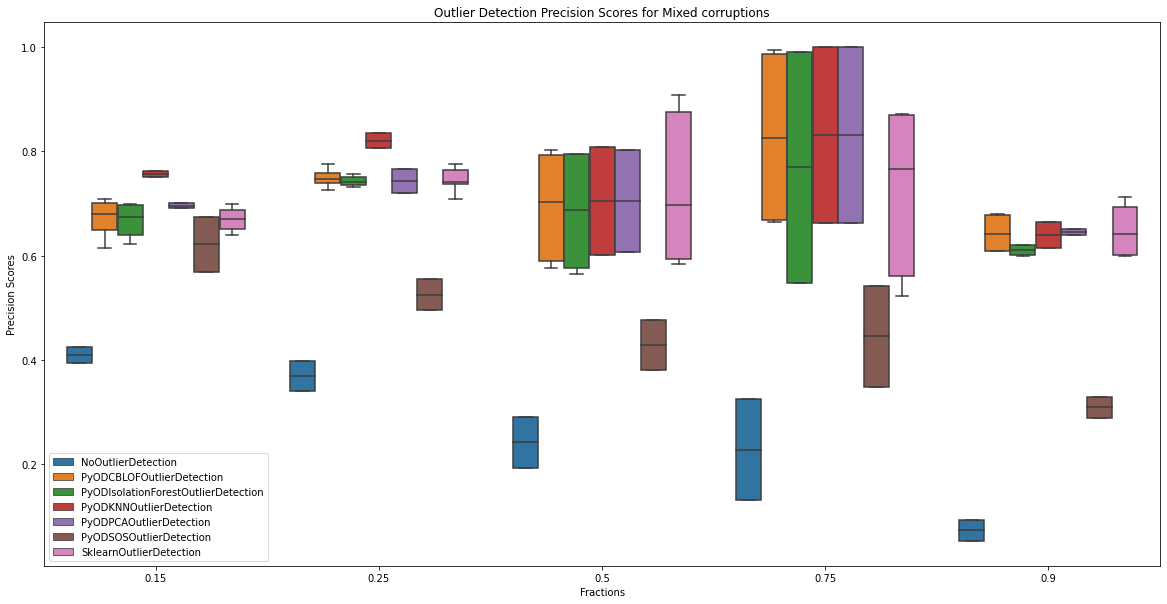

In [43]:
sns.boxplot(x='fraction', y='value', data=df_od_prec, hue='od_method')
plt.xlabel("Fractions")
plt.ylabel("Precision Scores")
plt.title("Outlier Detection Precision Scores for Mixed corruptions")
plt.legend(loc='lower left')

plt.show()

In [44]:
df_od_rec = getDfForPlots(od_recalls, od_methods, 'od_method')
df_od_rec

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,fraction,od_method,value
0,0.15,NoOutlierDetection,0.500000
1,0.15,NoOutlierDetection,0.500000
2,0.15,NoOutlierDetection,0.500000
3,0.15,NoOutlierDetection,0.500000
4,0.15,NoOutlierDetection,0.500000
...,...,...,...
205,0.90,SklearnOutlierDetection,0.795536
206,0.90,SklearnOutlierDetection,0.781548
207,0.90,SklearnOutlierDetection,0.671759
208,0.90,SklearnOutlierDetection,0.666759


/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


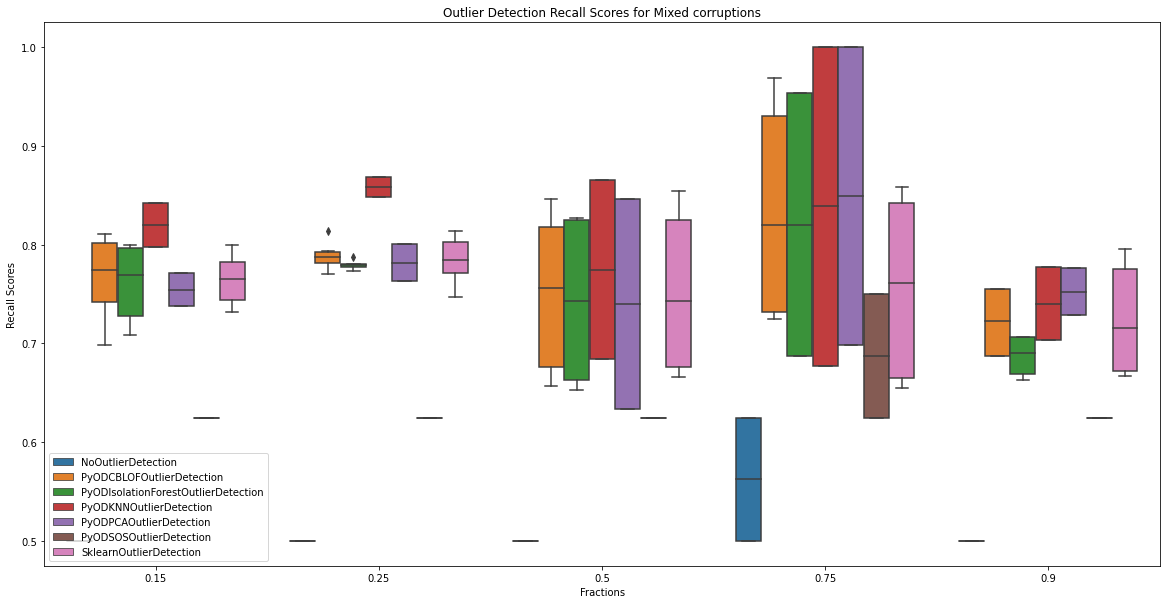

In [45]:
sns.boxplot(x='fraction', y='value', data=df_od_rec, hue='od_method')
plt.xlabel("Fractions")
plt.ylabel("Recall Scores")
plt.title("Outlier Detection Recall Scores for Mixed corruptions")
plt.legend(loc='lower left')

plt.show()

In [ ]:
## imputation

In [46]:
df_imp_prec = getDfForPlots(imp_precisions, imp_methods, 'imp_method')
df_imp_prec

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,fraction,imp_method,value
0,0.15,DatawigImputation,0.833287
1,0.15,DatawigImputation,0.836378
2,0.15,DatawigImputation,0.842827
3,0.15,DatawigImputation,0.839557
4,0.15,DatawigImputation,0.842827
...,...,...,...
205,0.90,SklearnImputation,0.418267
206,0.90,SklearnImputation,0.393765
207,0.90,SklearnImputation,0.453028
208,0.90,SklearnImputation,0.382372


/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


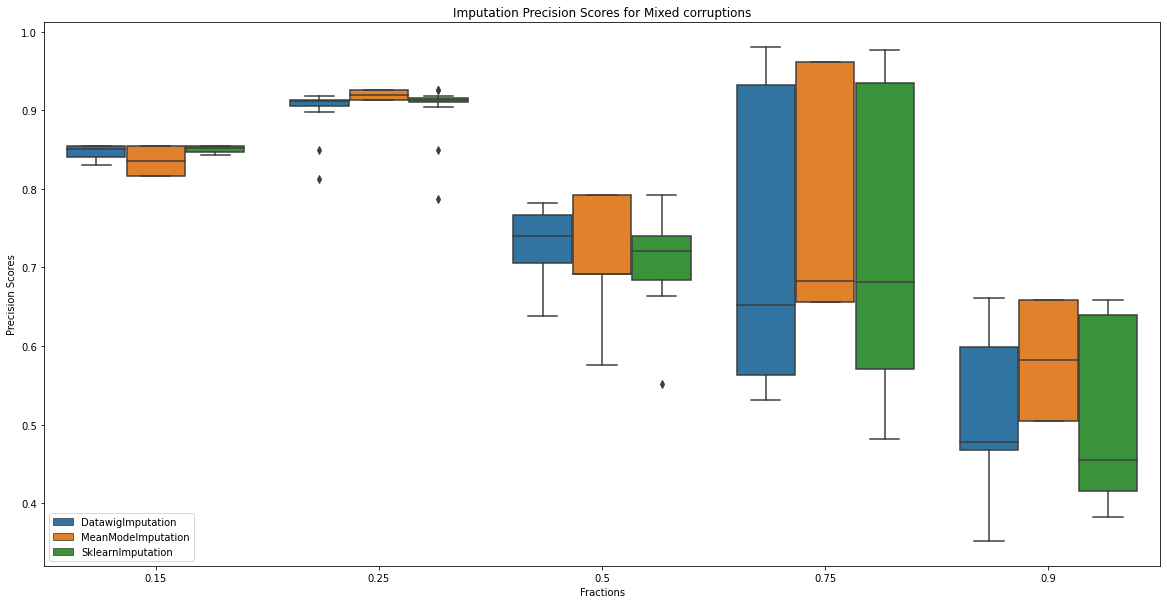

In [47]:
sns.boxplot(x='fraction', y='value', data=df_imp_prec, hue='imp_method')
plt.xlabel("Fractions")
plt.ylabel("Precision Scores")
plt.title("Imputation Precision Scores for Mixed corruptions")
plt.legend(loc='lower left')

plt.show()

In [48]:
df_imp_rec = getDfForPlots(imp_recalls, imp_methods, 'imp_method')
df_imp_rec

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,fraction,imp_method,value
0,0.15,DatawigImputation,0.879115
1,0.15,DatawigImputation,0.887736
2,0.15,DatawigImputation,0.904977
3,0.15,DatawigImputation,0.896357
4,0.15,DatawigImputation,0.904977
...,...,...,...
205,0.90,SklearnImputation,0.456633
206,0.90,SklearnImputation,0.421514
207,0.90,SklearnImputation,0.481633
208,0.90,SklearnImputation,0.409609


/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


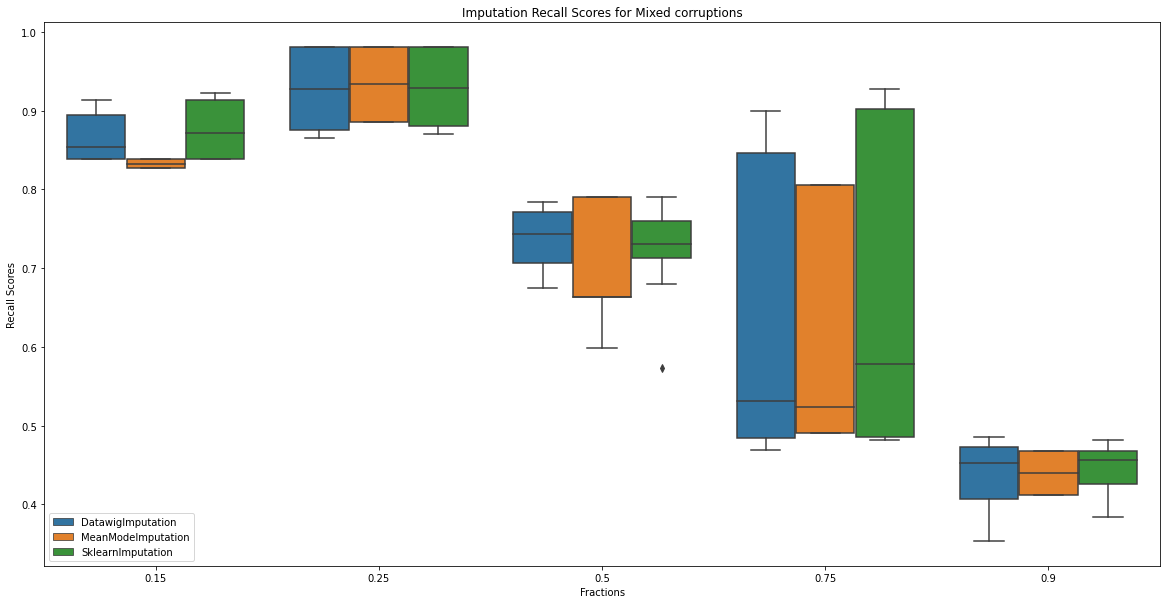

In [49]:
sns.boxplot(x='fraction', y='value', data=df_imp_rec, hue='imp_method')
plt.xlabel("Fractions")
plt.ylabel("Recall Scores")
plt.title("Imputation Recall Scores for Mixed corruptions")
plt.legend(loc='lower left')

plt.show()

In [ ]:
### autogluon

In [121]:
results_autoguon = ind_results.copy()
results_autoguon

{0.15: [{'dataset': 'thoracic_surgery',
   'model': None,
   'corruptions': defaultdict(list,
               {('PRE30',): [MissingValues: {'column': 'PRE30', 'fraction': 0.15, 'sampling': 'MAR', 'na_value': nan},
                 CategoricalShift: {'column': 'PRE30', 'fraction': 0.15, 'sampling': 'MCAR'}],
                ('PRE5',): [Scaling: {'column': 'PRE5', 'fraction': 0.15, 'sampling': 'MNAR'}],
                ('AGE',): [GaussianNoise: {'column': 'AGE', 'fraction': 0.15, 'sampling': 'MCAR'}]}),
   'cleaners': [{'Outlier detection method': NoOutlierDetection,
     'Outlier Detection Score': {'Precision': 0.39095744680851063,
      'Recall': 0.5,
      'F1-score': 0.43795959163275505,
      'Accuracy': 0.7819148936170213},
     'Imputation method': MeanModeImputation,
     'Imputation Score': {'Precision': 0.7062643239113827,
      'Recall': 0.6973684210526316,
      'F1-score': 0.7015873015873015,
      'Accuracy': 0.8191489361702128,
      'Mean Squared Error': 5966.964512384013}

In [122]:
od_precisions_a = getMethodMetrics(results_autoguon, 'Outlier Detection Score', 'Precision')
od_precisions_a

{0.15: [0.39095744680851063,
  0.39095744680851063,
  0.8822973995597139,
  0.8822973995597139,
  0.8070462164750958,
  0.8034564393939394,
  0.7919021950271949,
  0.7919021950271949,
  0.8213830587293702,
  0.8171735312899107,
  0.6721409574468085,
  0.6721409574468085,
  0.7997616248693835,
  0.721588612579569,
  0.39344262295081966,
  0.39344262295081966,
  0.836169676514421,
  0.836169676514421,
  0.7473525840208579,
  0.7188409268327302,
  0.736675911531939,
  0.736675911531939,
  0.722936687394008,
  0.7418387623305656,
  0.5368852459016393,
  0.5368852459016393,
  0.7765573770491804,
  0.7315573770491803,
  0.40625,
  0.40625,
  0.796875,
  0.796875,
  0.7457386363636364,
  0.7457386363636364,
  0.7247596153846154,
  0.7247596153846154,
  0.7457386363636364,
  0.7457386363636364,
  0.546875,
  0.546875,
  0.7911931818181819,
  0.7815777972027973,
  0.39095744680851063,
  0.39095744680851063,
  0.8826841787439614,
  0.8826841787439614,
  0.8072518438509209,
  0.8158867122719735,


### Boxplot

In [123]:
df_od_prec_a = pd.DataFrame.from_dict(od_precisions_a, orient='index', columns=od_methods * int(len(od_precisions_a[next(iter(od_precisions_a))])/len(od_methods)))
df_od_prec_a.insert(loc=0, column="fraction", value=df_od_prec_a.index)

df_od_prec_a = pd.melt(df_od_prec_a, id_vars=['fraction'], var_name='od_method').sort_values(by=["fraction", "od_method"])
df_od_prec_a.reset_index(inplace=True, drop=True)

df_od_prec_a

,fraction,od_method,value
0,0.15,NoOutlierDetection,0.390957
1,0.15,NoOutlierDetection,0.390957
2,0.15,NoOutlierDetection,0.393443
3,0.15,NoOutlierDetection,0.393443
4,0.15,NoOutlierDetection,0.406250
...,...,...,...
415,0.90,SklearnOutlierDetection,0.547397
416,0.90,SklearnOutlierDetection,0.899425
417,0.90,SklearnOutlierDetection,0.924342
418,0.90,SklearnOutlierDetection,0.869318


/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


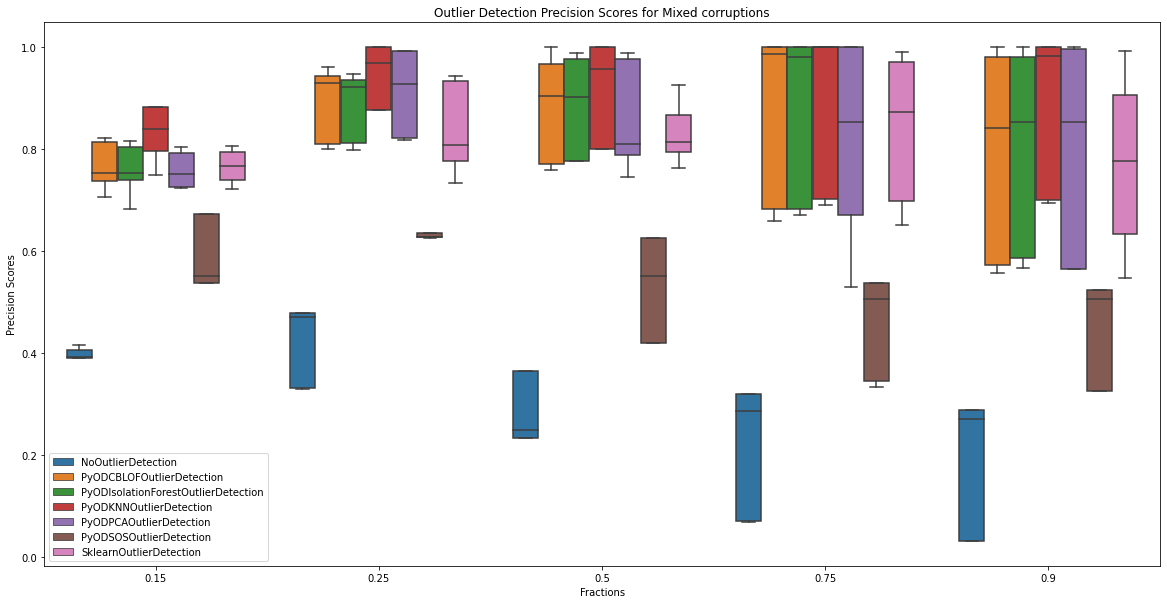

In [124]:
sns.boxplot(x='fraction', y='value', data=df_od_prec_a, hue='od_method')
plt.xlabel("Fractions")
plt.ylabel("Precision Scores")
plt.title("Outlier Detection Precision Scores for Mixed corruptions")
plt.legend(loc='lower left')

plt.show()

### Extras

In [50]:
results_dict = ind_results.copy()

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [127]:
fracs = []

od_methods = []
od_precisions = []
od_recalls = []
od_f1scores = []
od_accuracy = []

for frac in results_dict.keys():
    for i in range(len(results_dict[frac])):
        for j in range(len(results_dict[frac][i]['cleaners'])):
            fracs.append(frac)
            od_methods.append(results_dict[frac][i]['cleaners'][j]['Outlier detection method'])
            od_precisions.append(results_dict[frac][i]['cleaners'][j]['Outlier Detection Score']['Precision'])
            od_recalls.append(results_dict[frac][i]['cleaners'][j]['Outlier Detection Score']['Recall'])
            od_f1scores.append(results_dict[frac][i]['cleaners'][j]['Outlier Detection Score']['F1-score'])
            od_accuracy.append(results_dict[frac][i]['cleaners'][j]['Outlier Detection Score']['Accuracy'])
            
df_od = pd.DataFrame({
    'fraction': fracs, 
    'od_method': od_methods, 
    'od_precision': od_precisions, 
    'od_recall': od_recalls,
    'od_f1-score': od_f1scores,
    'od_accuracy': od_accuracy
})

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [143]:
df_od['od_method'] = df_od['od_method'].astype('category')

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'od_precision'}, xlabel='[fraction]'>

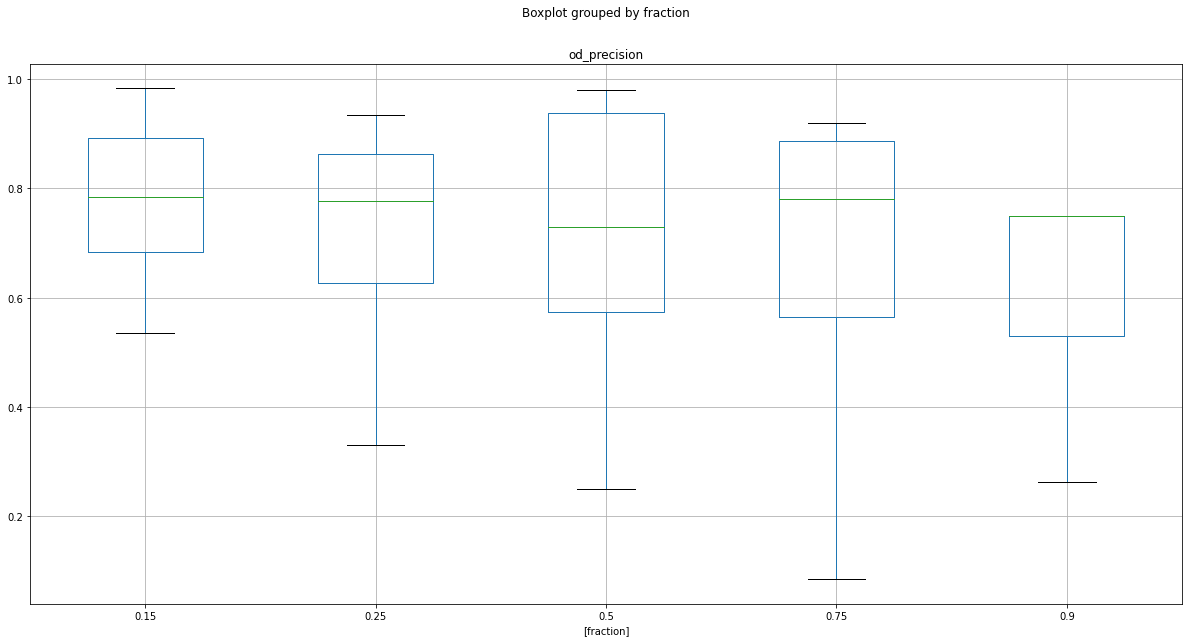

In [154]:
df.boxplot(column=['od_precision'], by=['fraction'])

In [128]:
fracs = []

imp_methods = []
imp_precisions = []
imp_recalls = []
imp_f1scores = []
imp_accuracy = []

for frac in results_dict.keys():
    for i in range(len(results_dict[frac])):
        for j in range(len(results_dict[frac][i]['cleaners'])):
            fracs.append(frac)
            
            imp_methods.append(results_dict[frac][i]['cleaners'][j]['Imputation method'])
            imp_precisions.append(results_dict[frac][i]['cleaners'][j]['Imputation Score']['Precision'])
            imp_recalls.append(results_dict[frac][i]['cleaners'][j]['Imputation Score']['Recall'])
            imp_f1scores.append(results_dict[frac][i]['cleaners'][j]['Imputation Score']['F1-score'])
            imp_accuracy.append(results_dict[frac][i]['cleaners'][j]['Imputation Score']['Accuracy'])
            
df_imp = pd.DataFrame({
    'fraction': fracs,
    'imp_method': imp_methods, 
    'imp_precision': imp_precisions, 
    'imp_recall': imp_recalls,
    'imp_f1-score': imp_f1scores,
    'imp_accuracy': imp_accuracy
})

In [129]:
fracs = []

models = []
roc_auc_scores = []
model_accuracy = []

for frac in results_dict.keys():
    for i in range(len(results_dict[frac])):
        for j in range(len(results_dict[frac][i]['cleaners'])):
            fracs.append(frac)
            
            models.append(ind_results[frac][i]['model'])
            roc_auc_scores.append(ind_results[frac][i]['cleaners'][j]['PPP score with cleaning']['roc_auc_score'])
            model_accuracy.append(ind_results[frac][i]['cleaners'][j]['PPP score with cleaning']['classification_report']['accuracy'])
            
df_model = pd.DataFrame({
    'fraction': fracs, 
    'model': models,
    'roc_auc_score': roc_auc_scores,
    'model_accuracy': model_accuracy
})